## Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os, sys
import numpy as np
import csv
import cv2

In [3]:
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import numpy as np
from PIL import Image
import networkx as nx
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt
import ebooklib
from ebooklib import epub
import random
import re
import os
import nltk
from nltk.corpus import words
import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names
from sklearn.decomposition import PCA
import scipy.spatial
from matplotlib import cm
import matplotlib.image as mpimg
import pandas as pd
import jieba
from sklearn.metrics.pairwise import linear_kernel
from nltk import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn

In [5]:
model4 = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3),
  include_top=False,
  pooling='avg'
)

## Indie Film Frames

In [6]:
indiefilmFiles = os.listdir('D:\\FinalAssignment\\MoviesKeyframes')

In [8]:
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [9]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [13]:
indiefilmfeatures = []
for m in indiefilmFiles:
    if m != '.DS_Store':
        path = os.path.join('D:\\FinalAssignment\\MoviesKeyframes', m)
        f = processImage(path, model4)
        indiefilmfeatures.append(f)

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 67ms/step


In [14]:
with open('indiefilmfeatures.pkl', 'wb') as f:
    pickle.dump(indiefilmfeatures, f)

In [15]:
with open('indiefilmfeatures.pkl', 'rb') as f:
    indiefilmfeatures = pickle.load(f)

In [16]:
indiefilmfeatureImagePairs = []
for i in range(len(indiefilmfeatures)):
    featureImage = {}
    featureImage['image'] = indiefilmFiles[i]
    featureImage['feature'] = indiefilmfeatures[i]
    indiefilmfeatureImagePairs.append(featureImage)

In [17]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [18]:
def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [19]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        np.random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE
# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)
def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

Epoch: 1, QE: 0.2614, TE: 0.3277


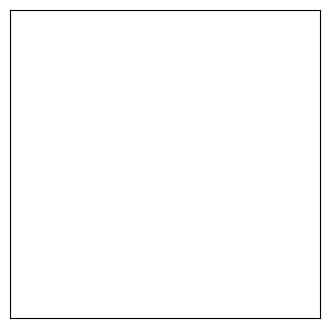

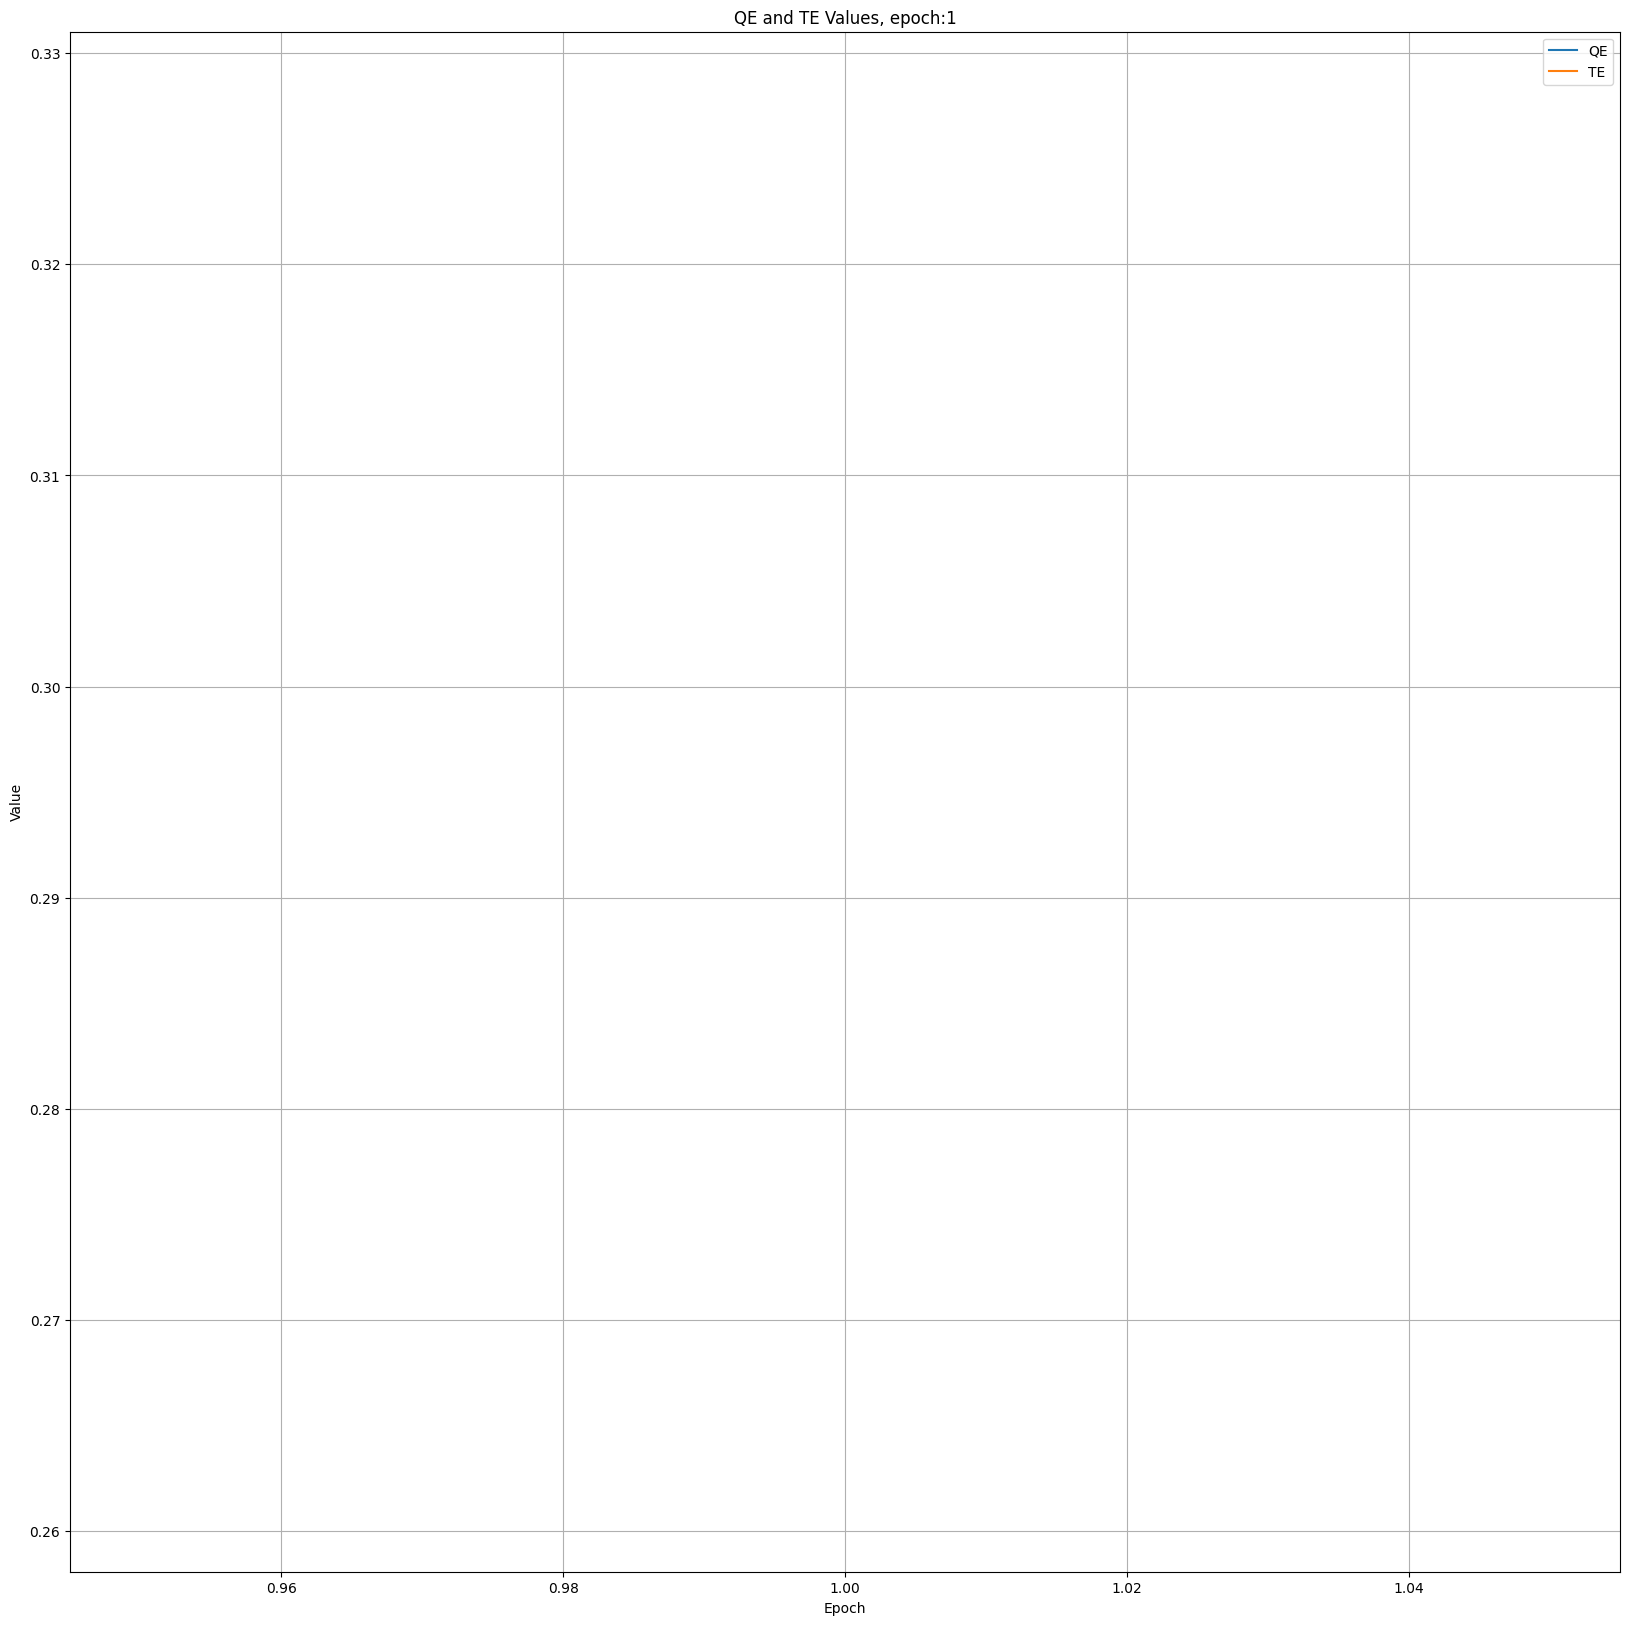

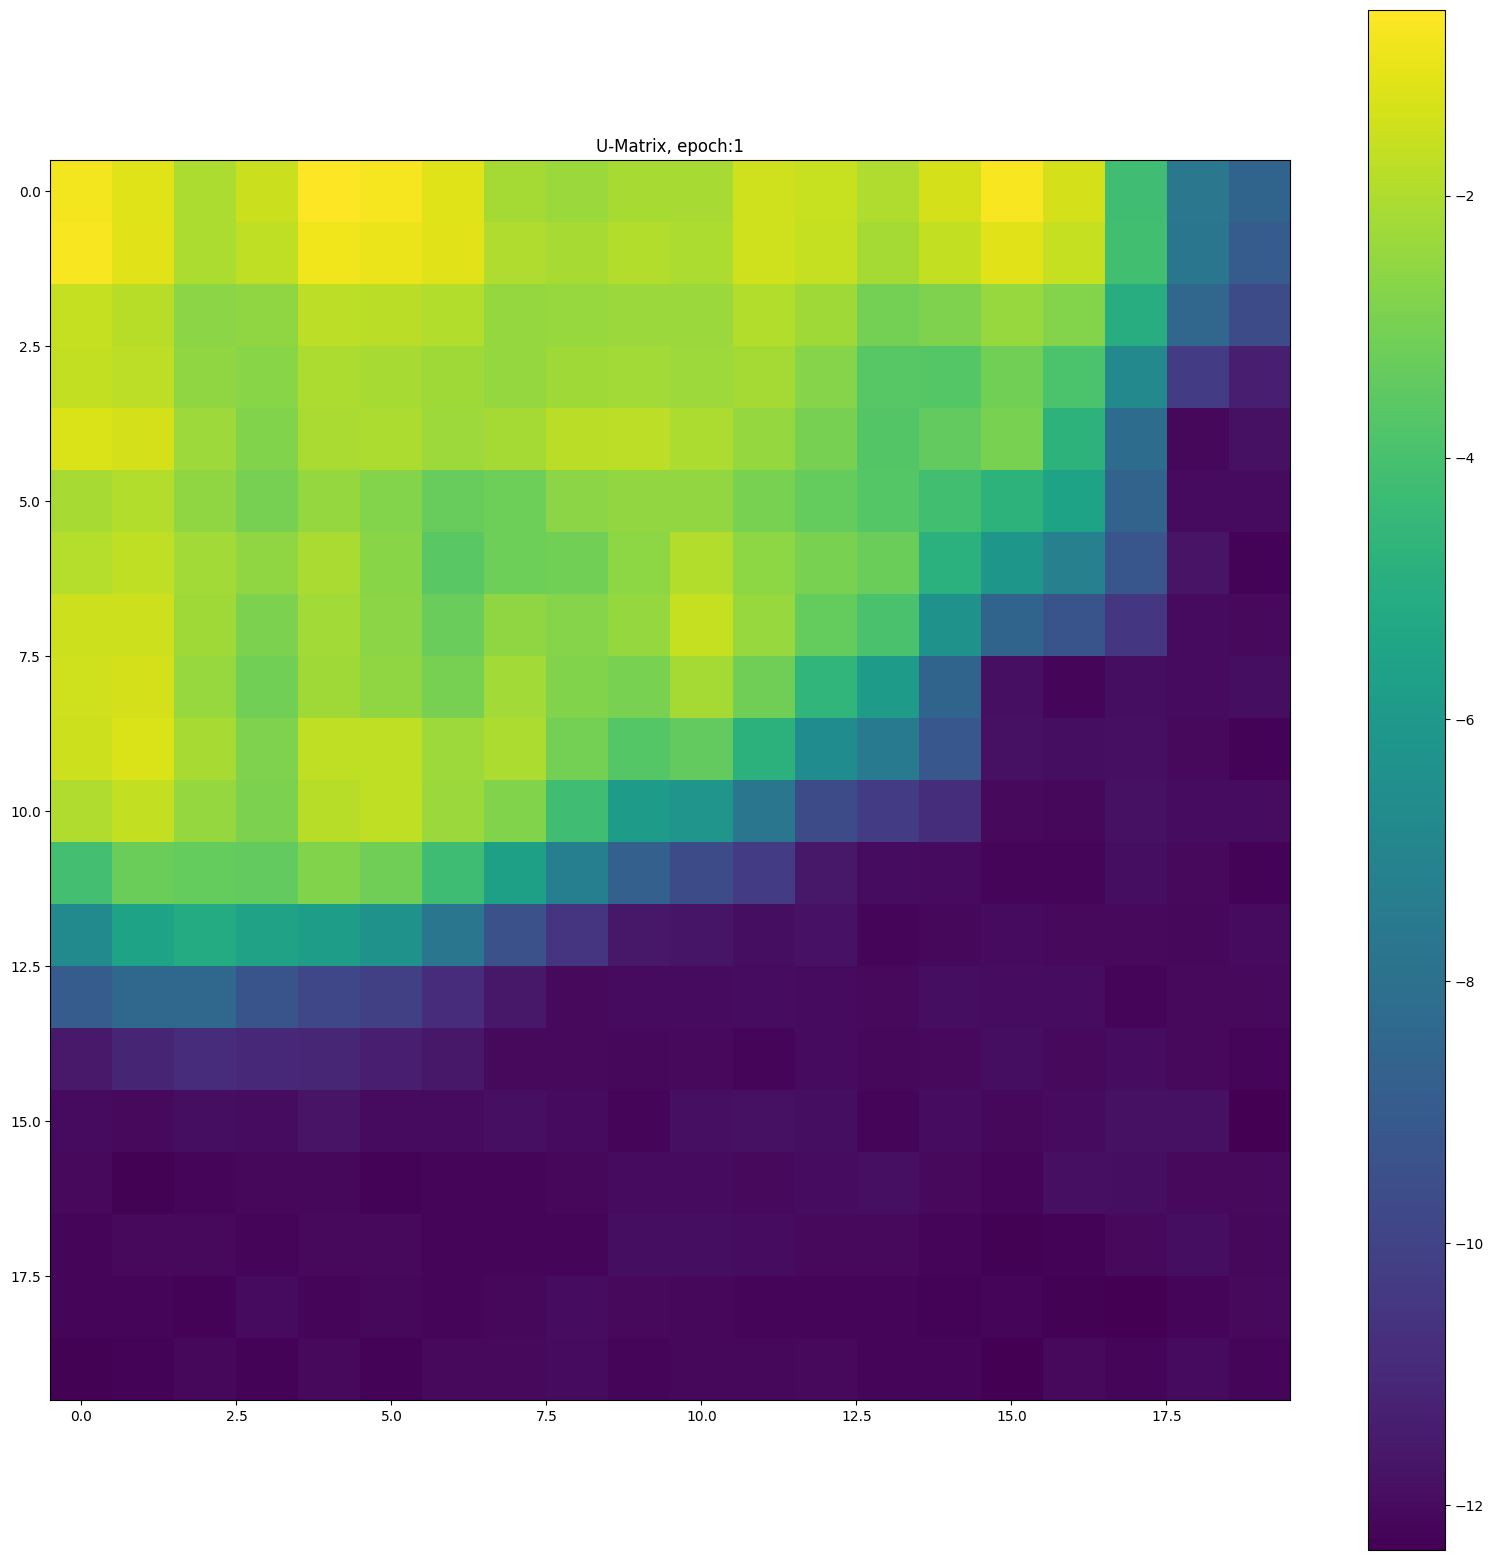

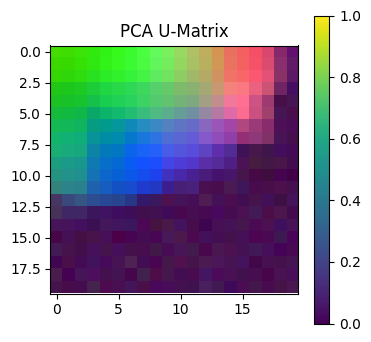

Epoch: 2, QE: 0.2507, TE: 0.3741


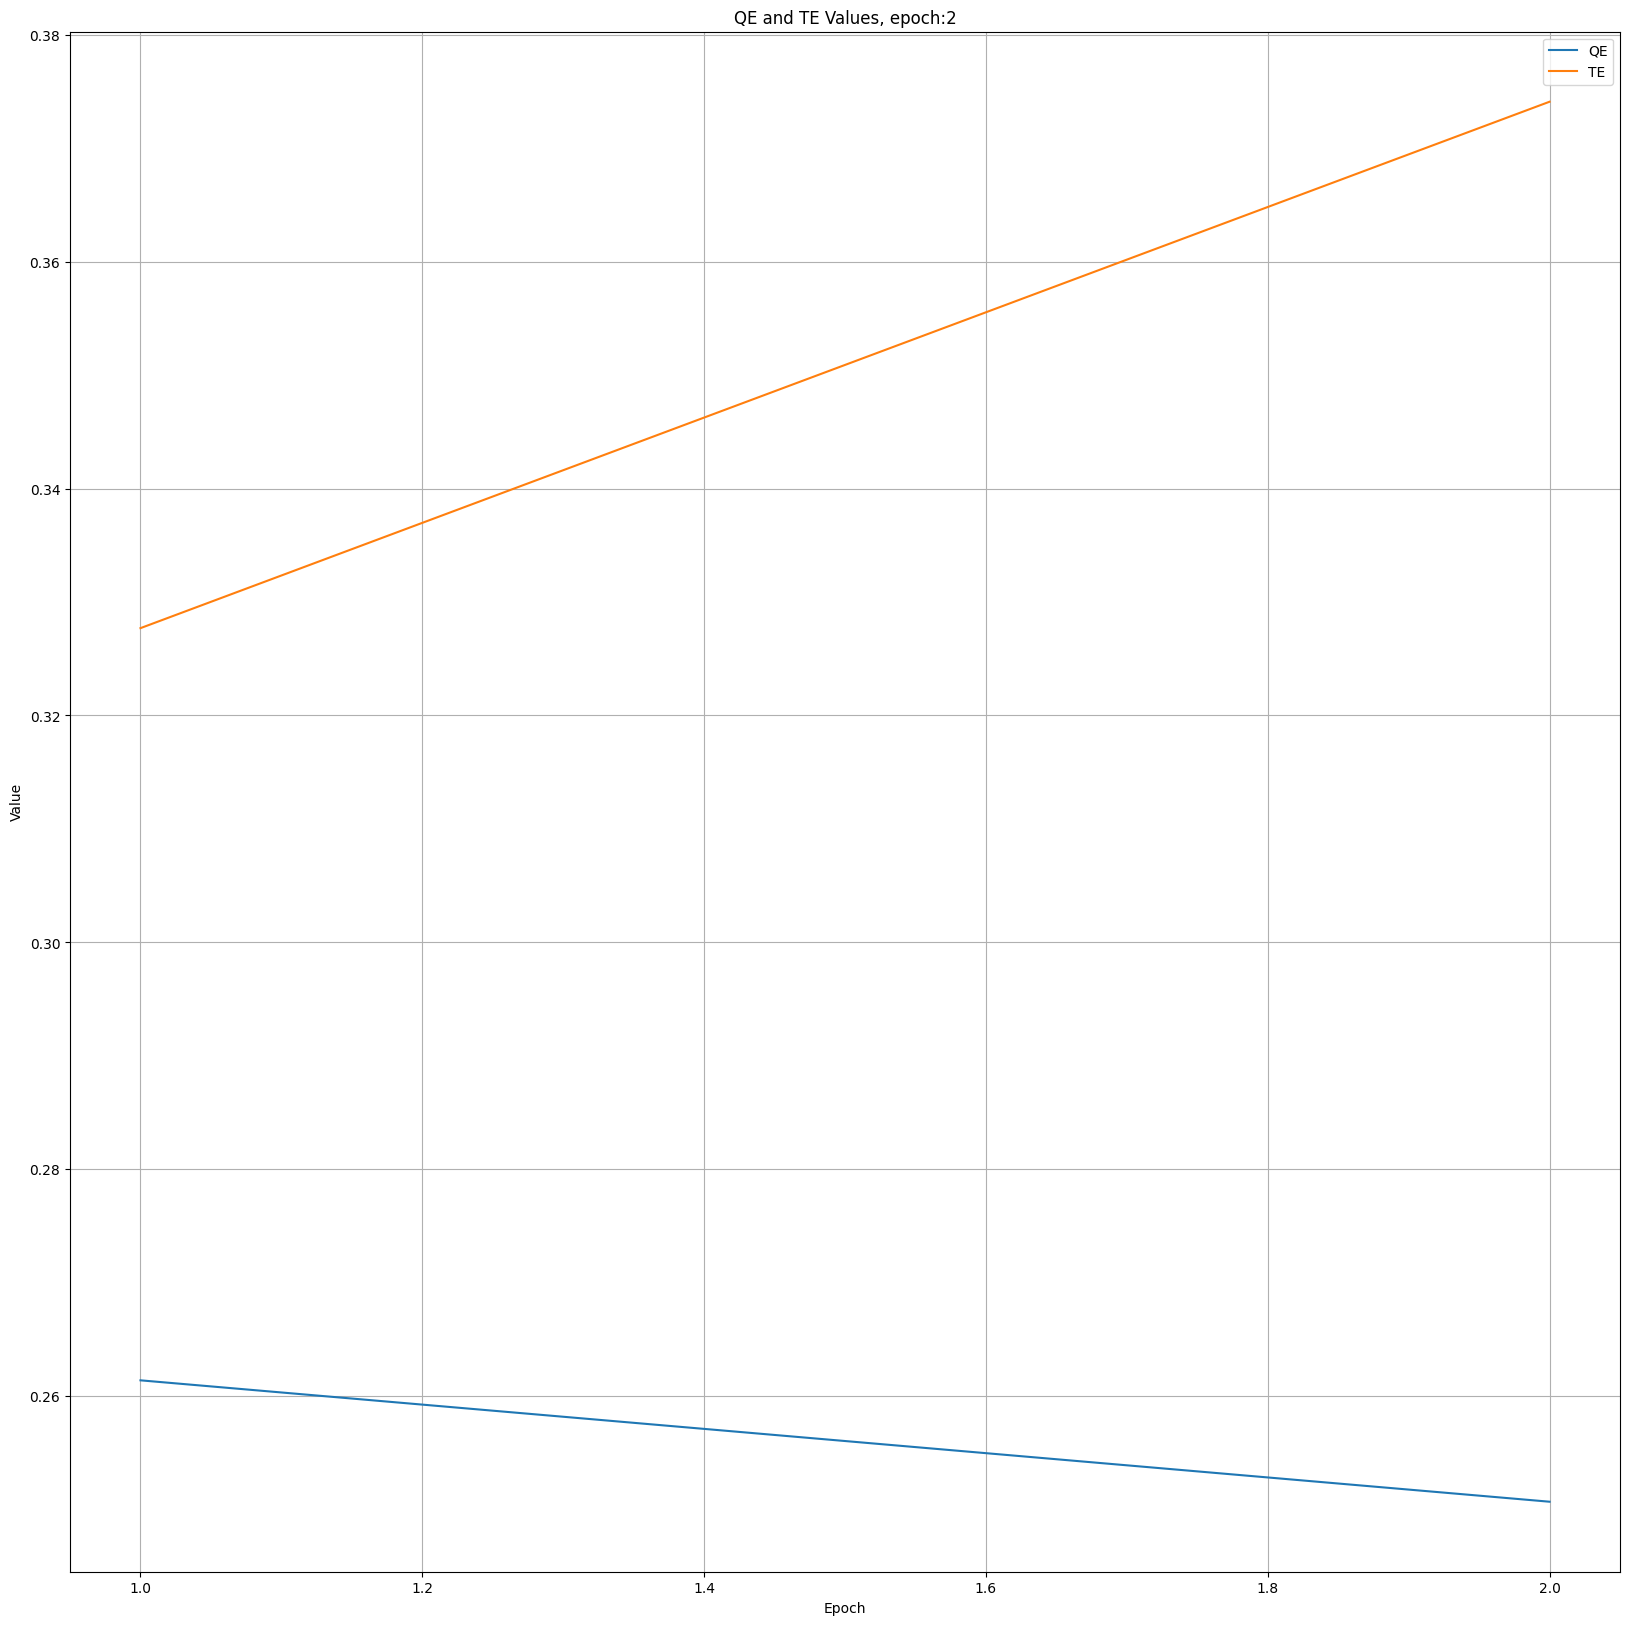

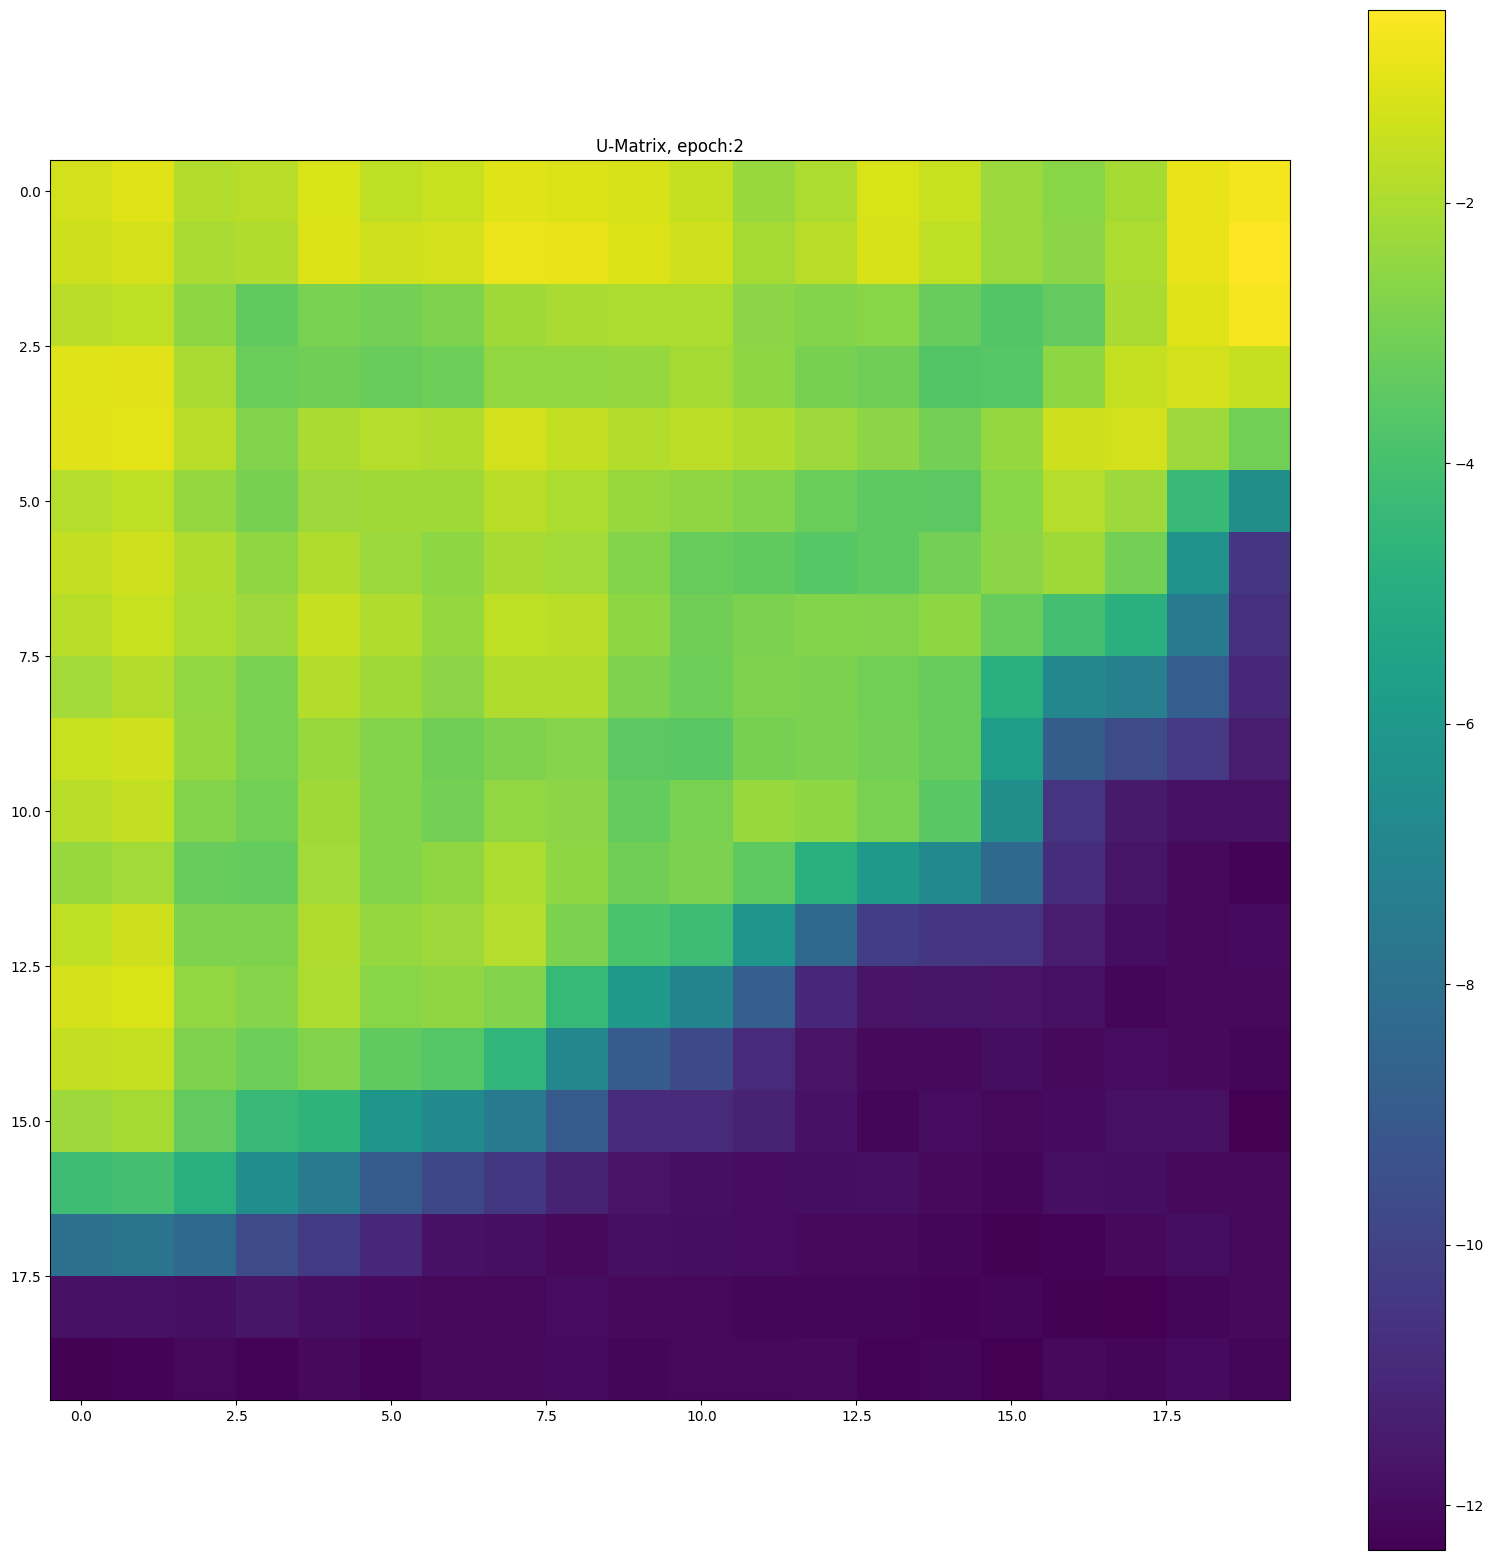

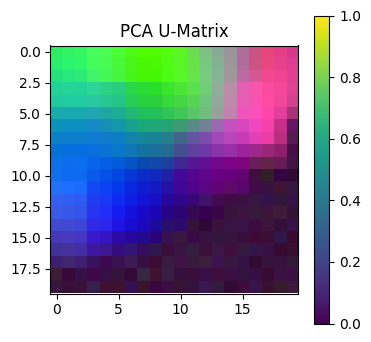

Epoch: 3, QE: 0.2435, TE: 0.3223


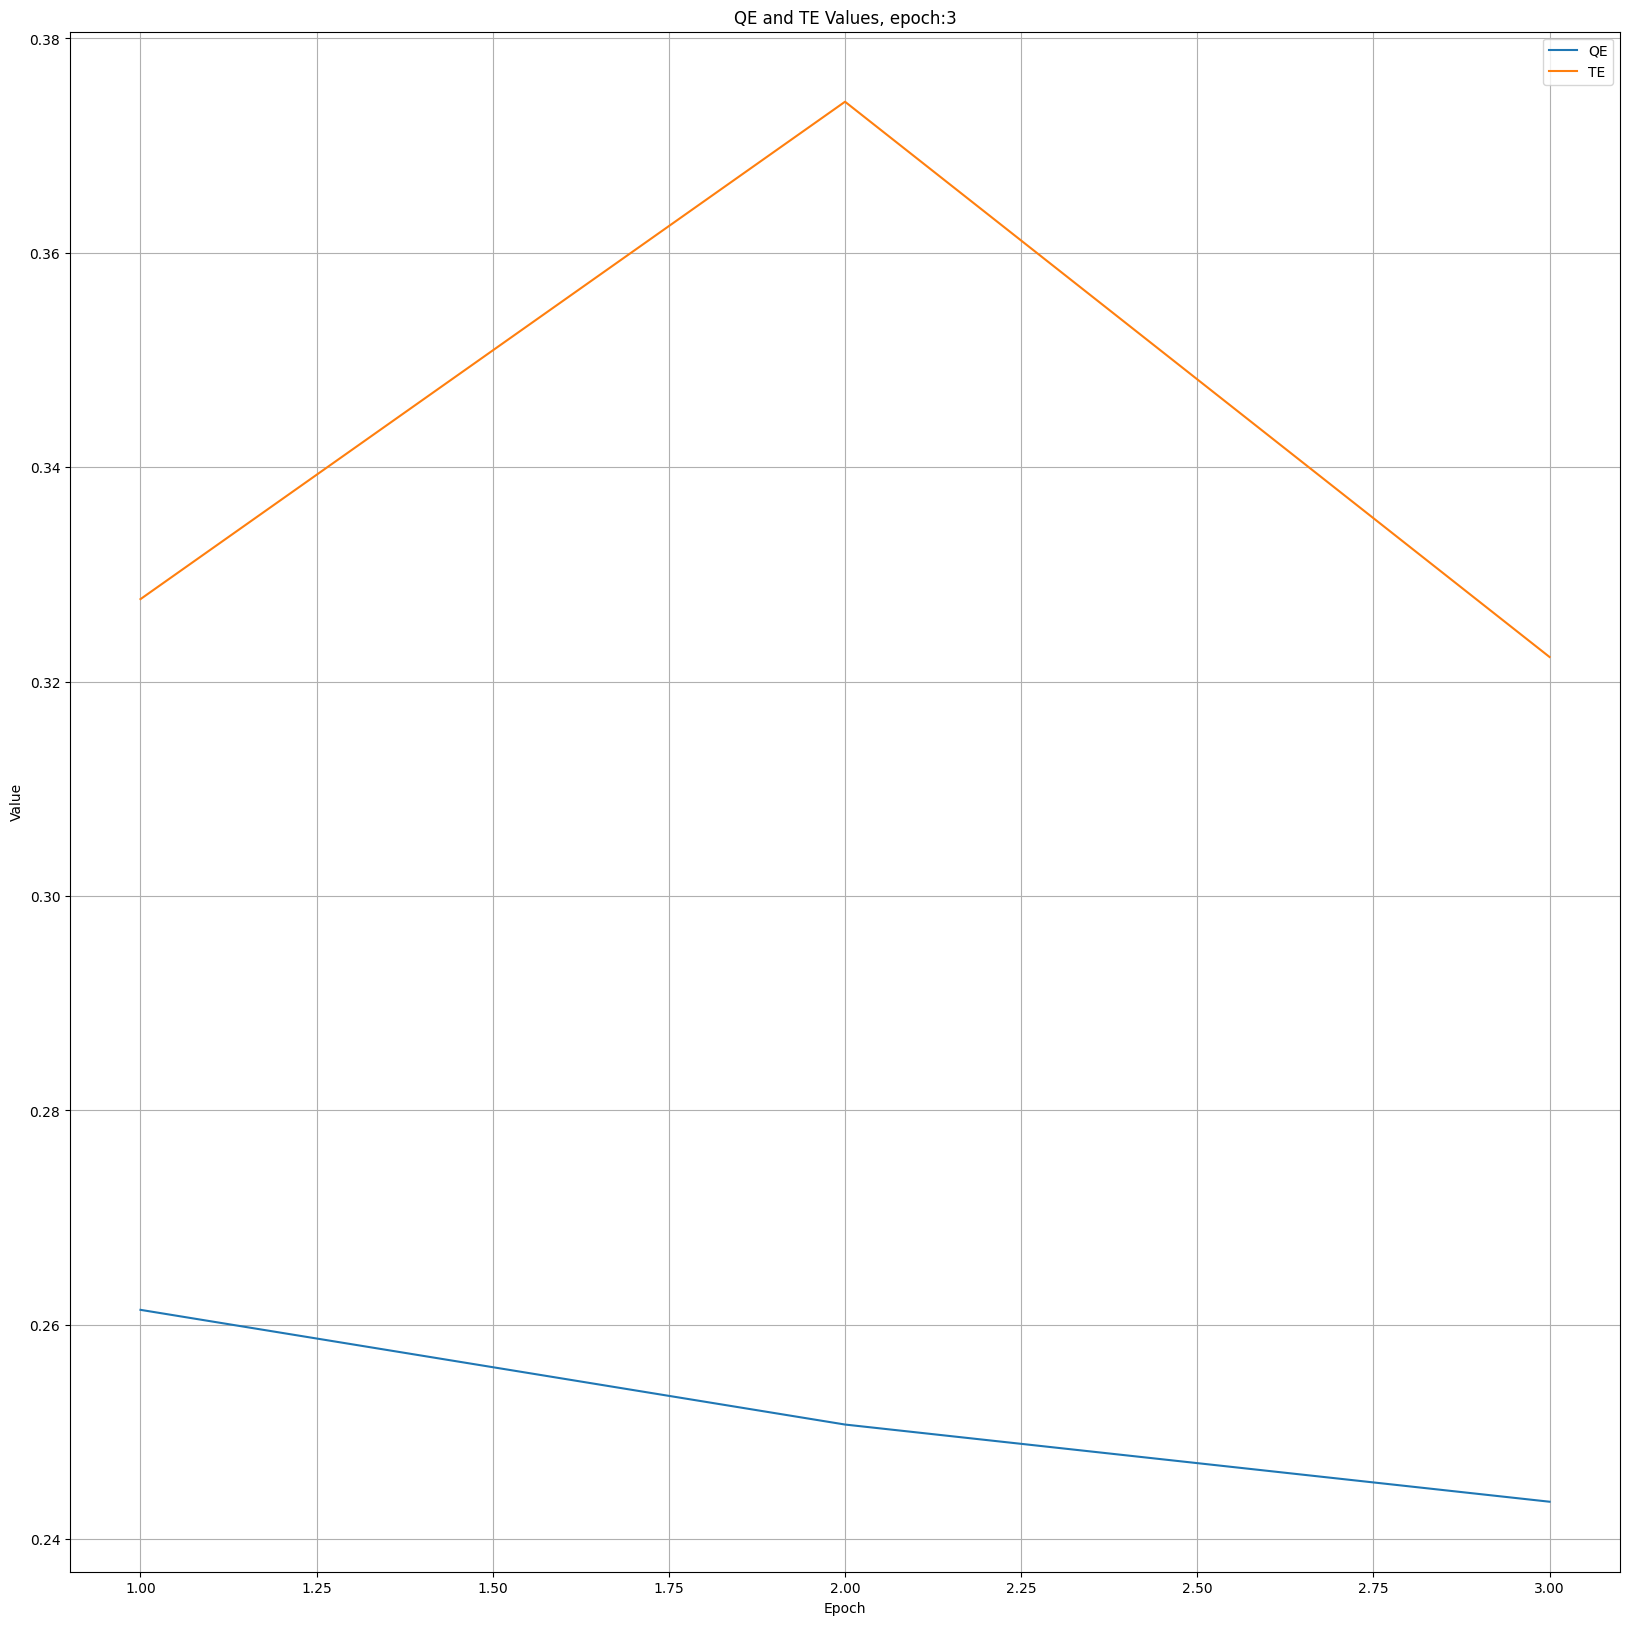

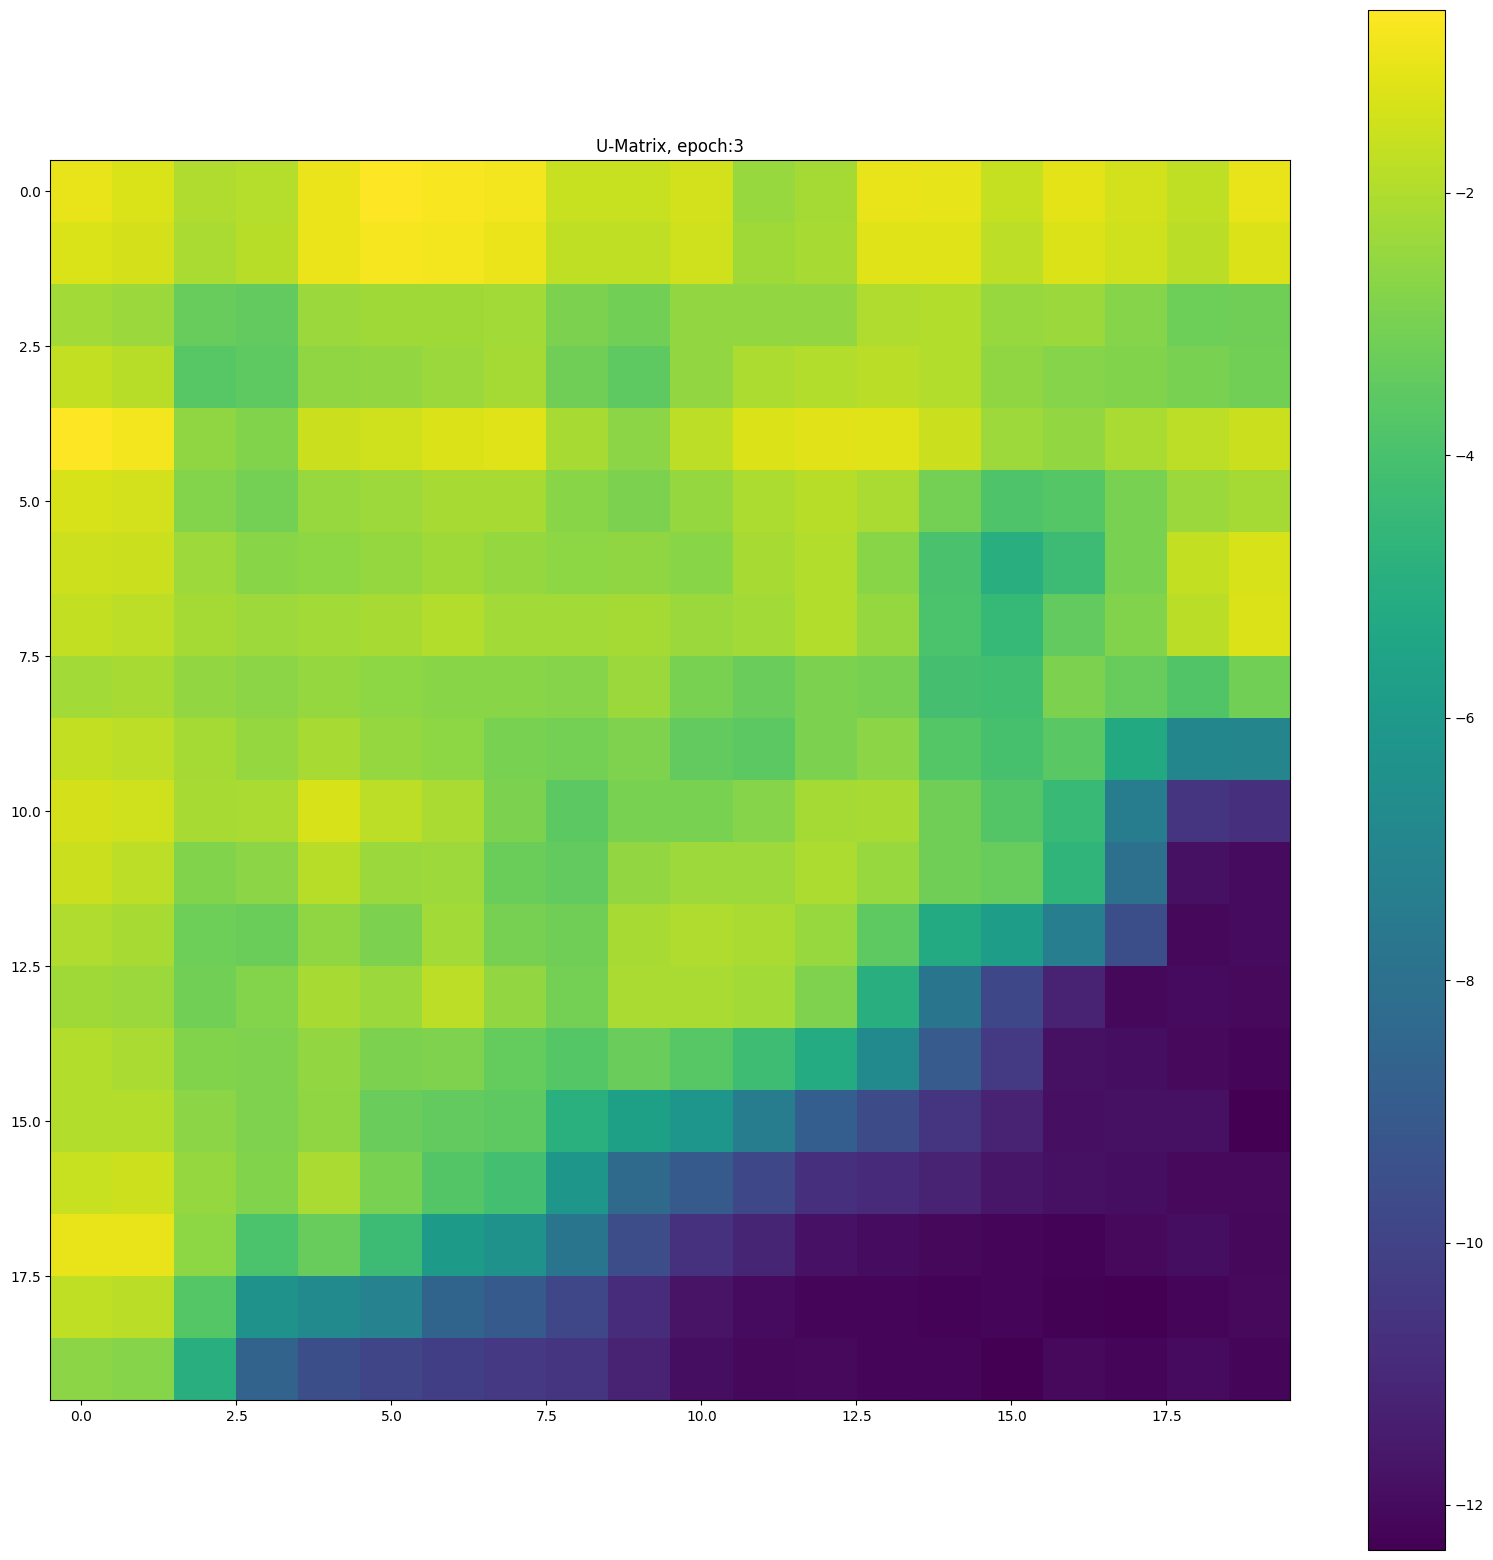

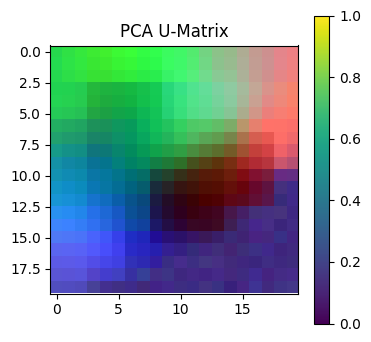

Epoch: 4, QE: 0.2423, TE: 0.3339


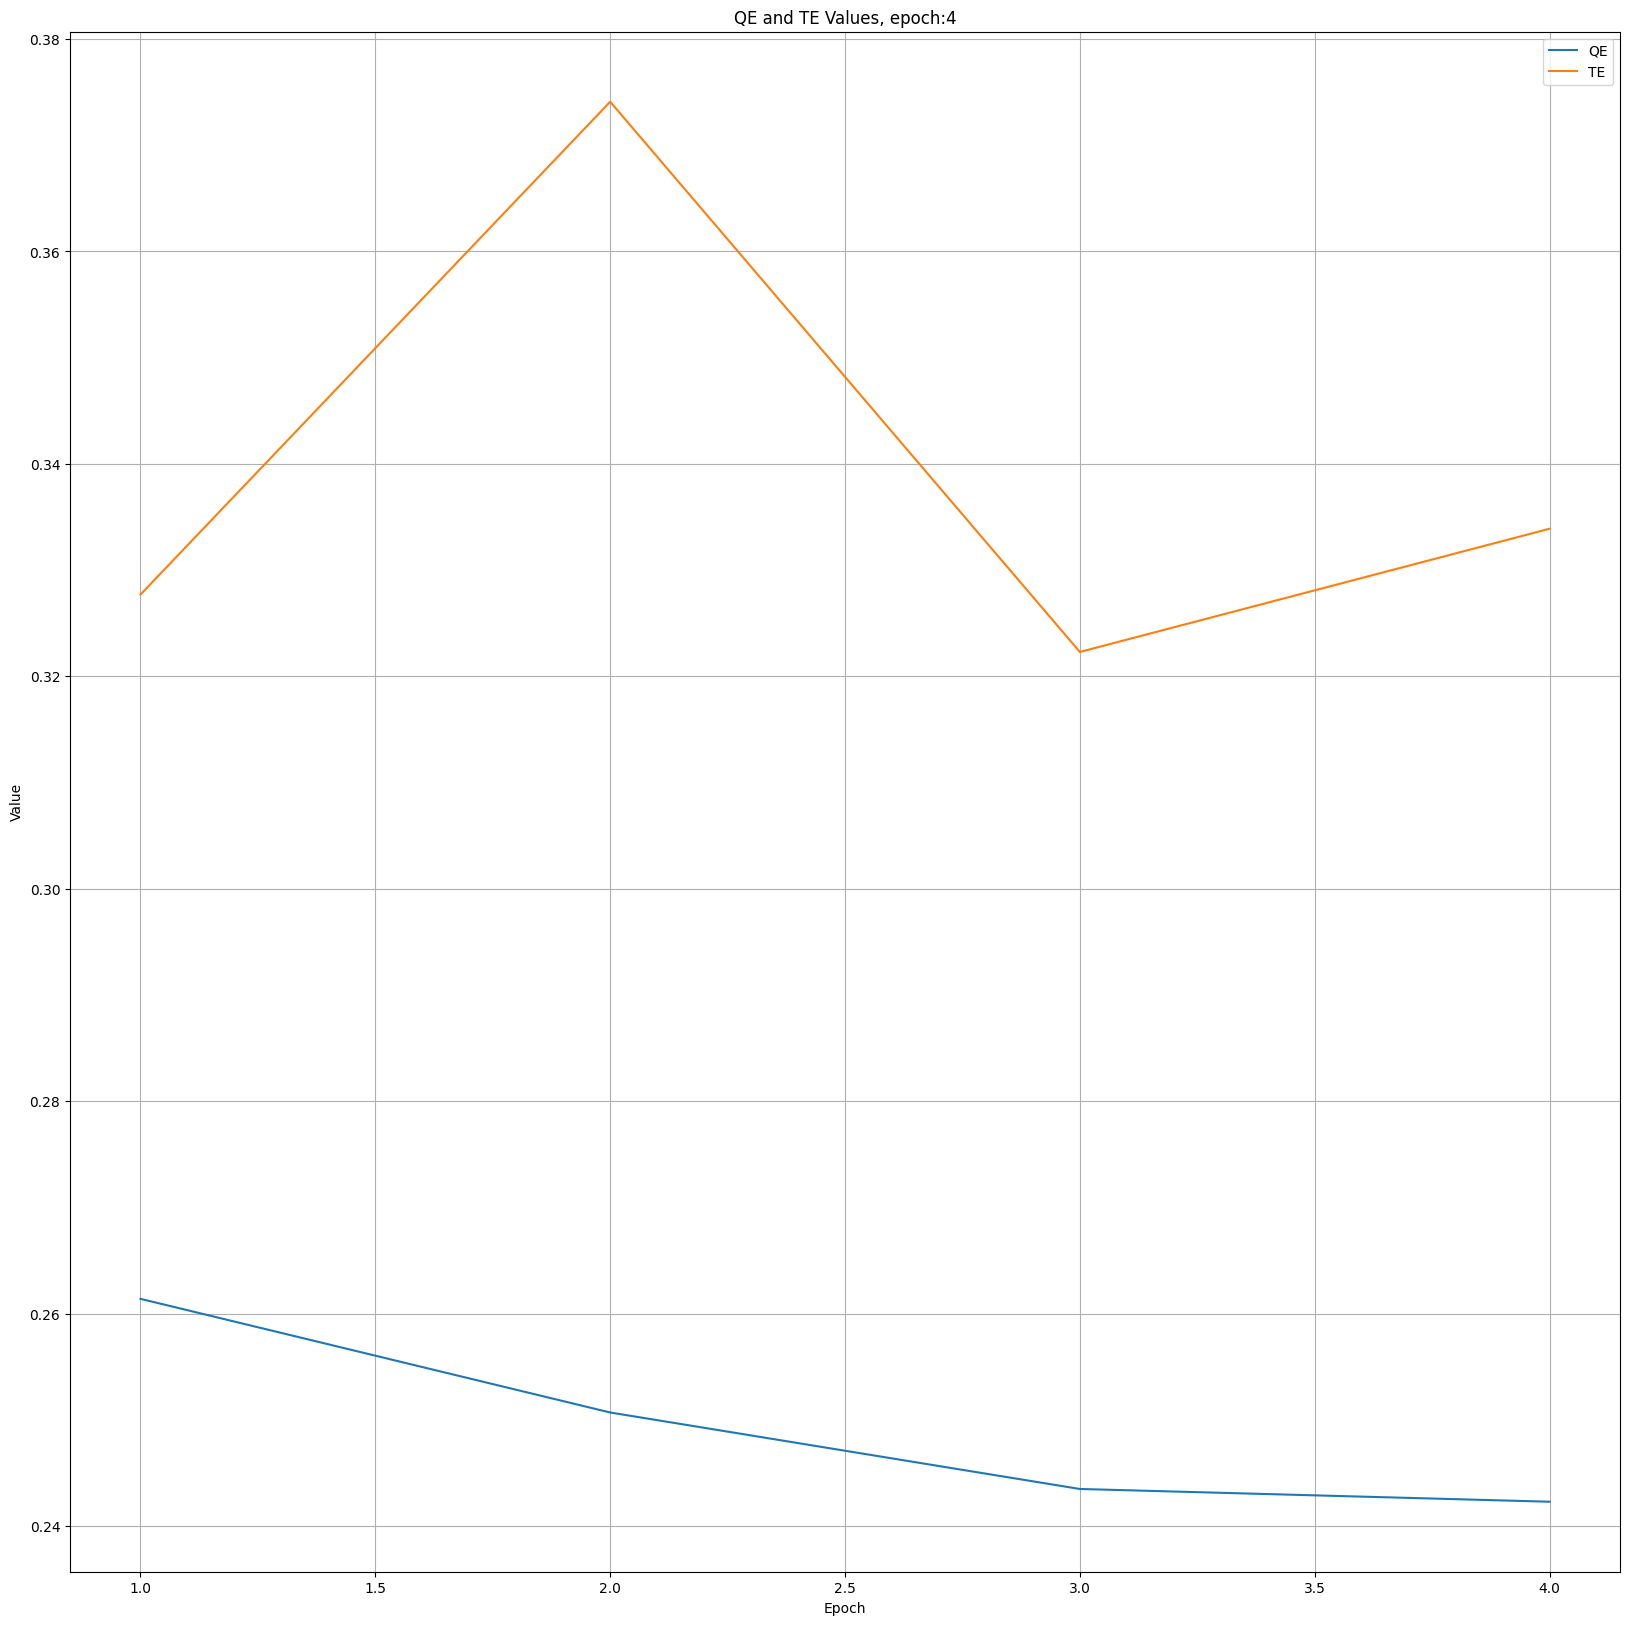

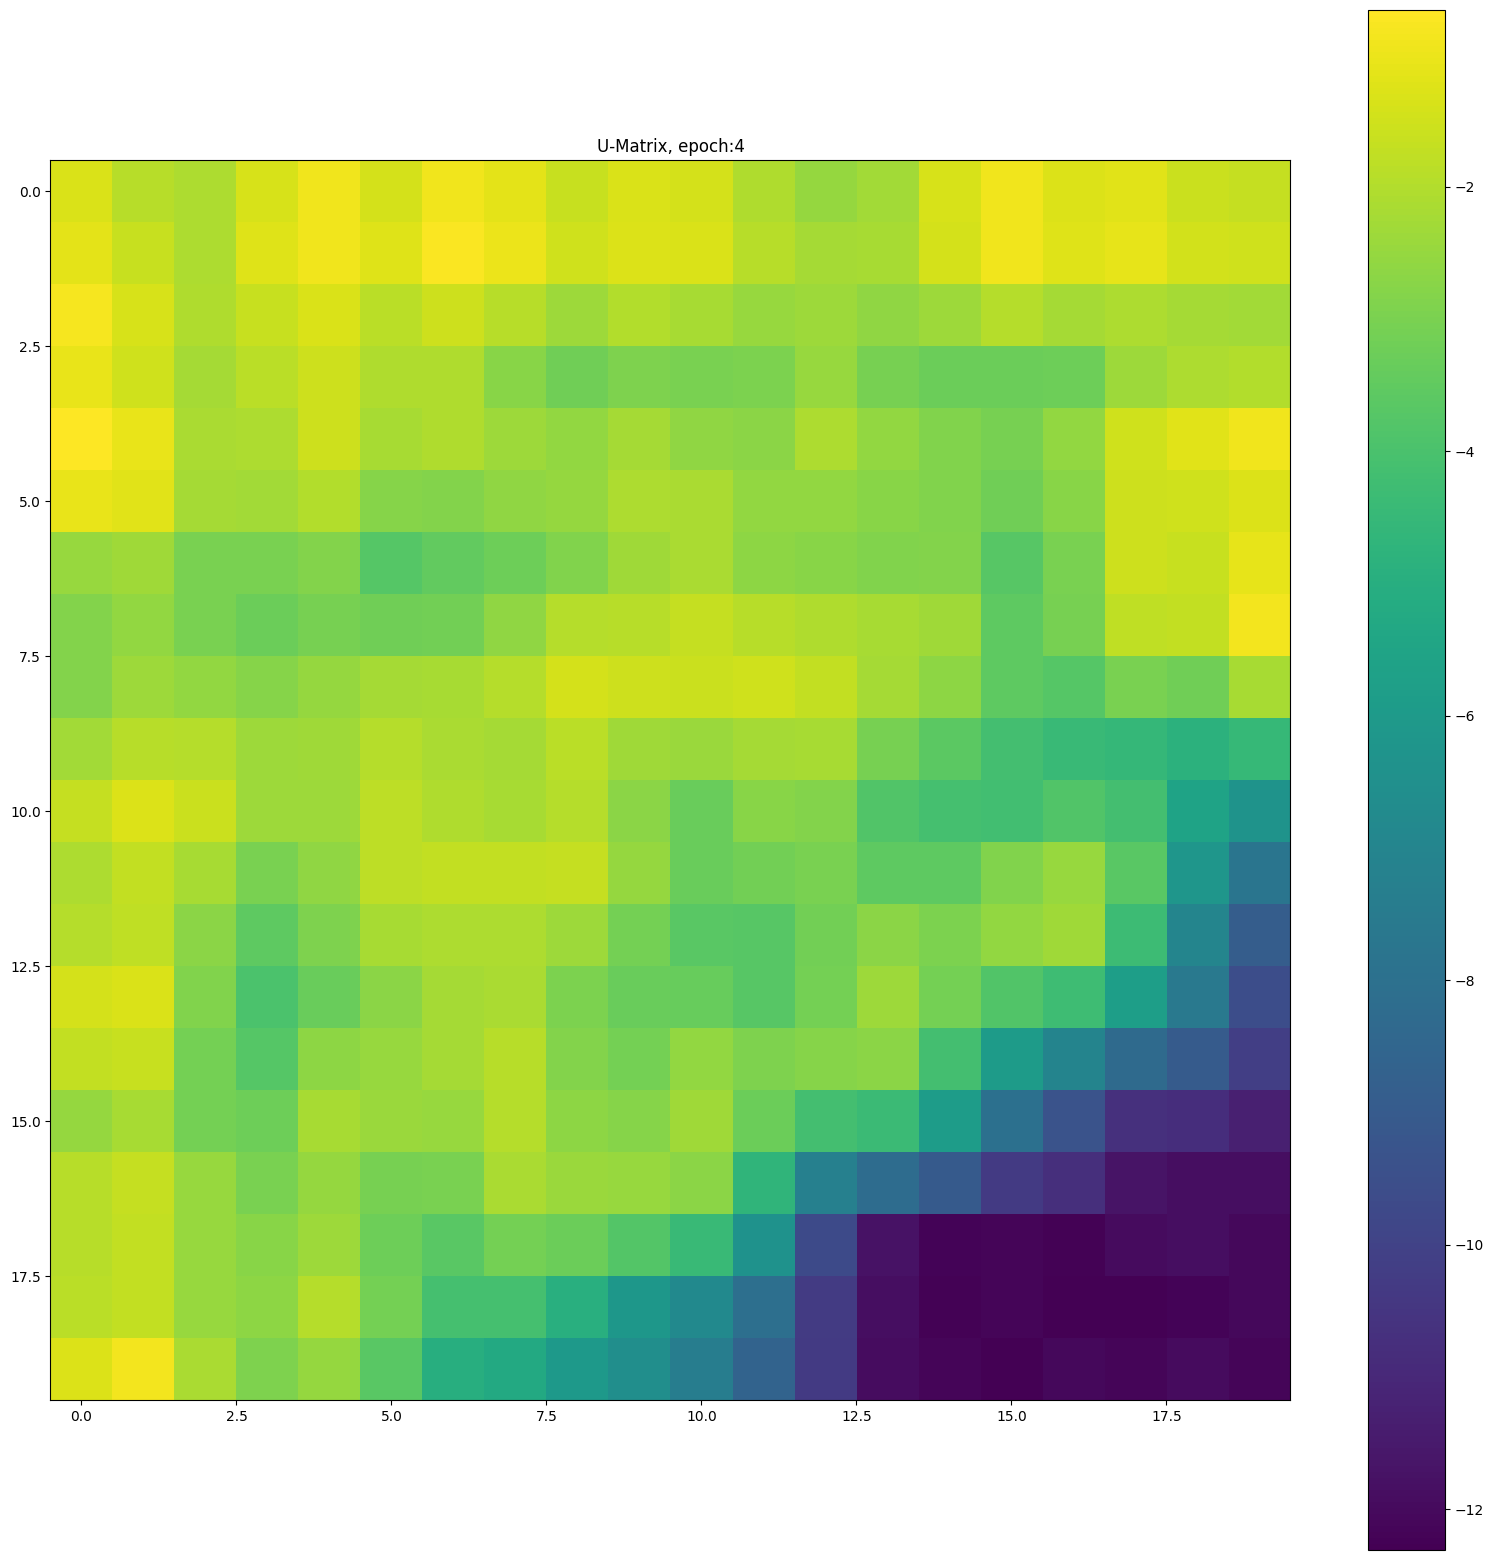

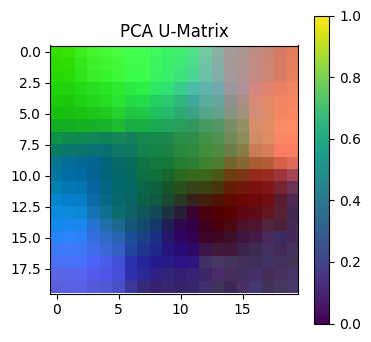

Epoch: 5, QE: 0.2407, TE: 0.3402


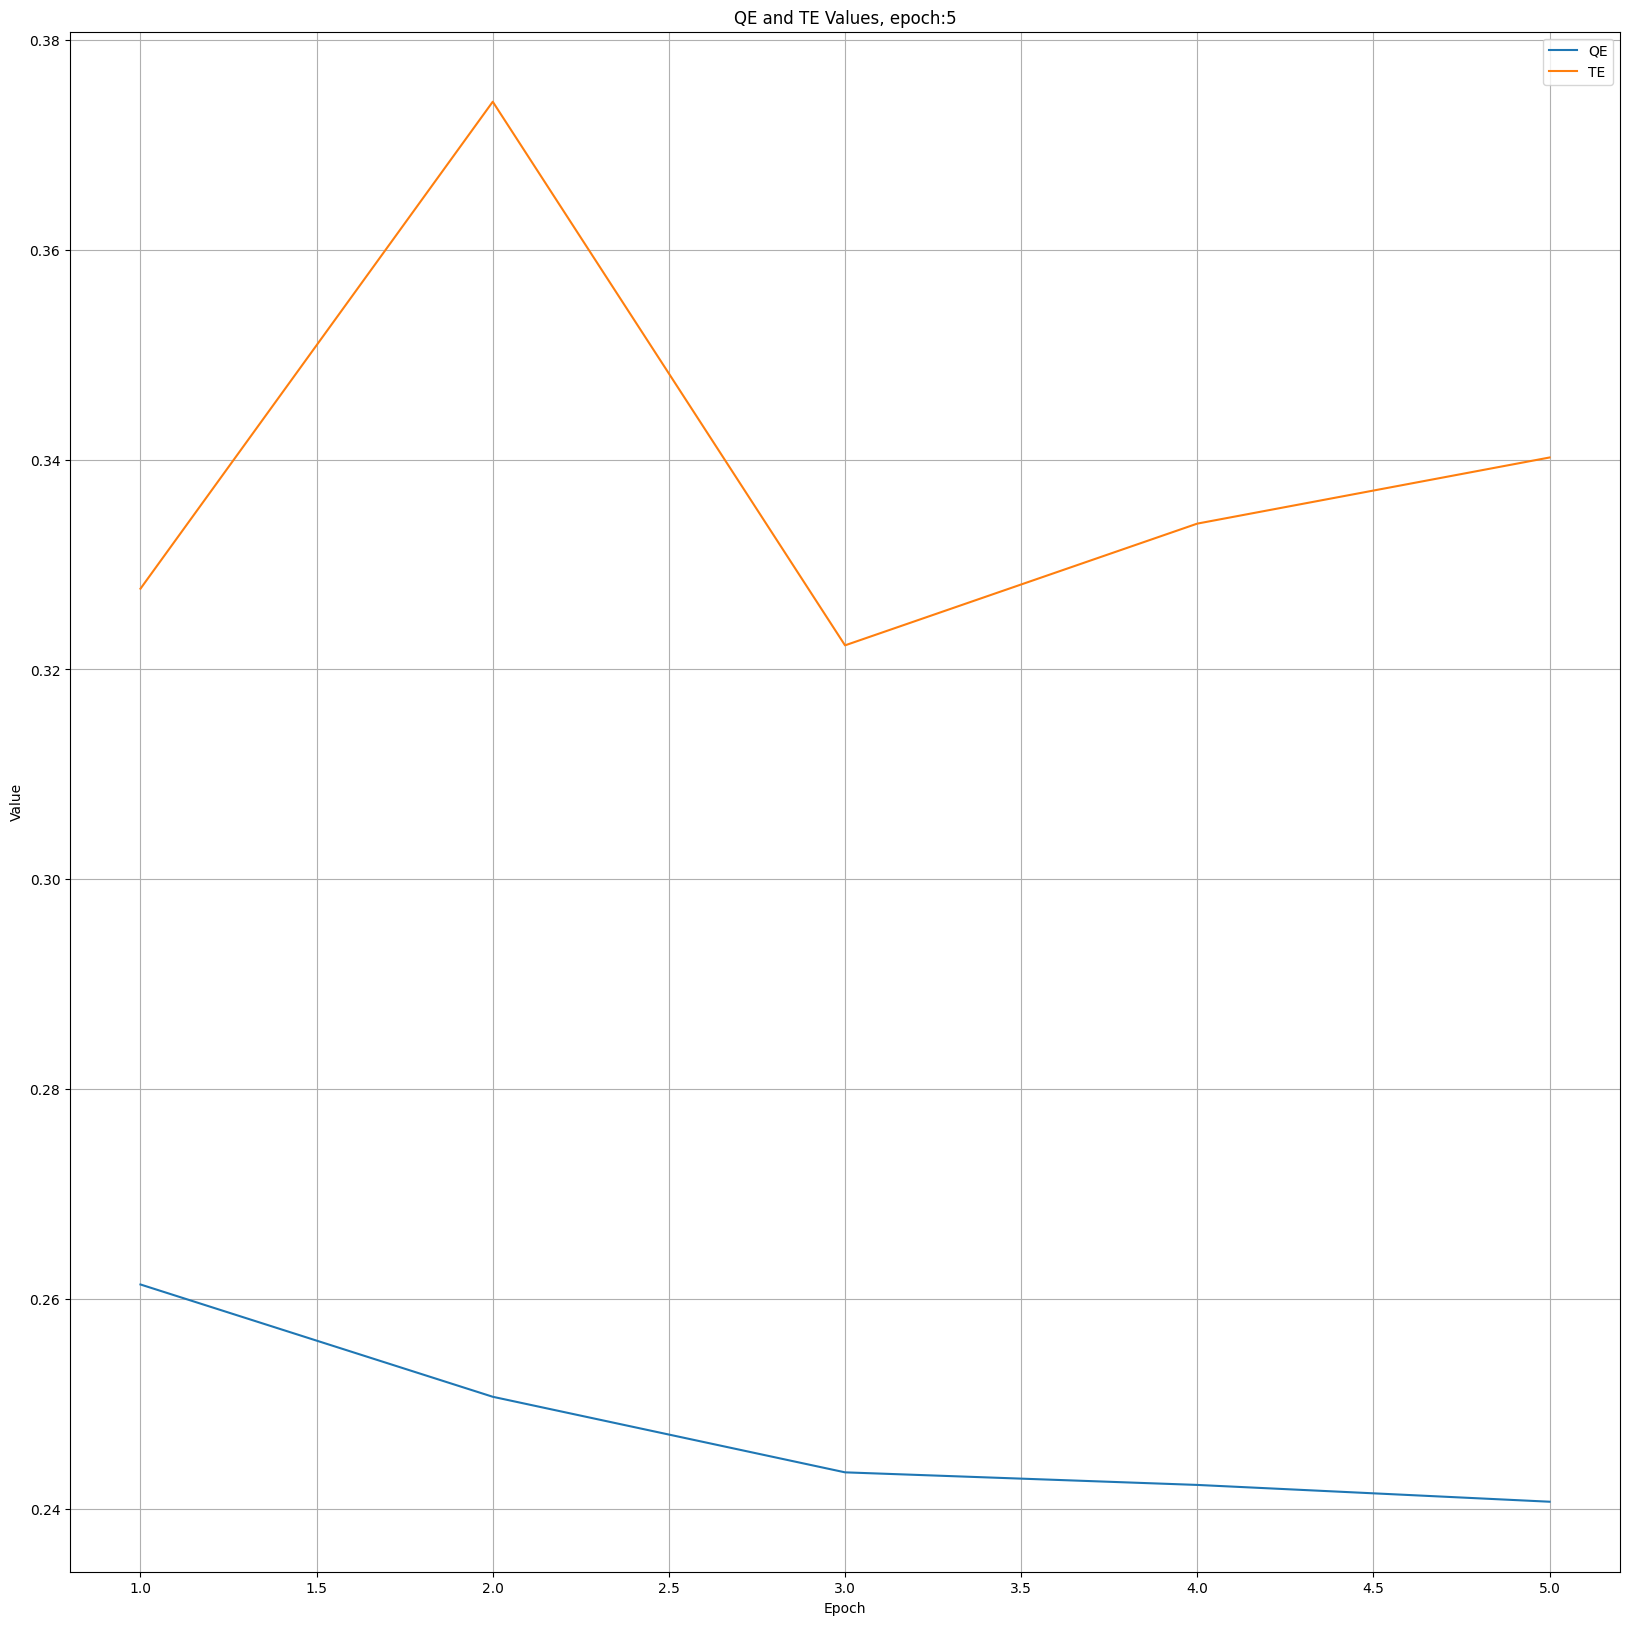

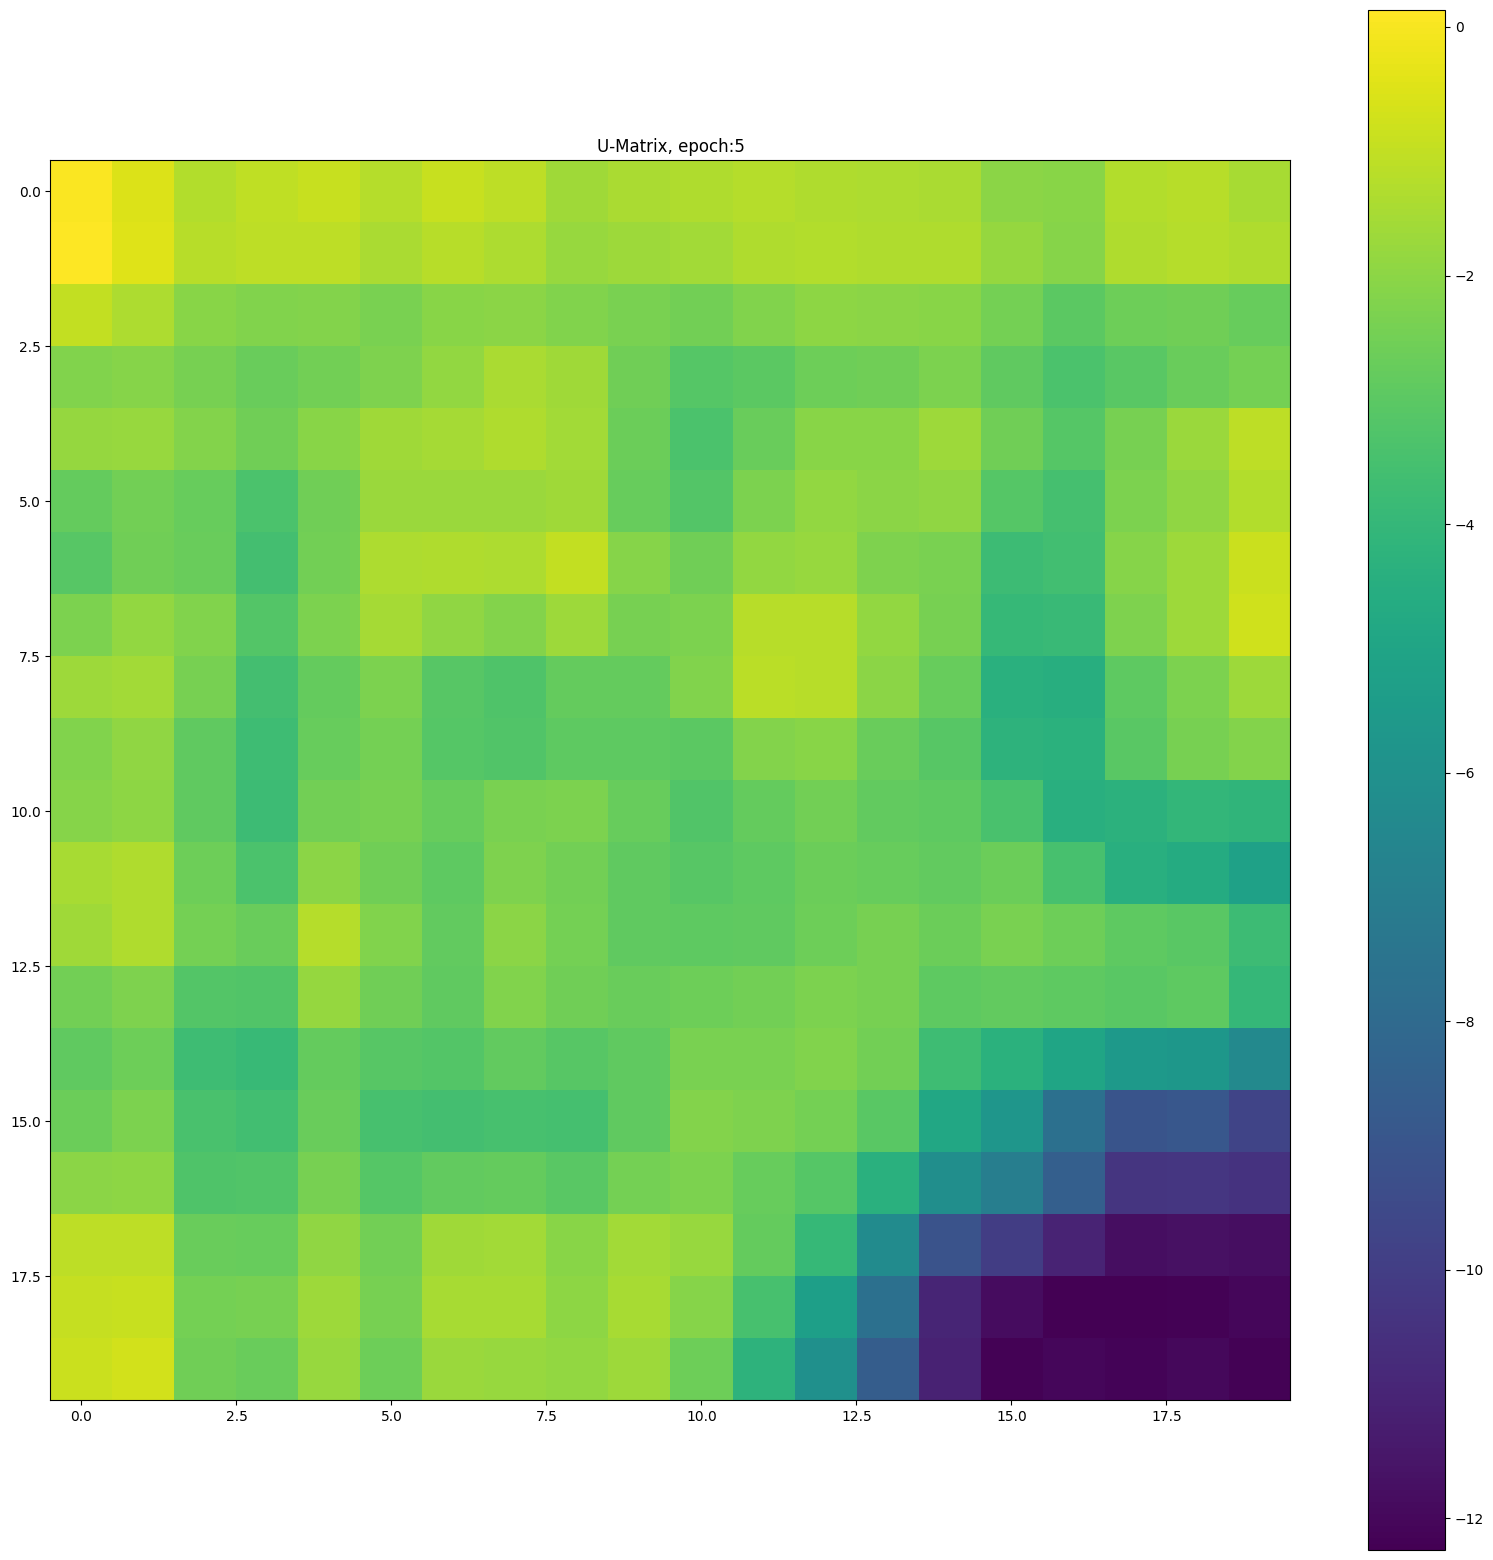

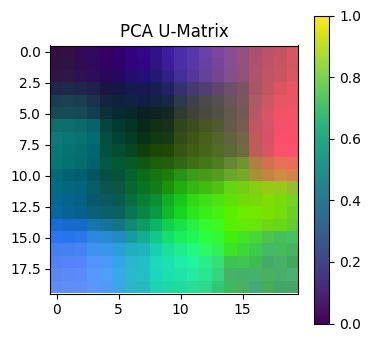

Epoch: 6, QE: 0.2393, TE: 0.3438


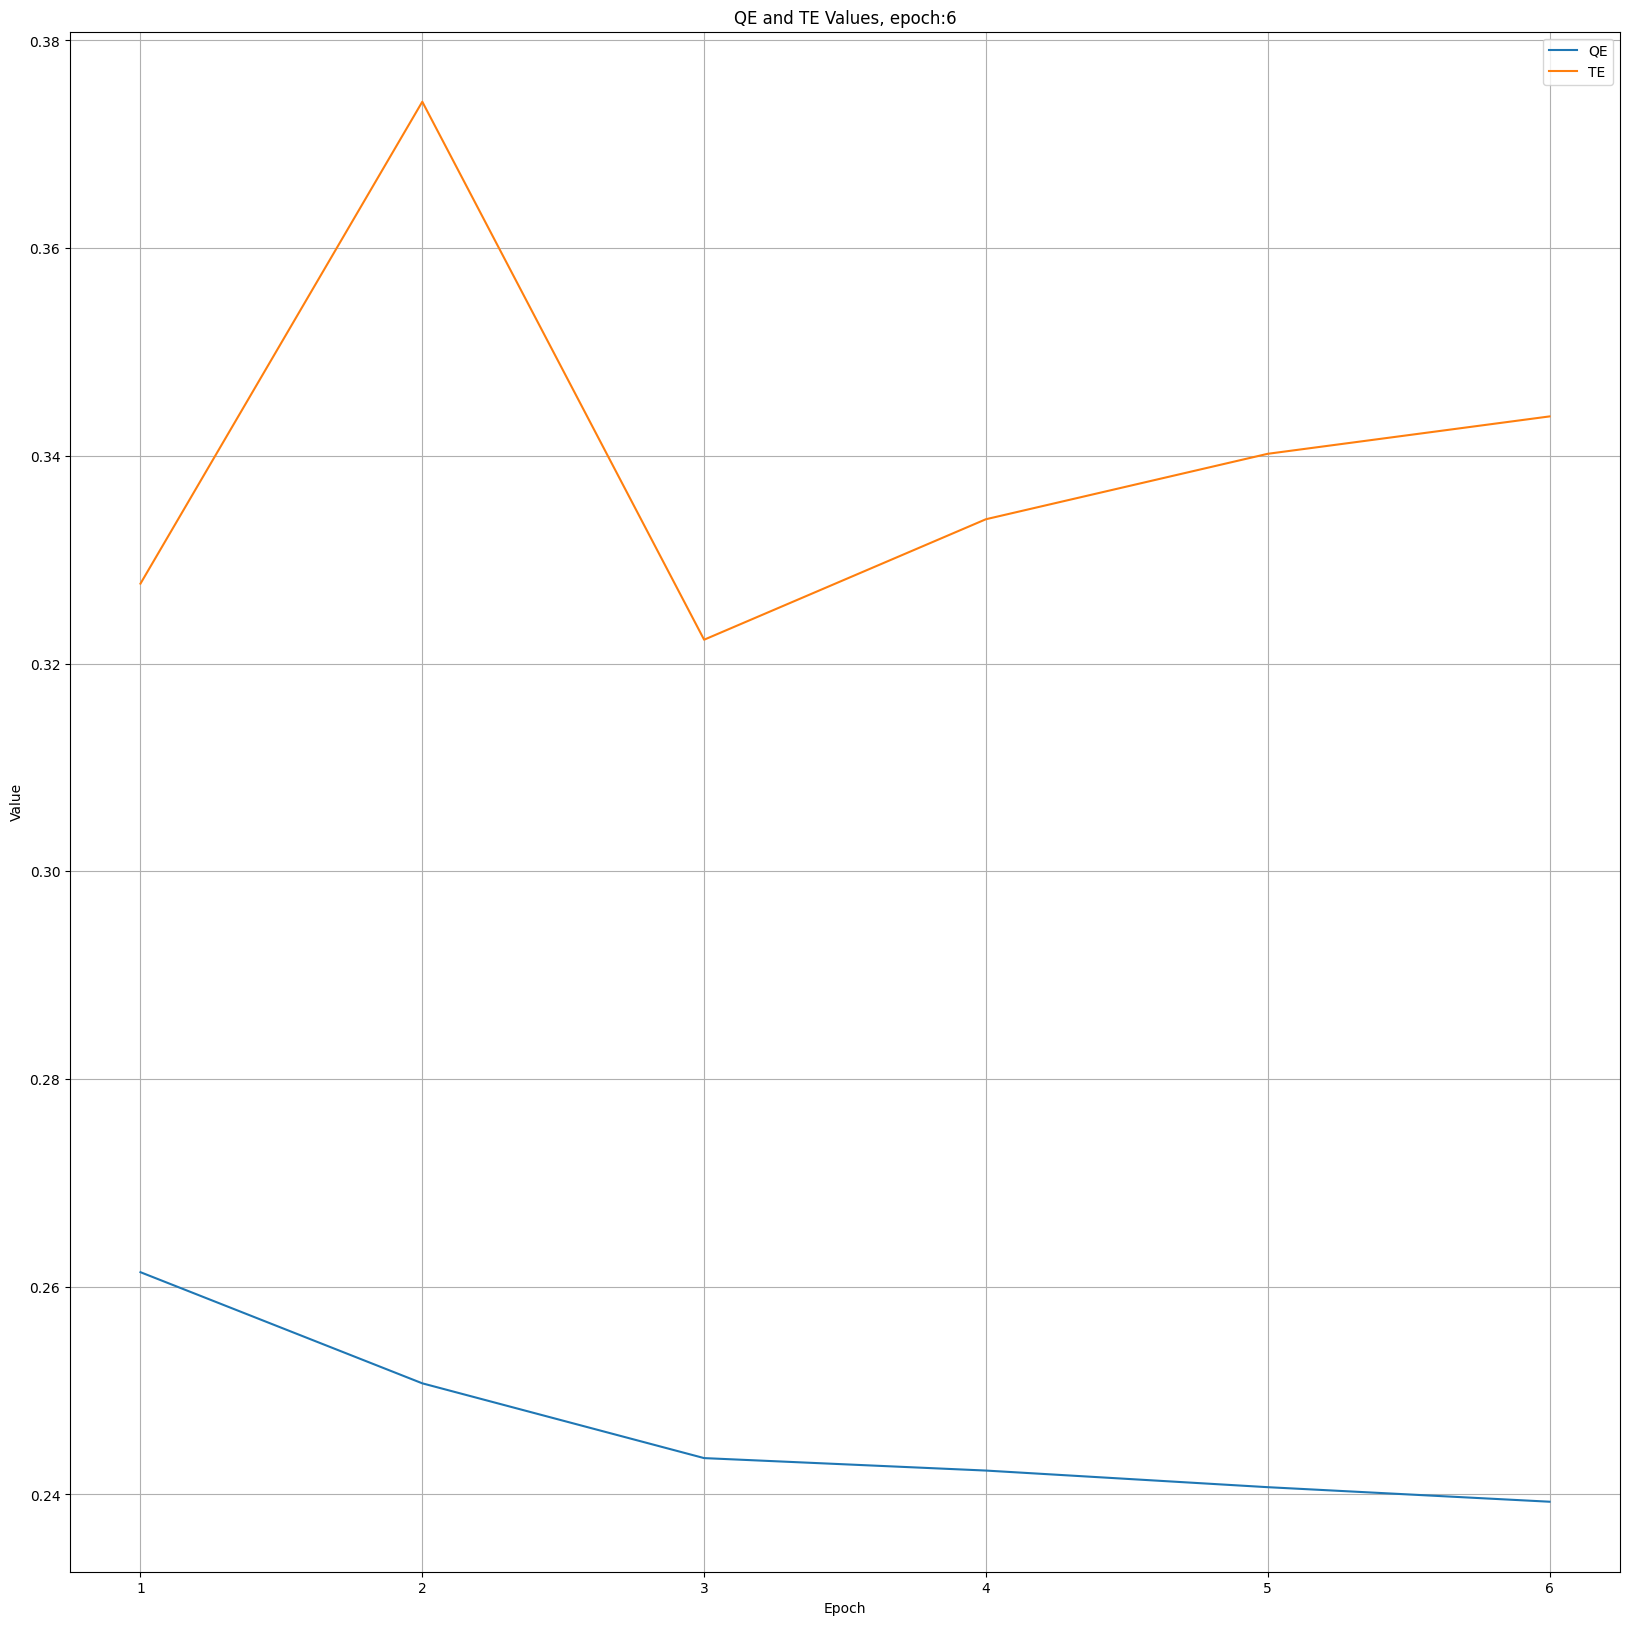

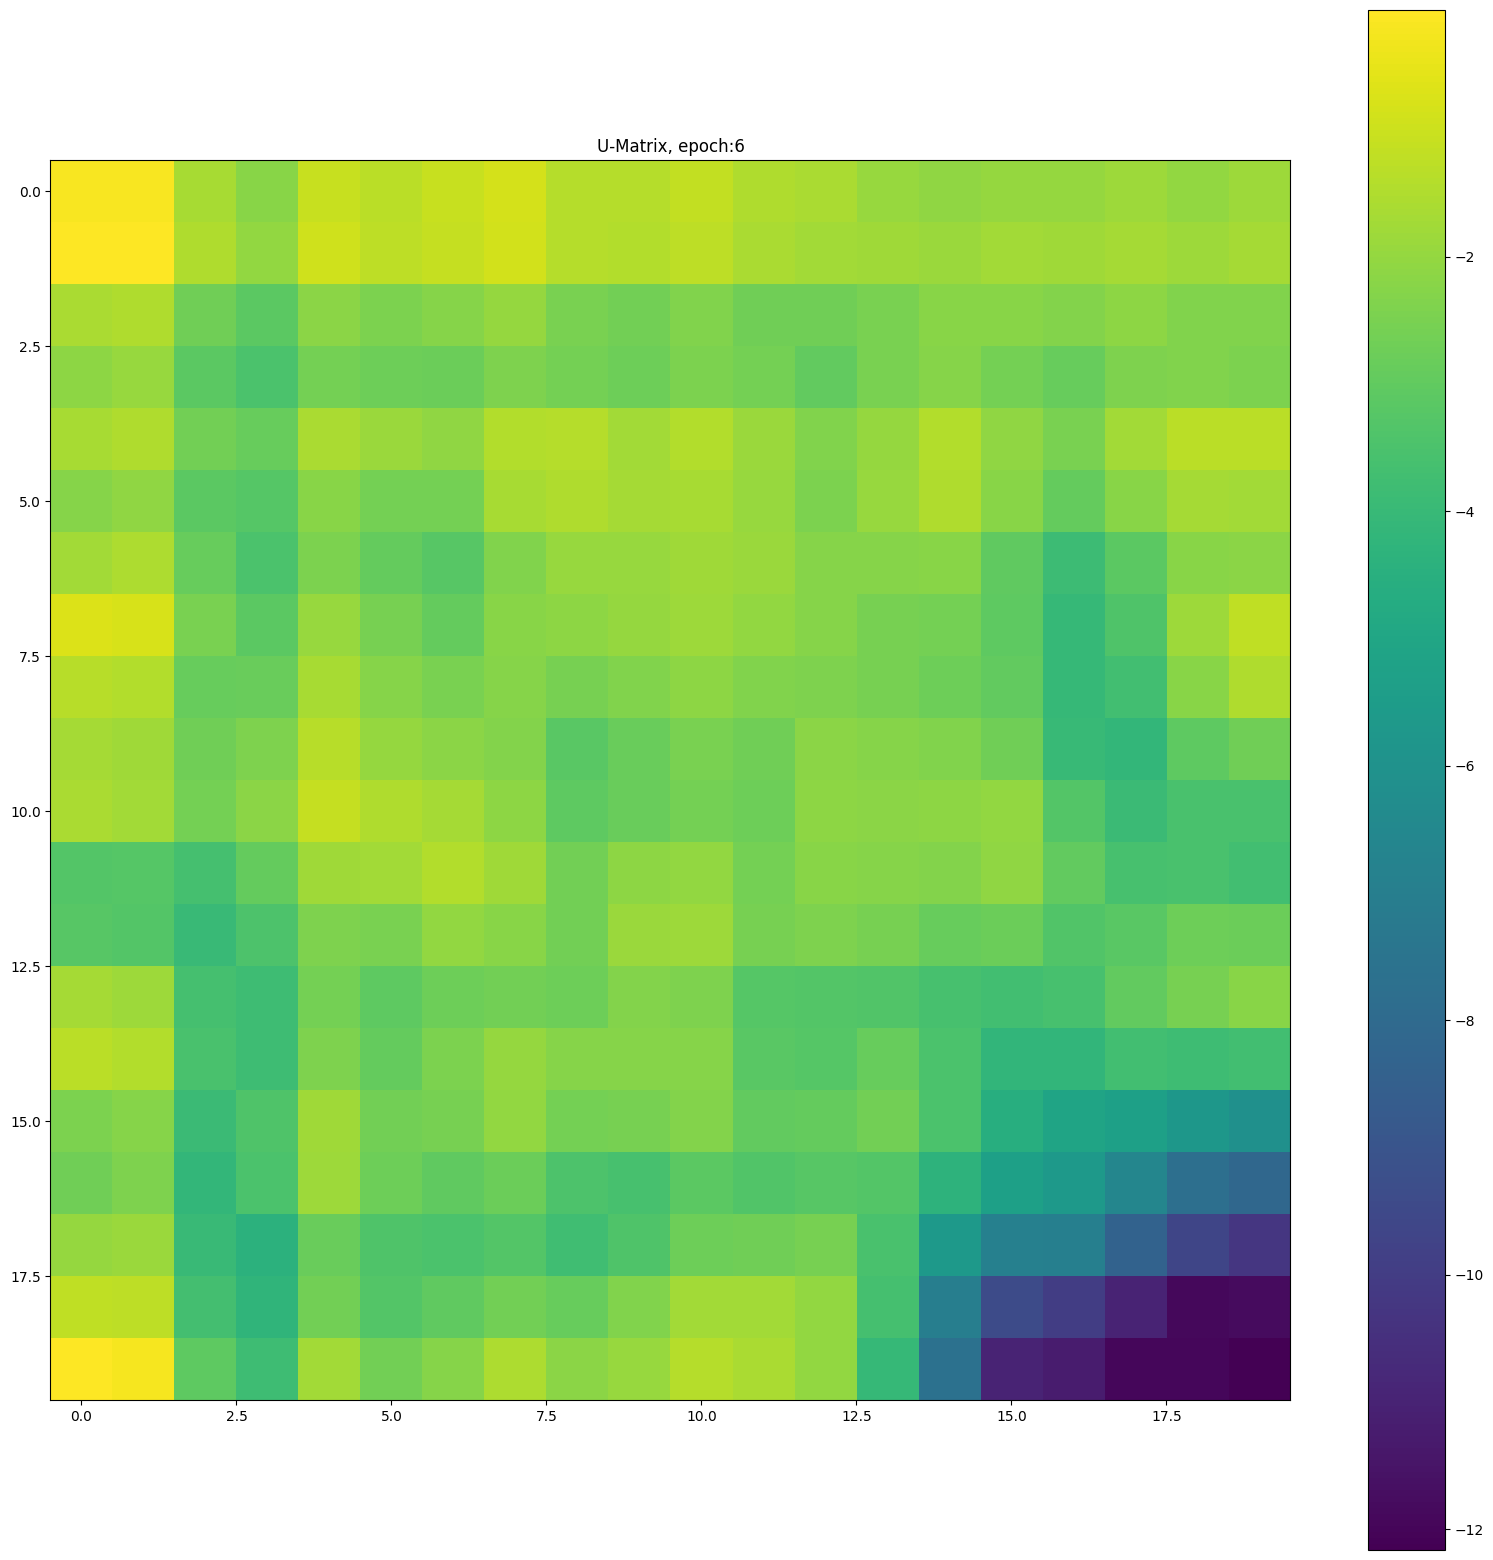

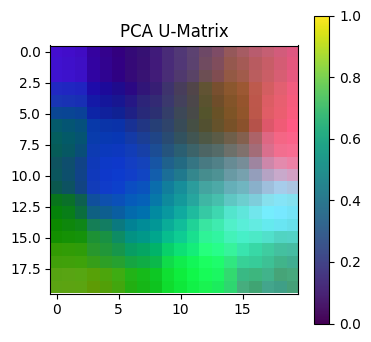

Epoch: 7, QE: 0.2388, TE: 0.3071


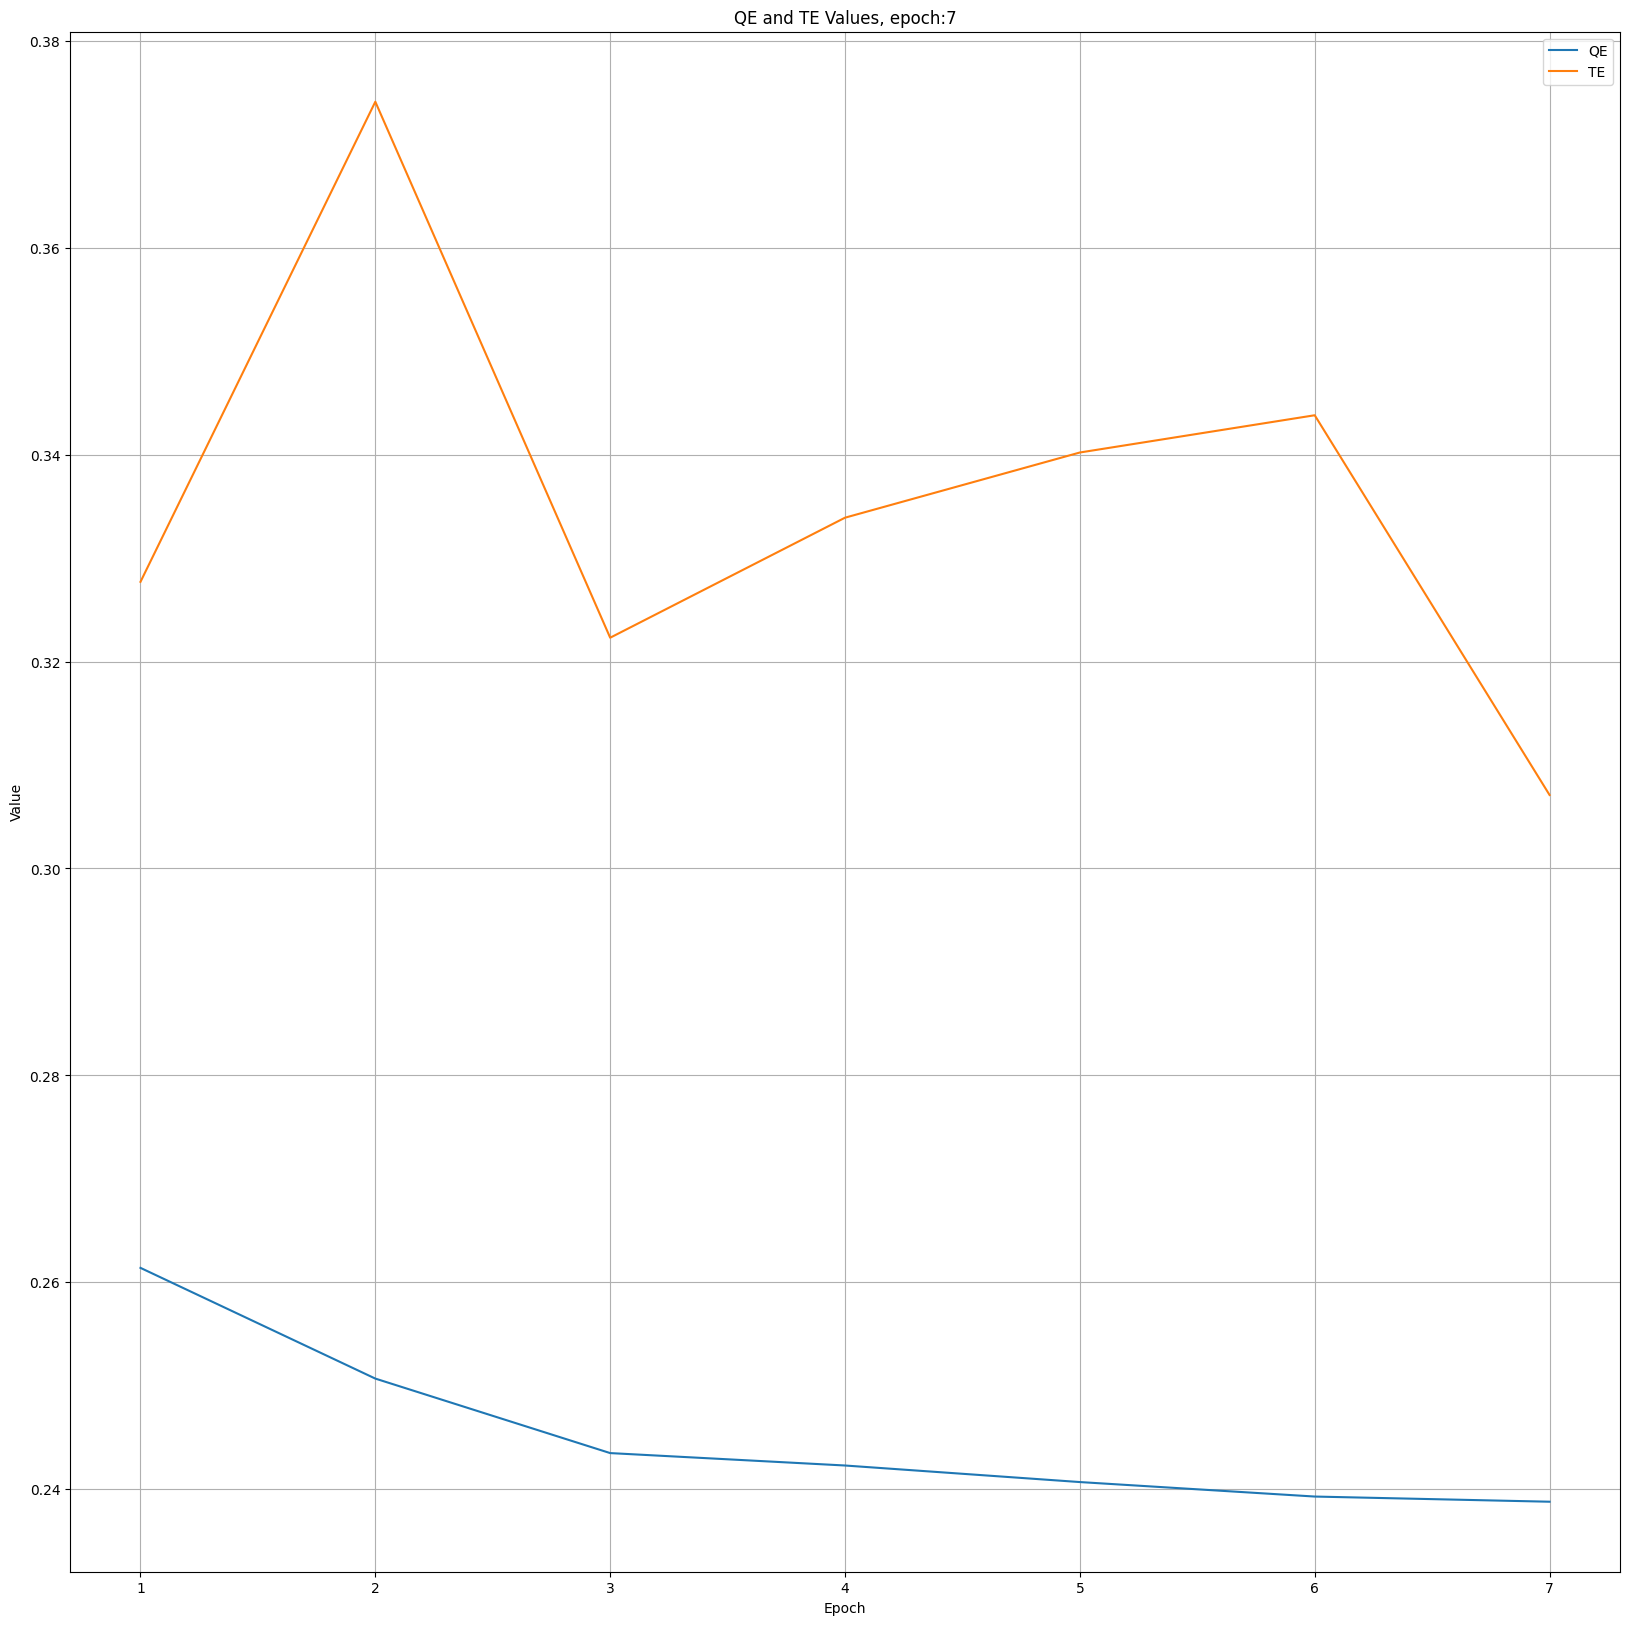

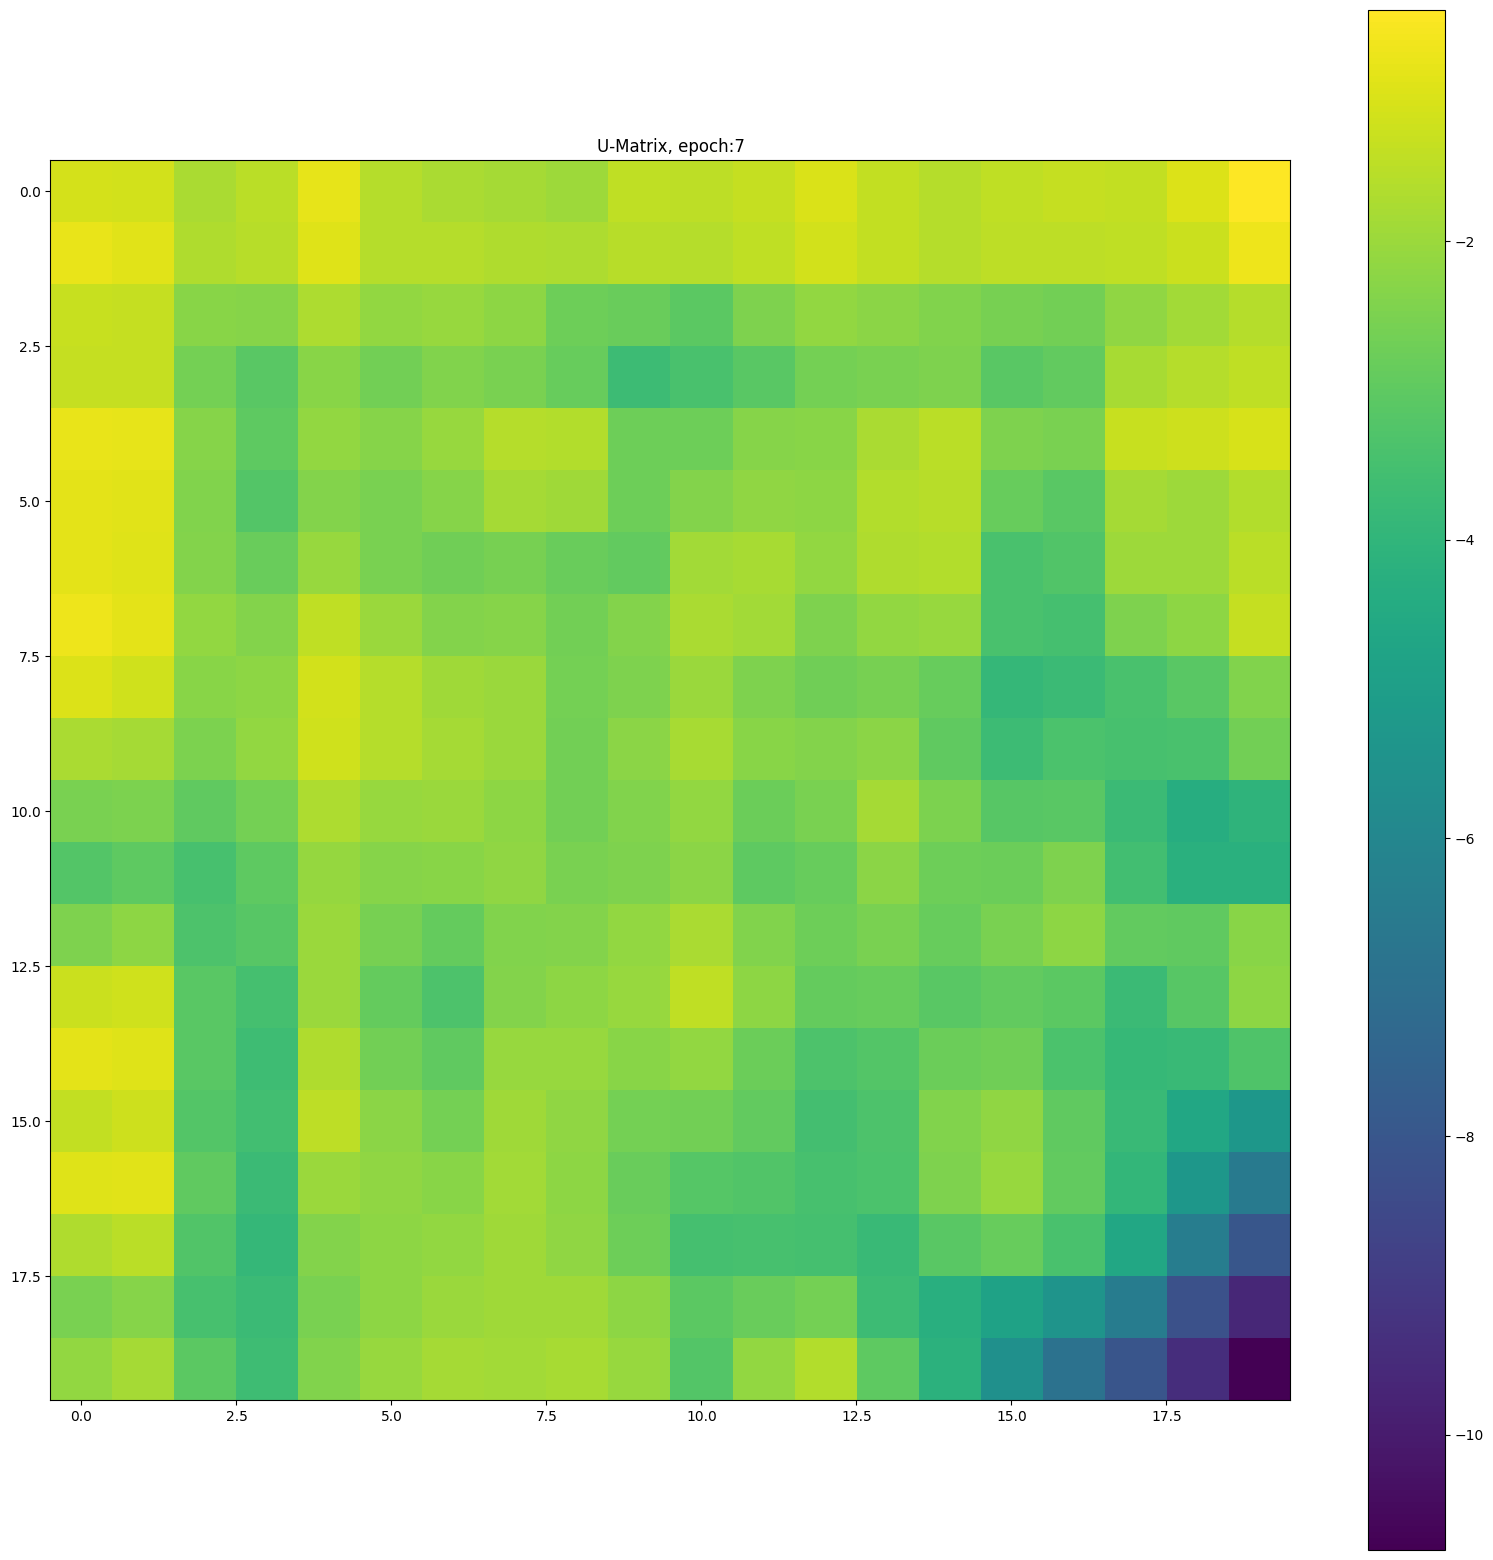

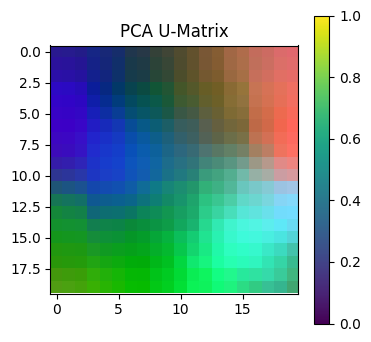

Epoch: 8, QE: 0.2378, TE: 0.3438


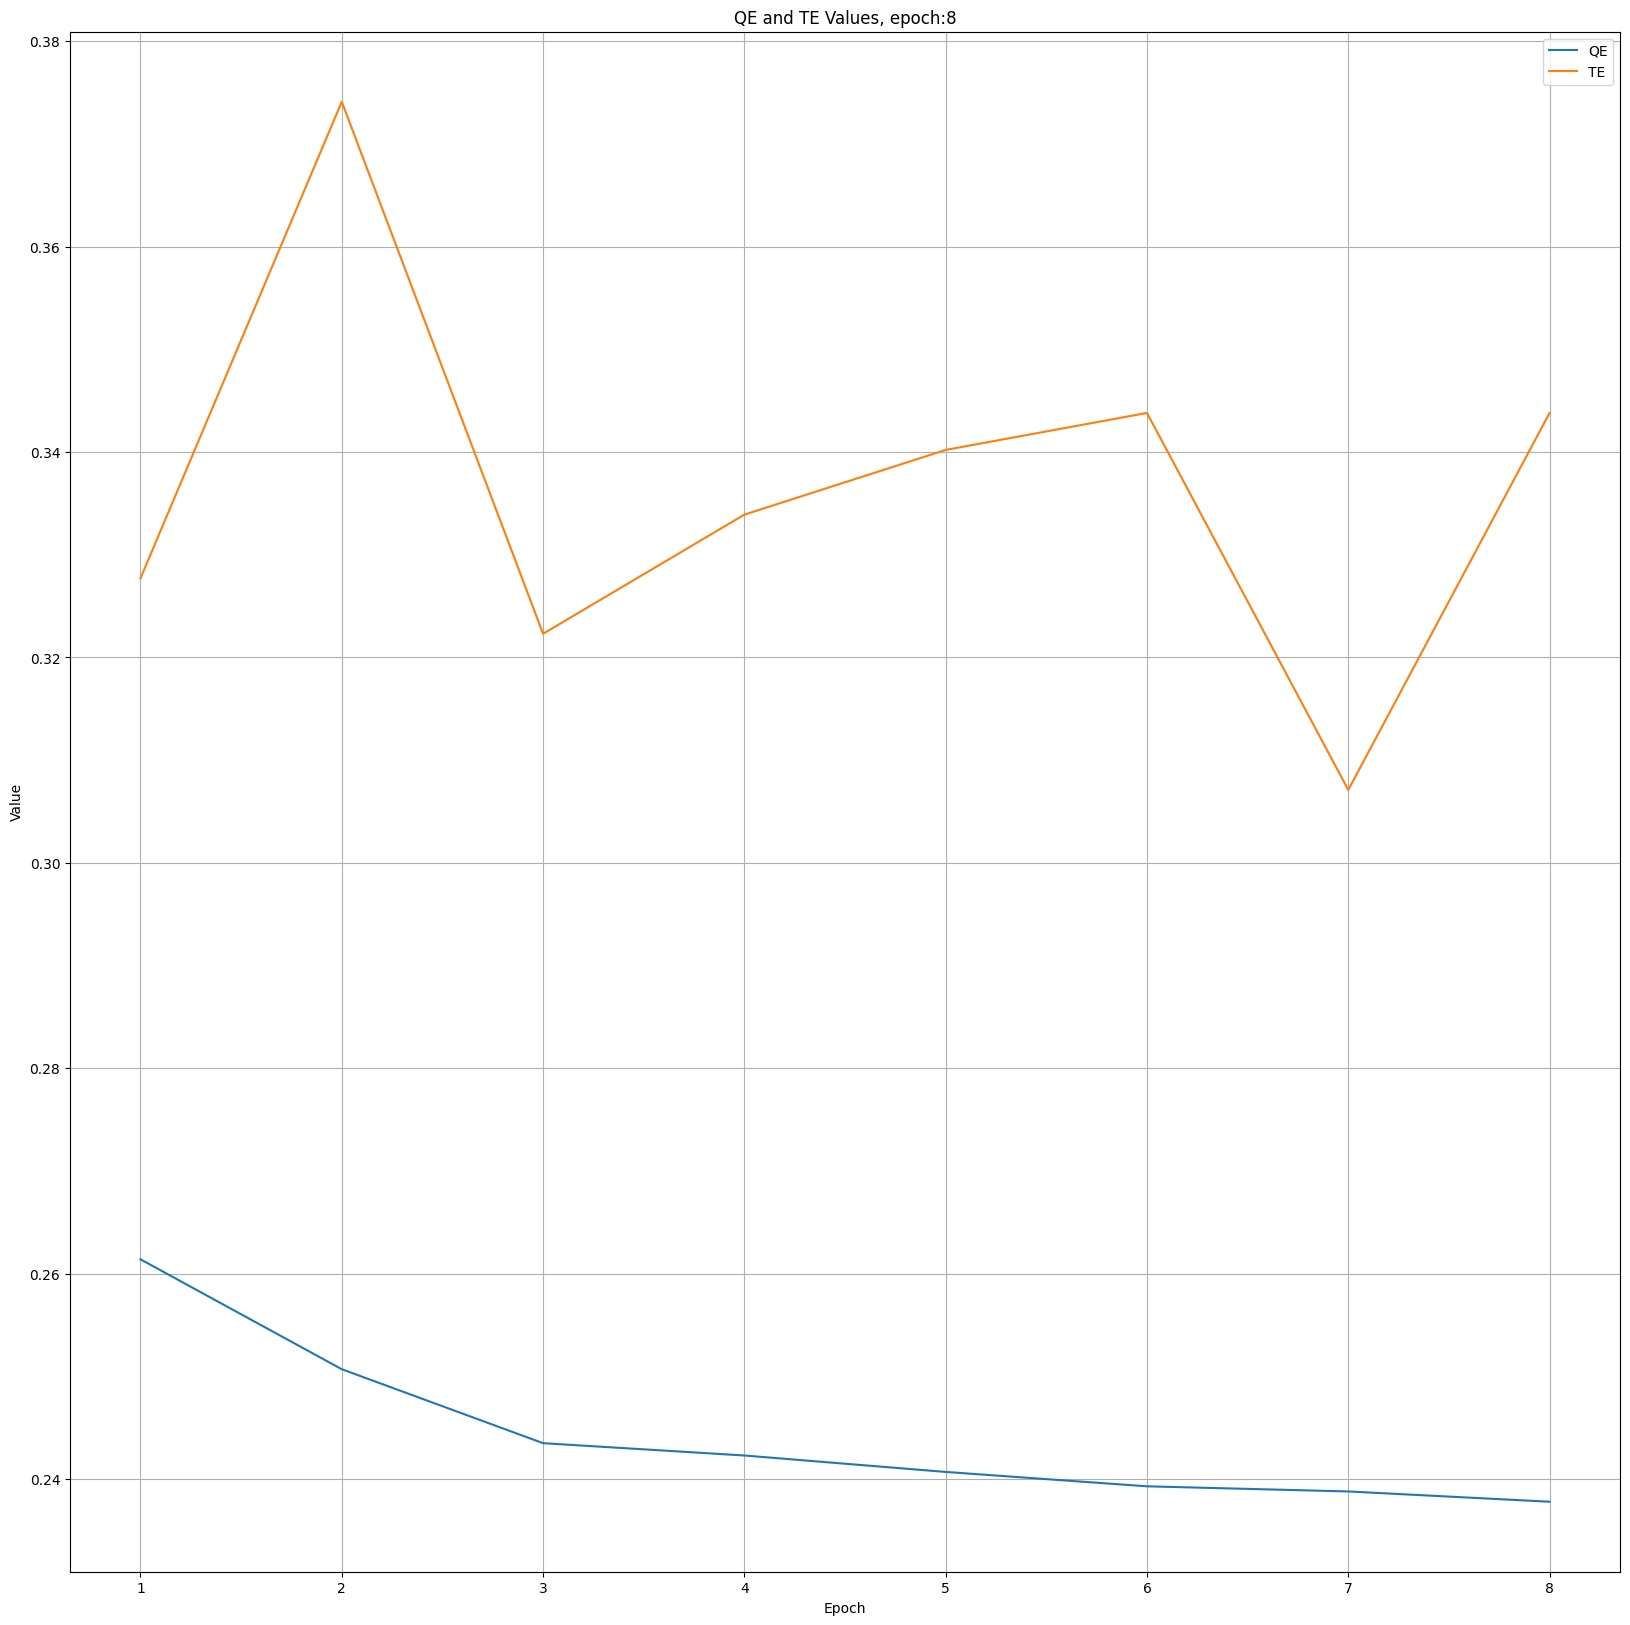

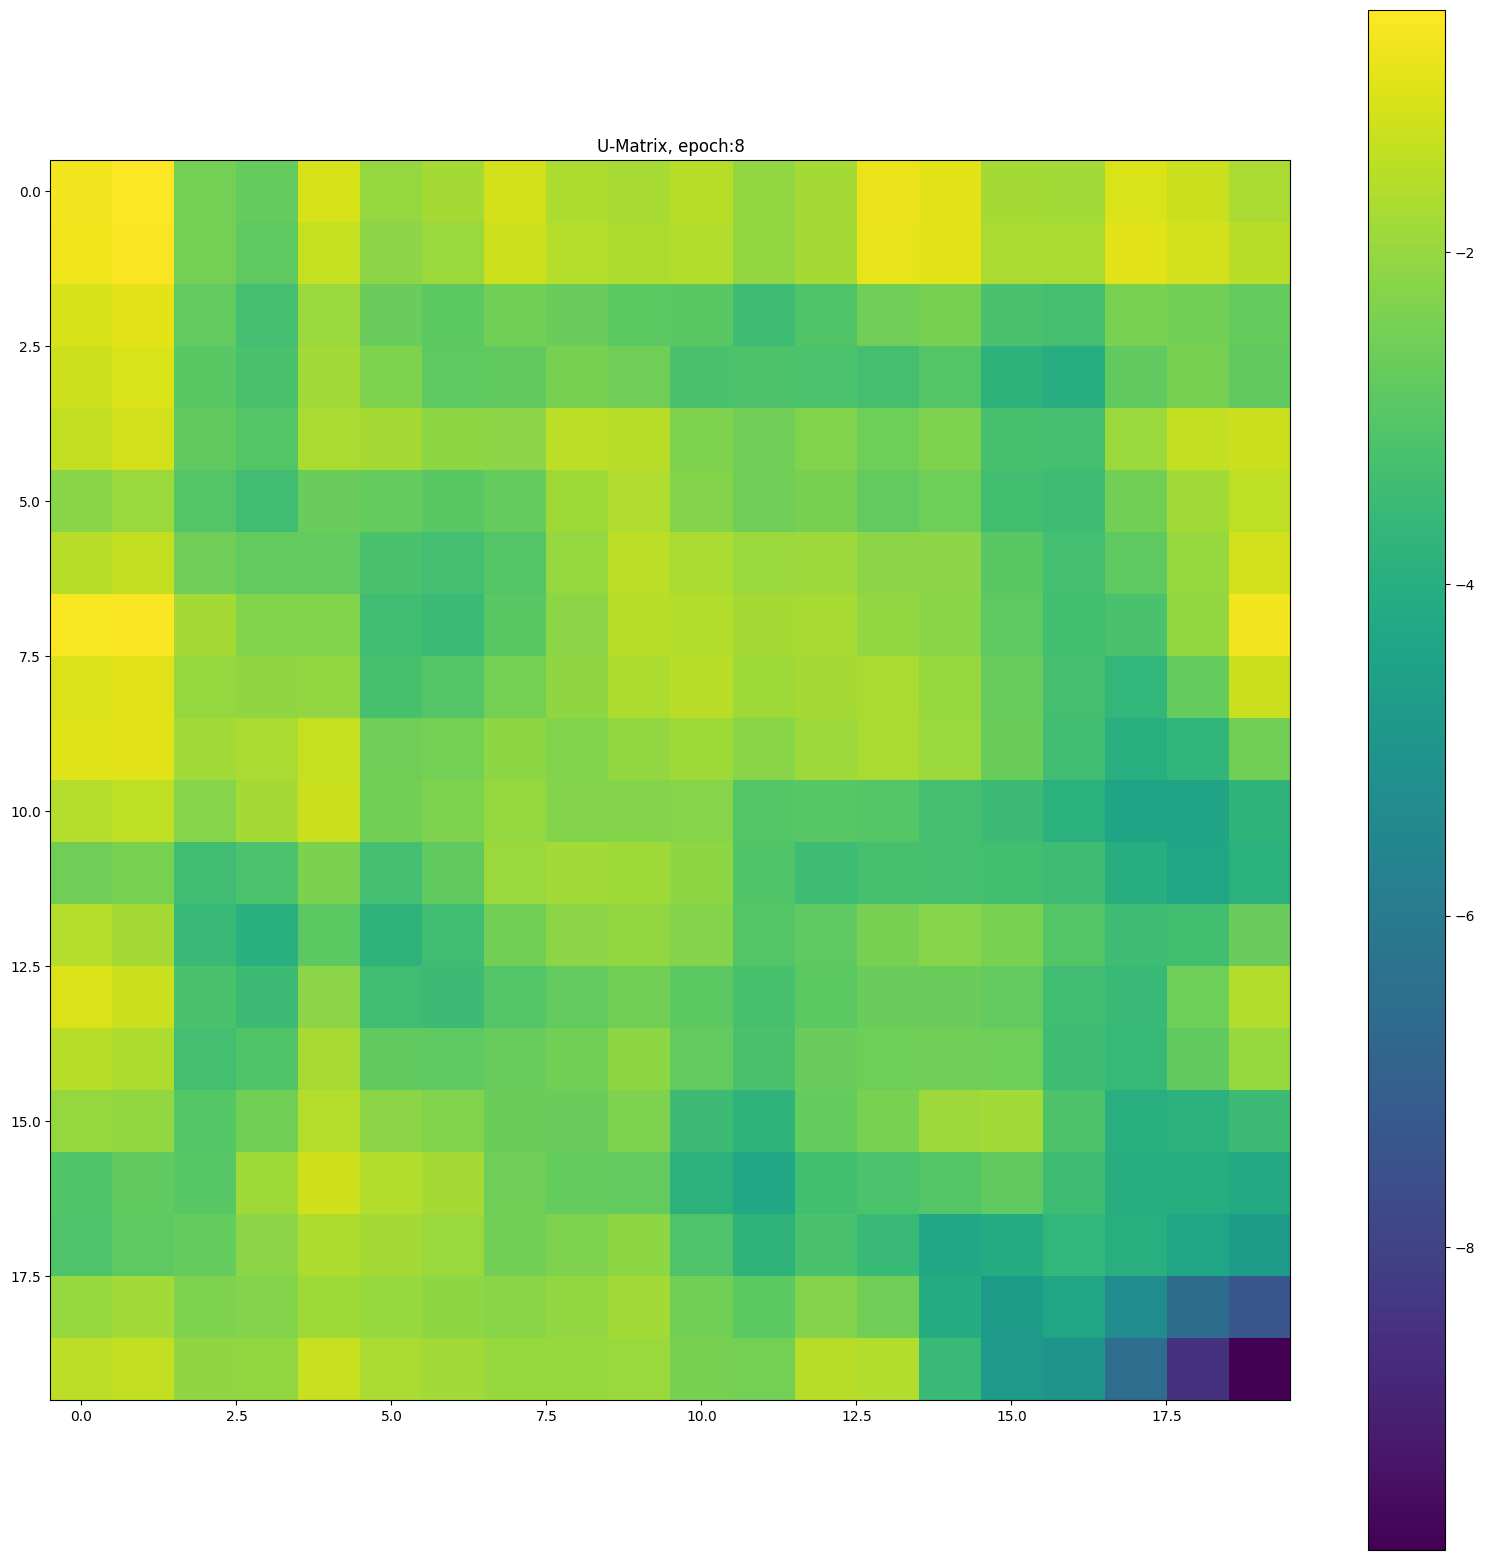

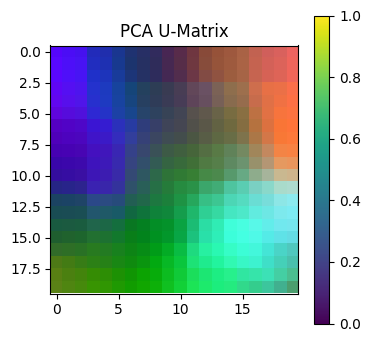

Epoch: 9, QE: 0.2374, TE: 0.3411


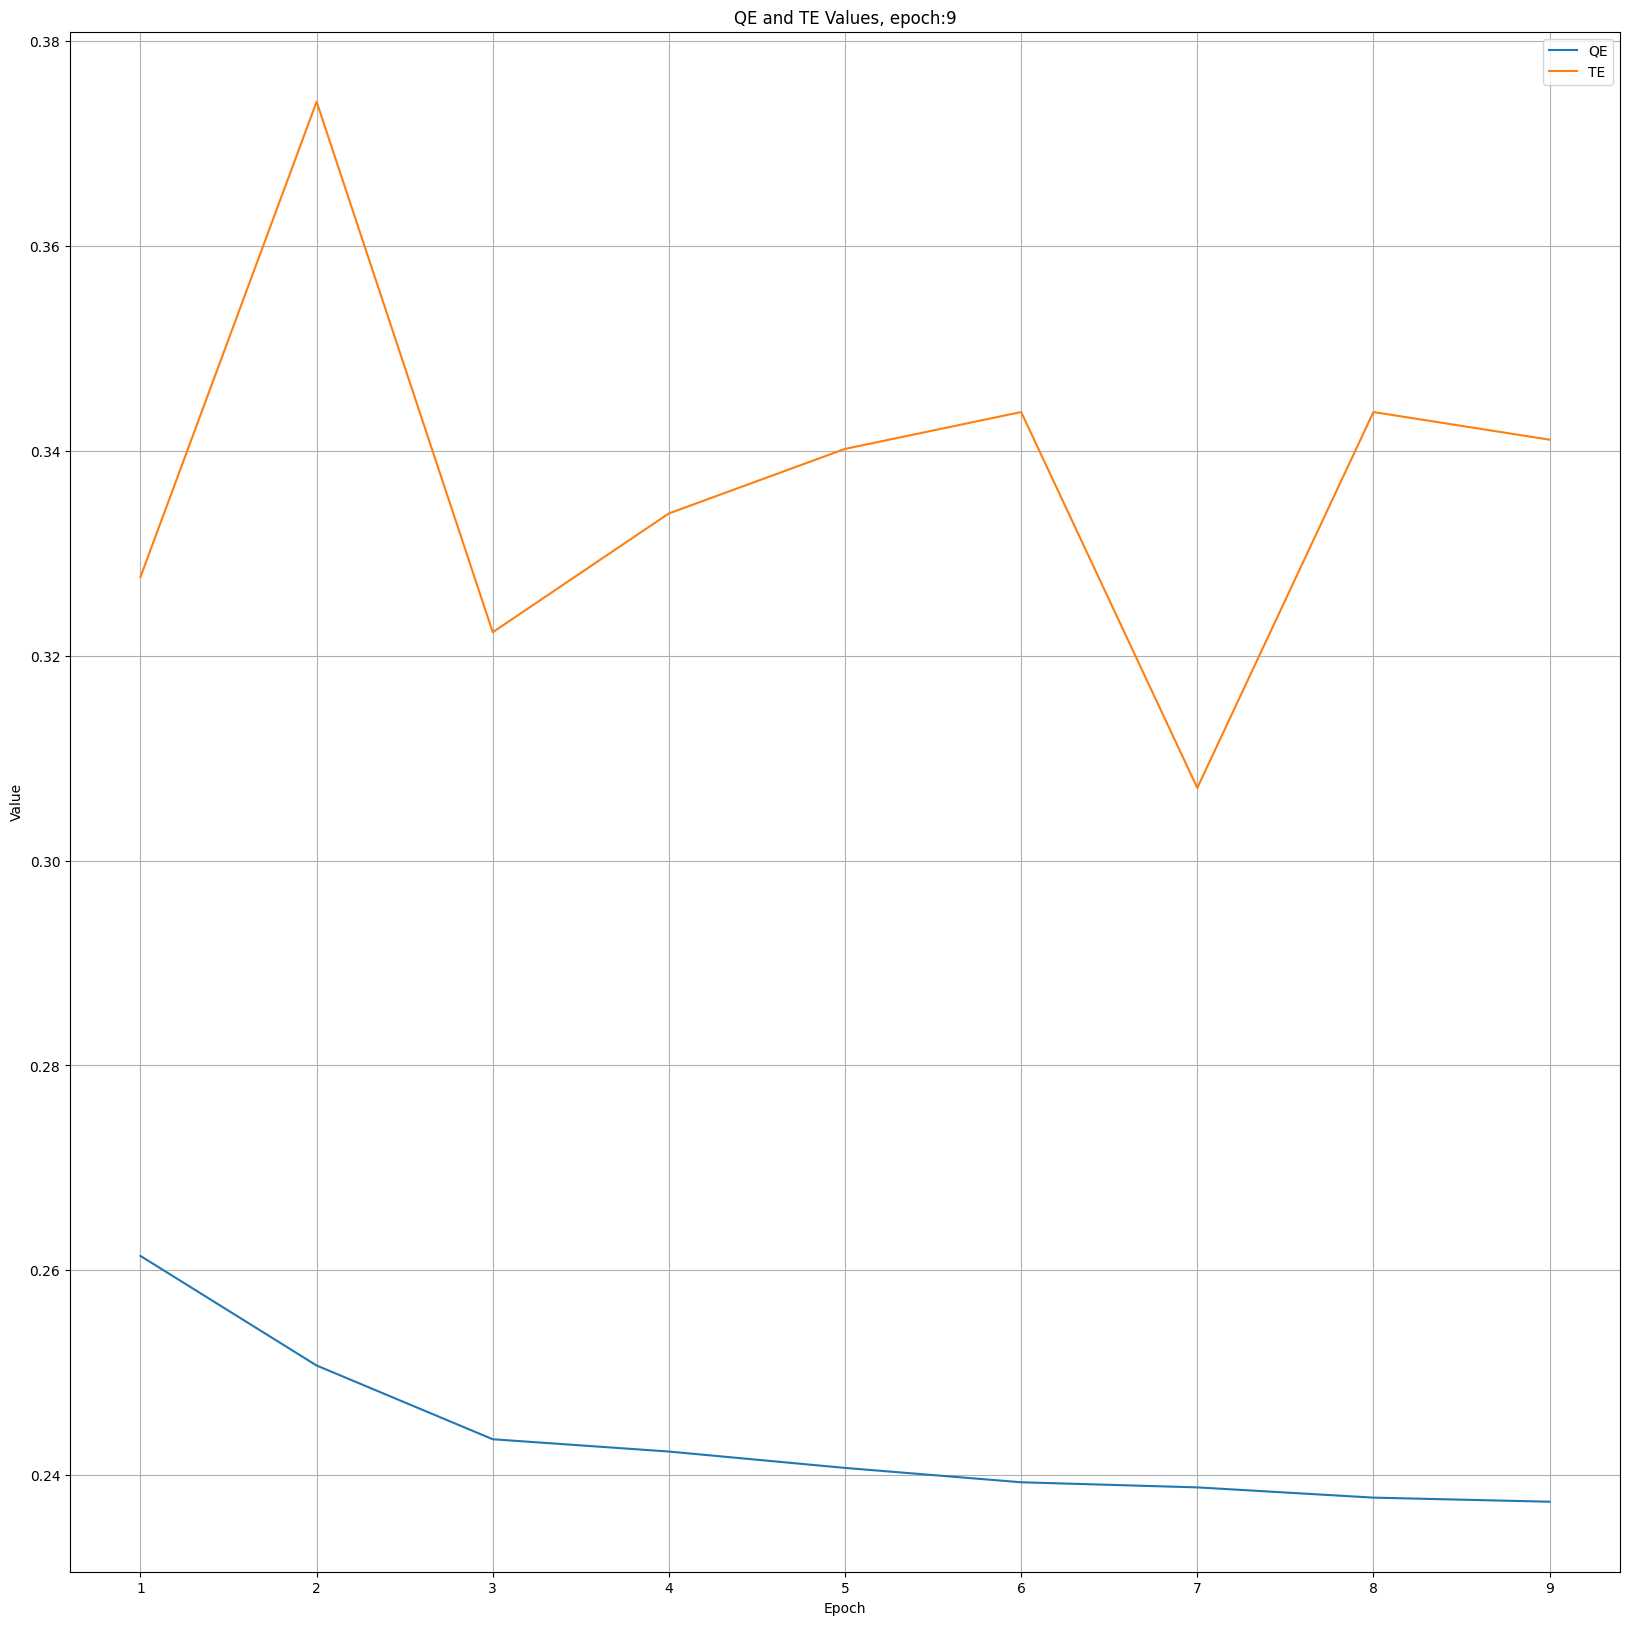

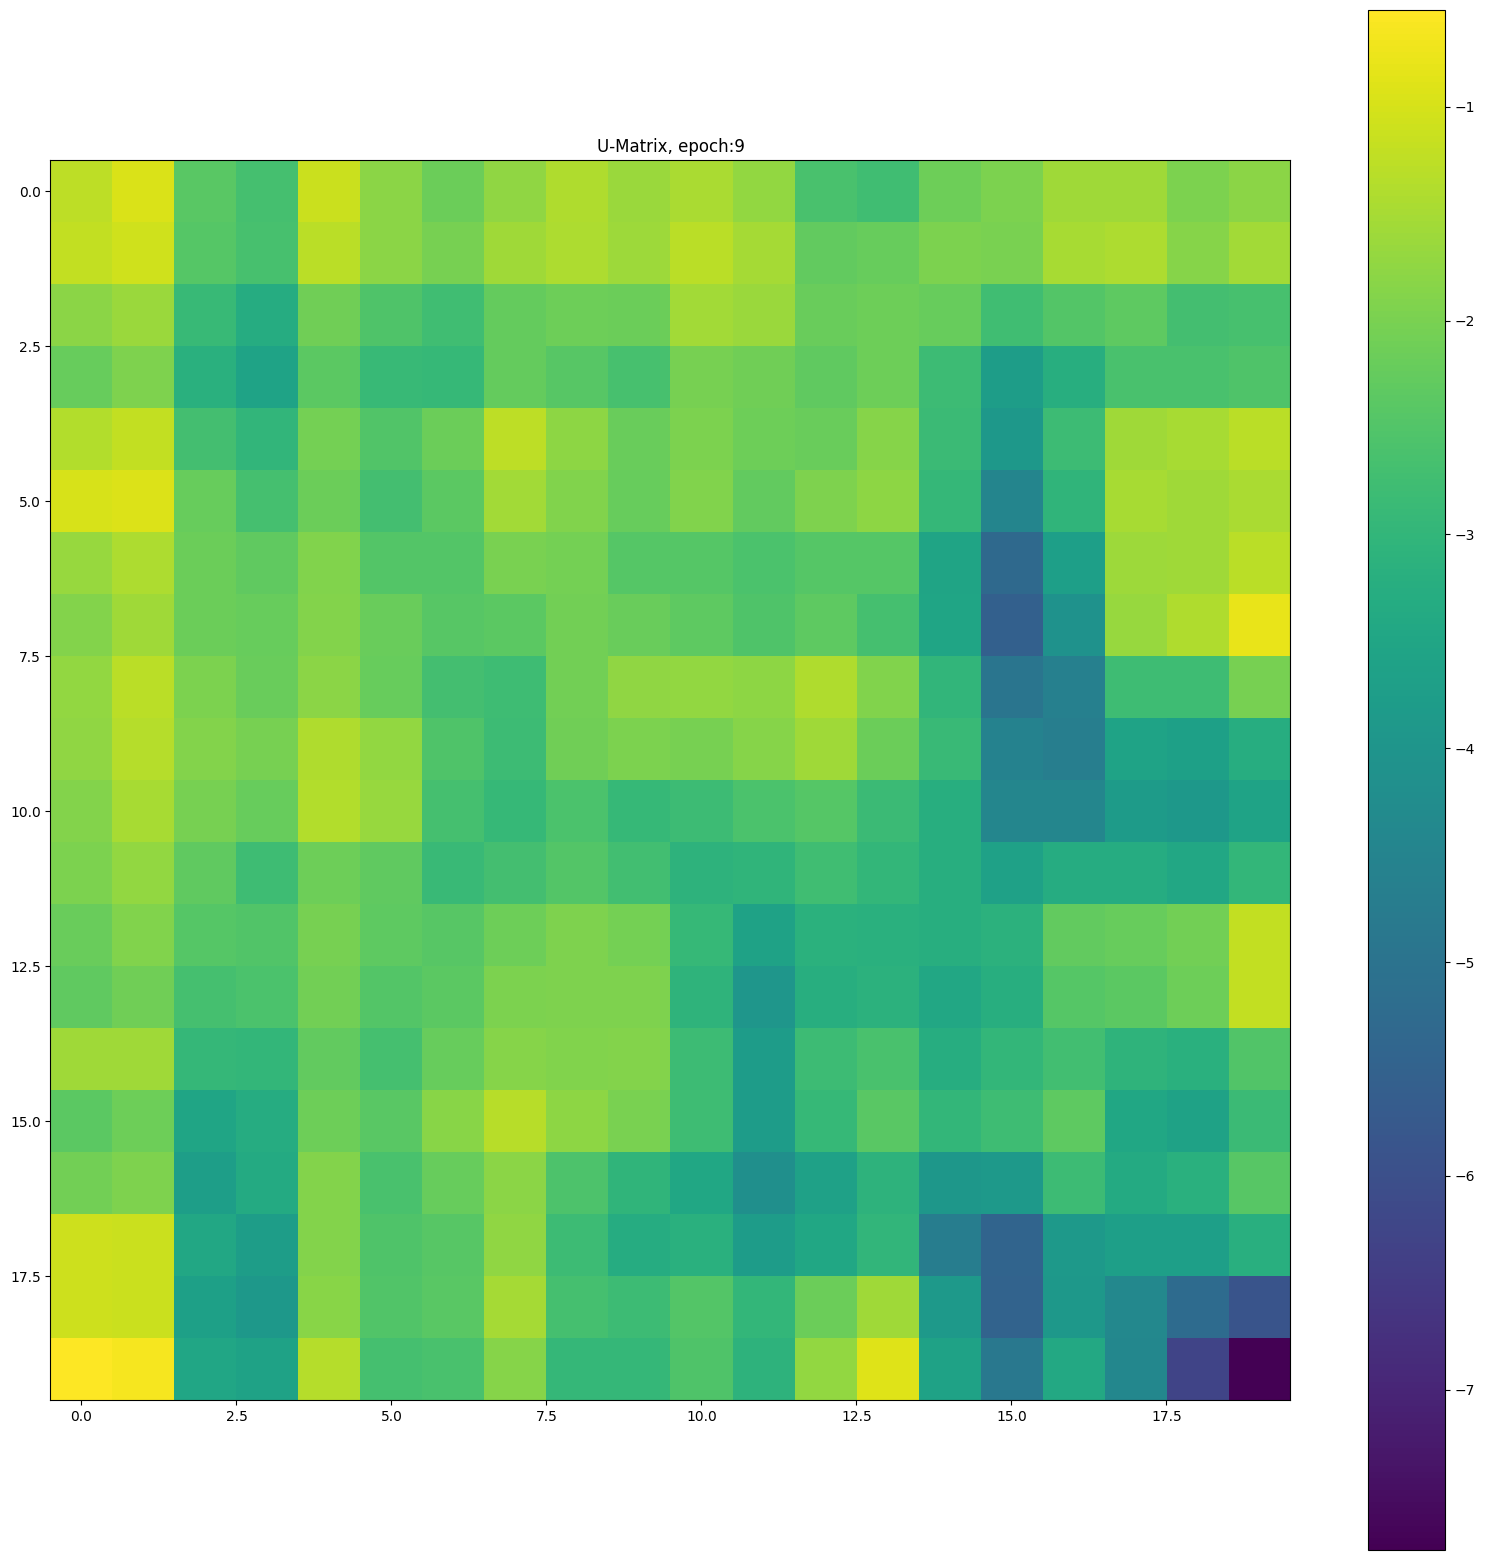

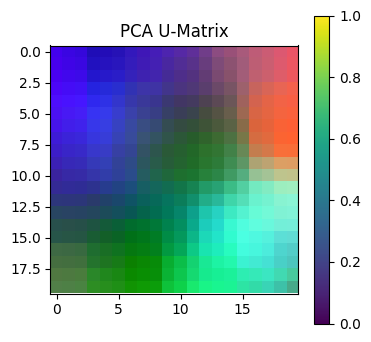

Epoch: 10, QE: 0.2387, TE: 0.3366


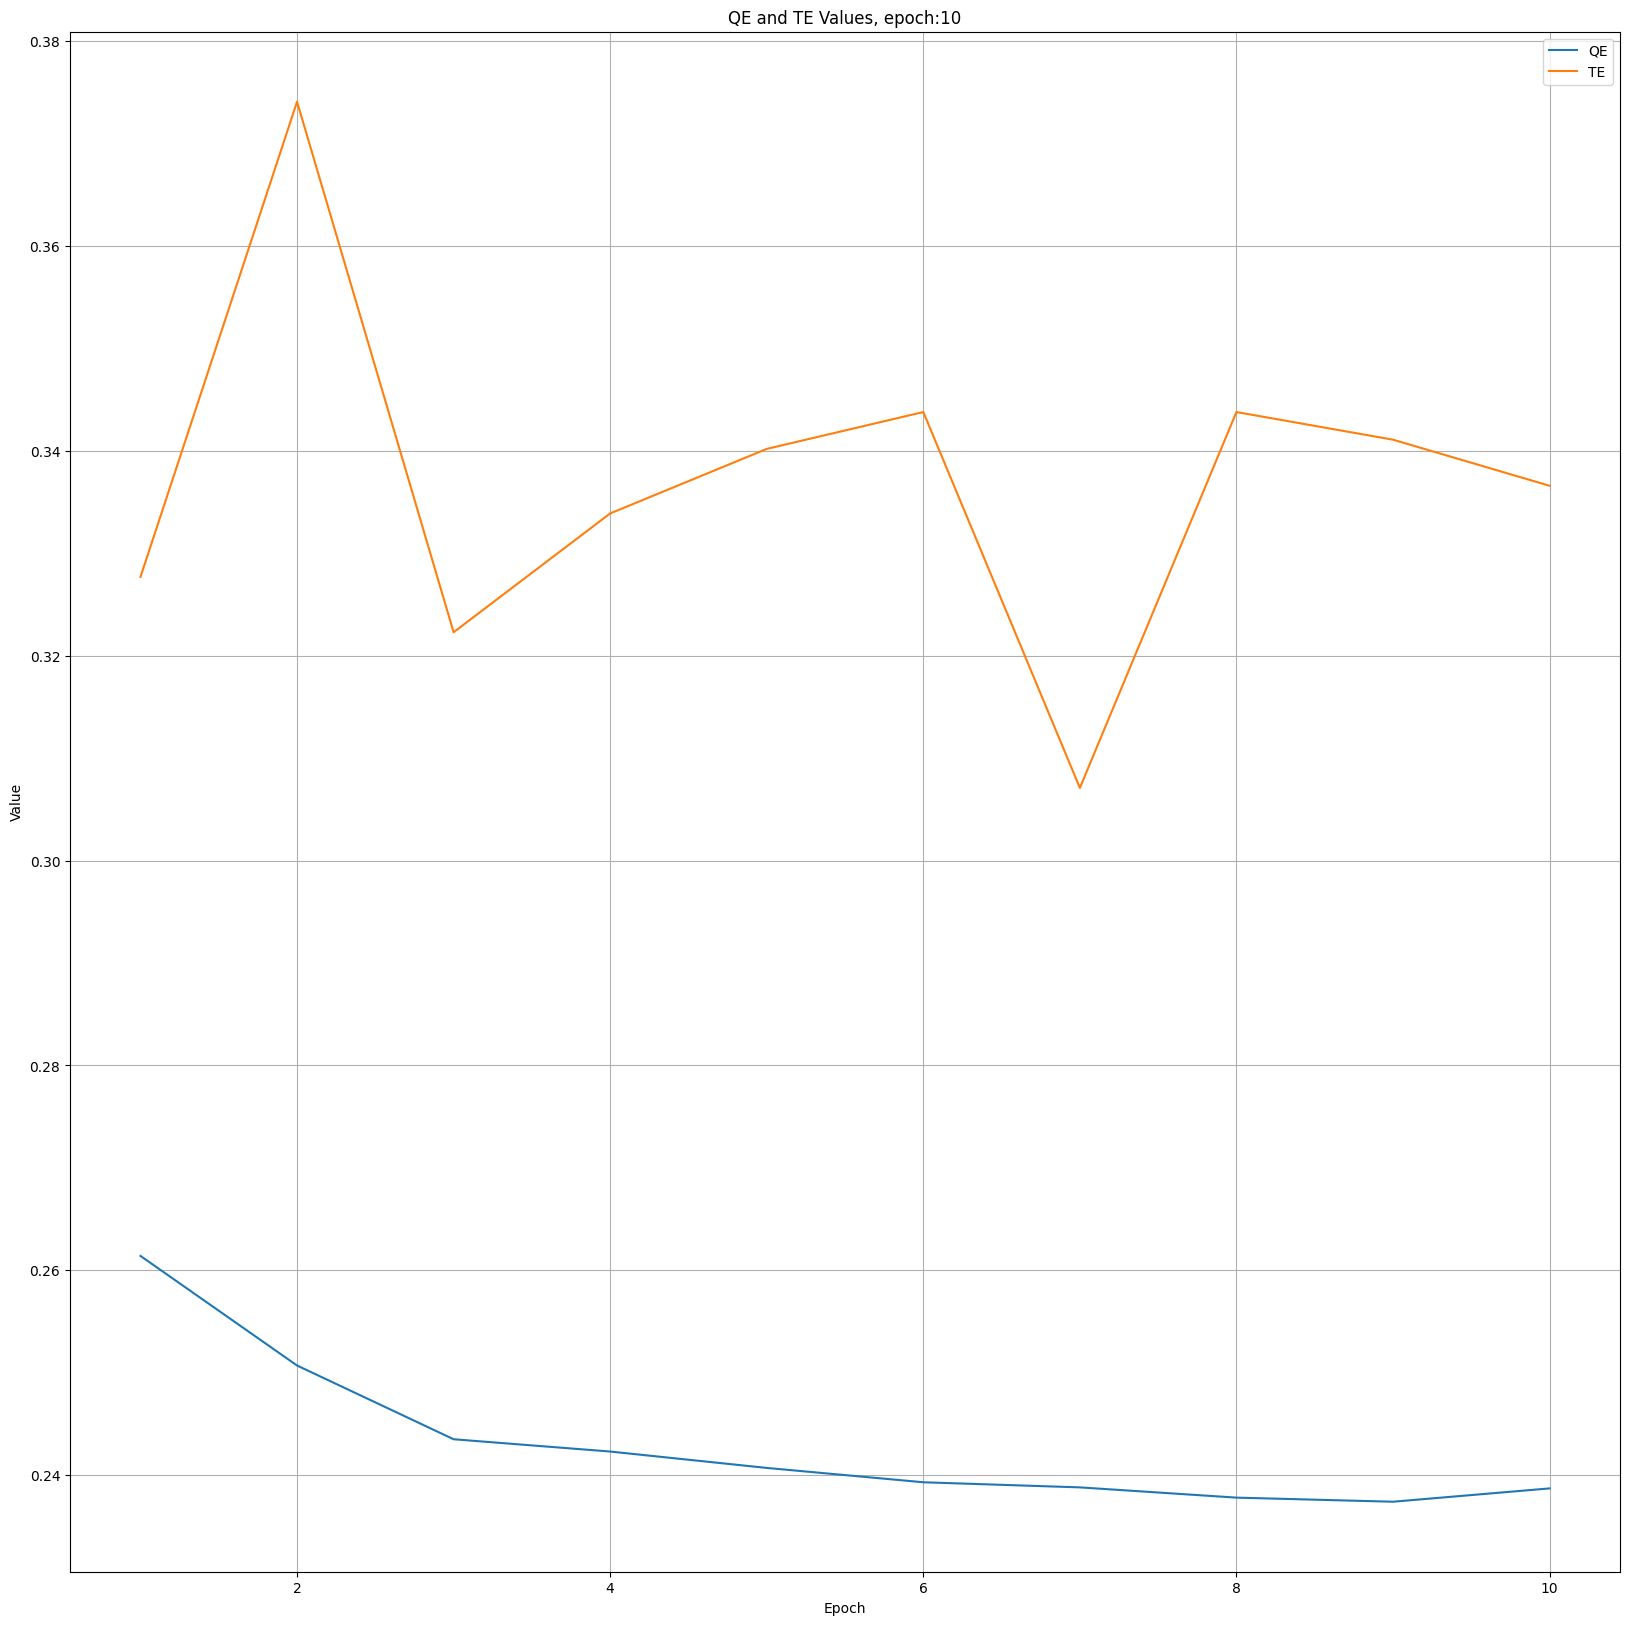

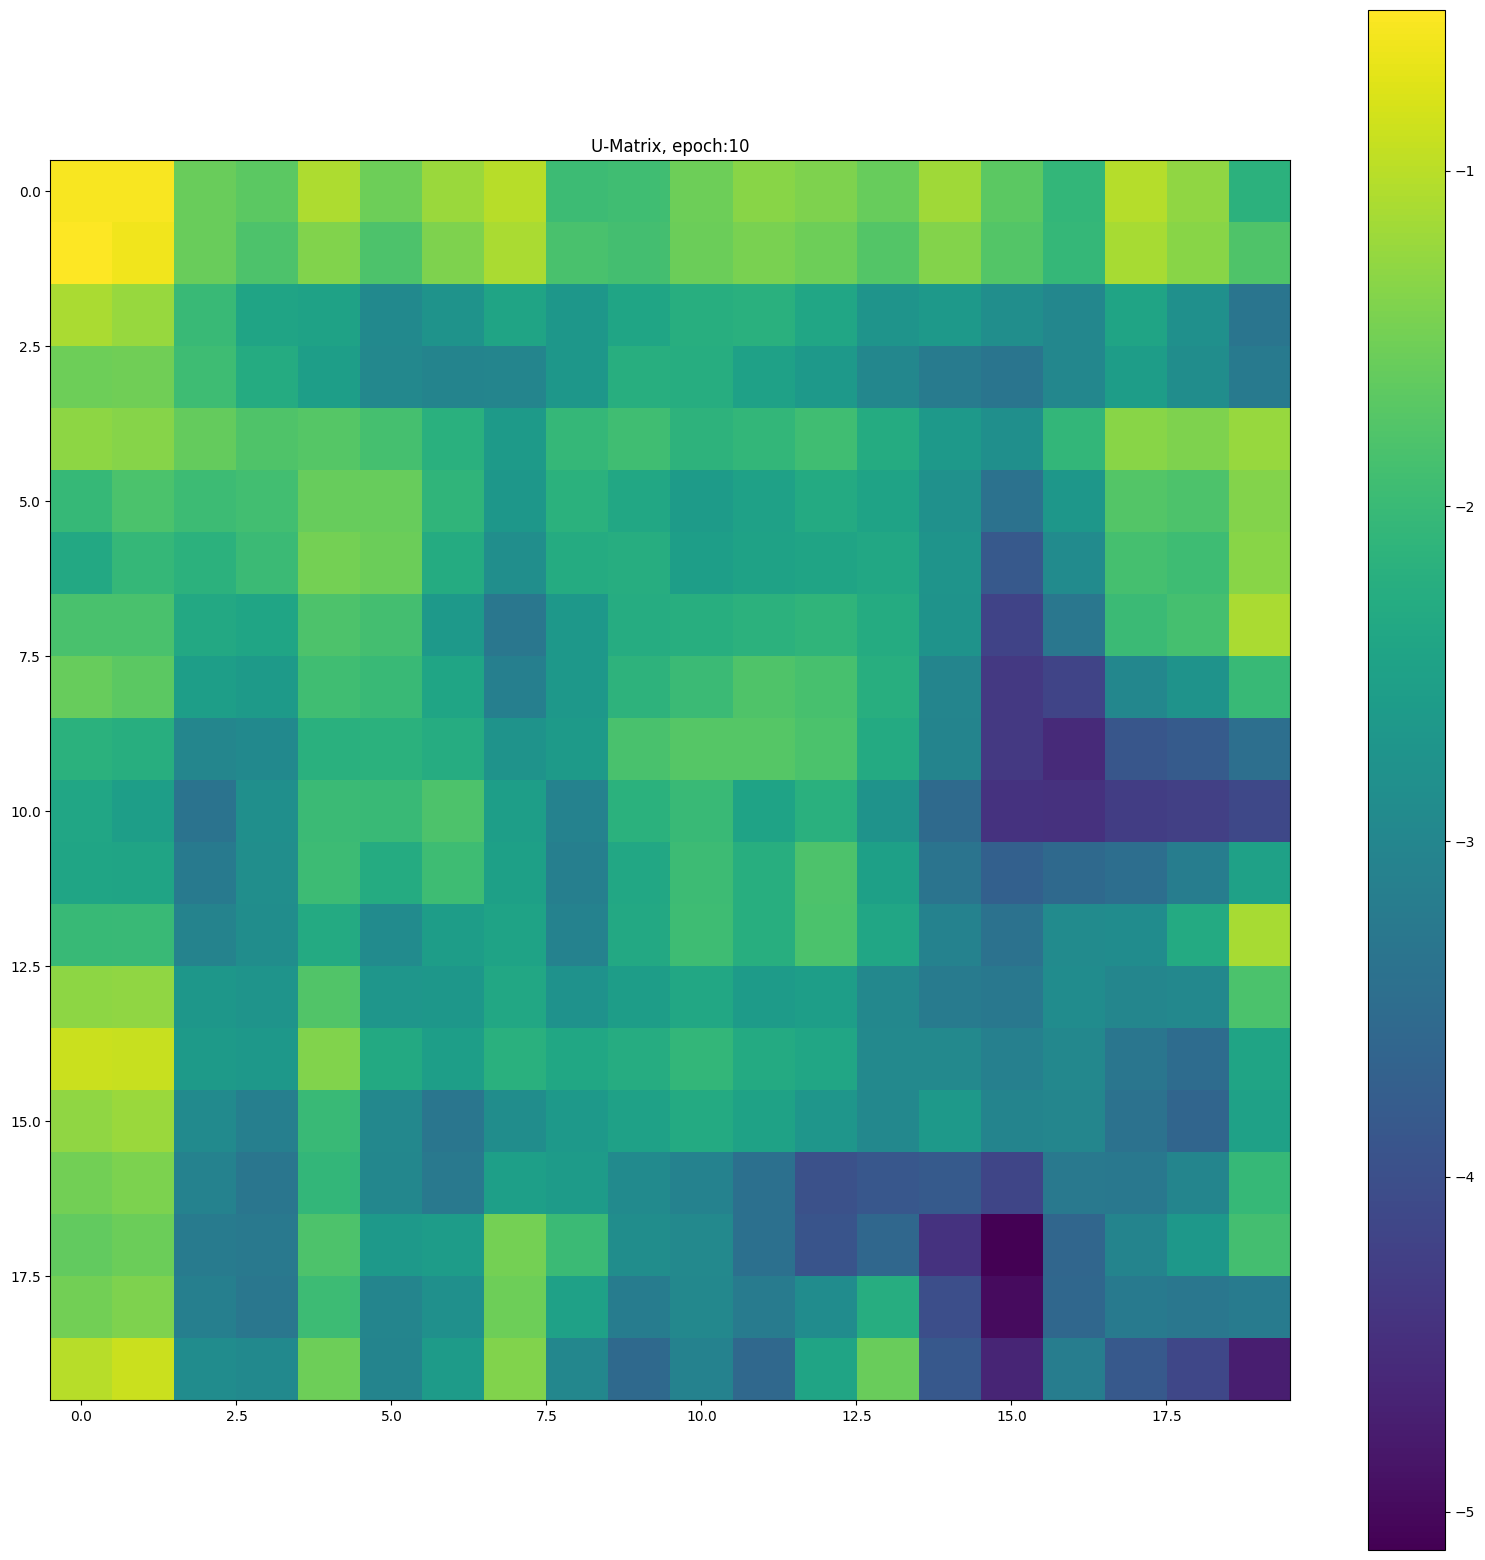

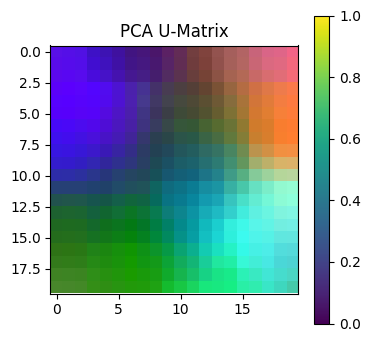

Epoch: 11, QE: 0.2392, TE: 0.3393


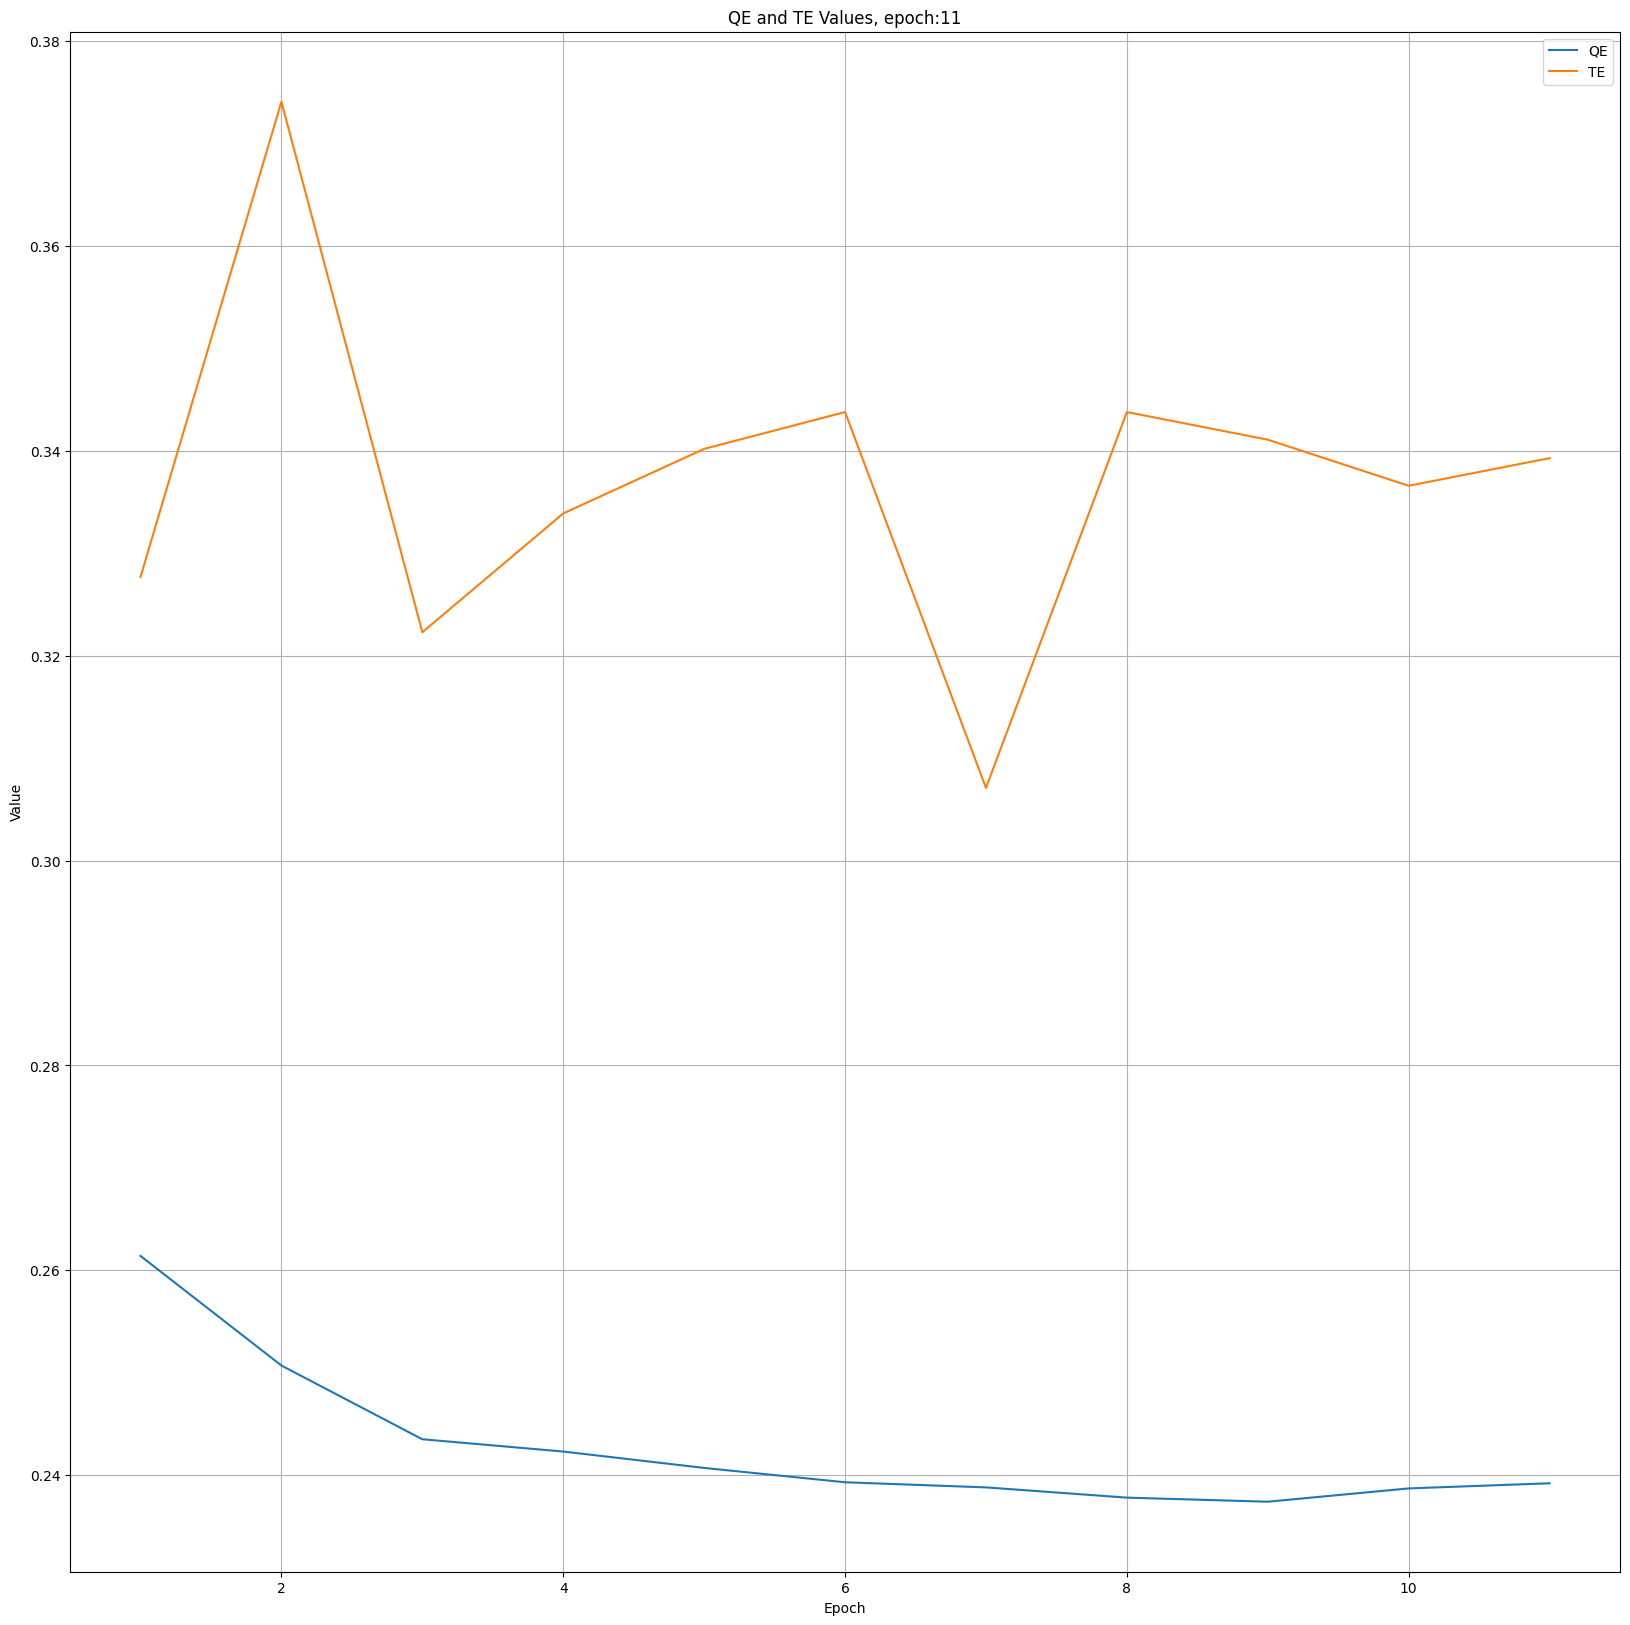

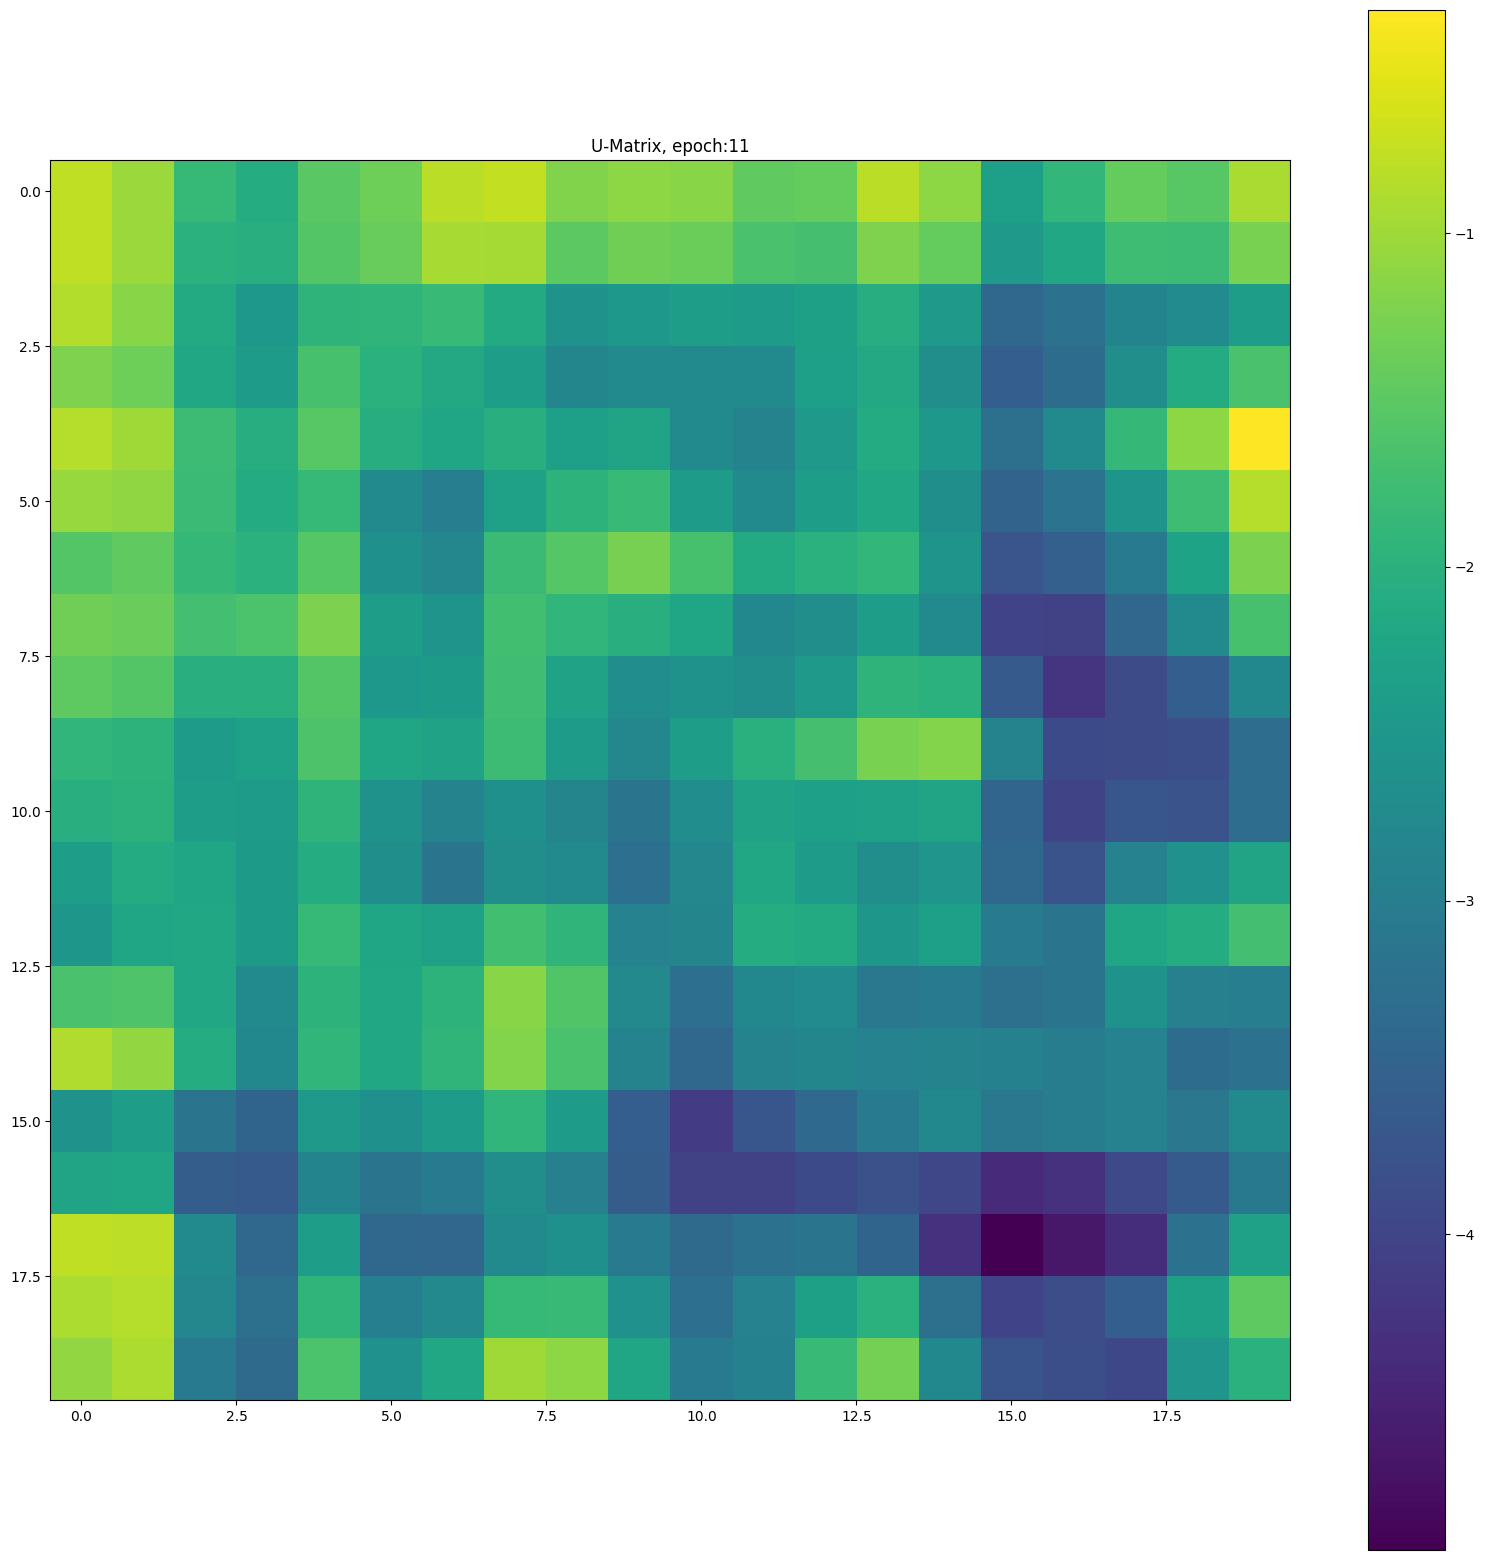

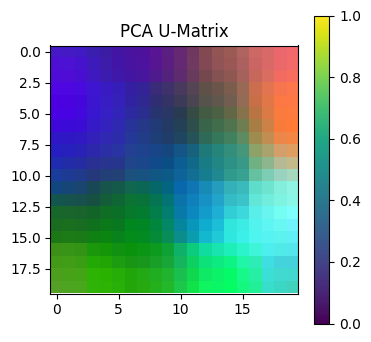

Epoch: 12, QE: 0.2377, TE: 0.3634


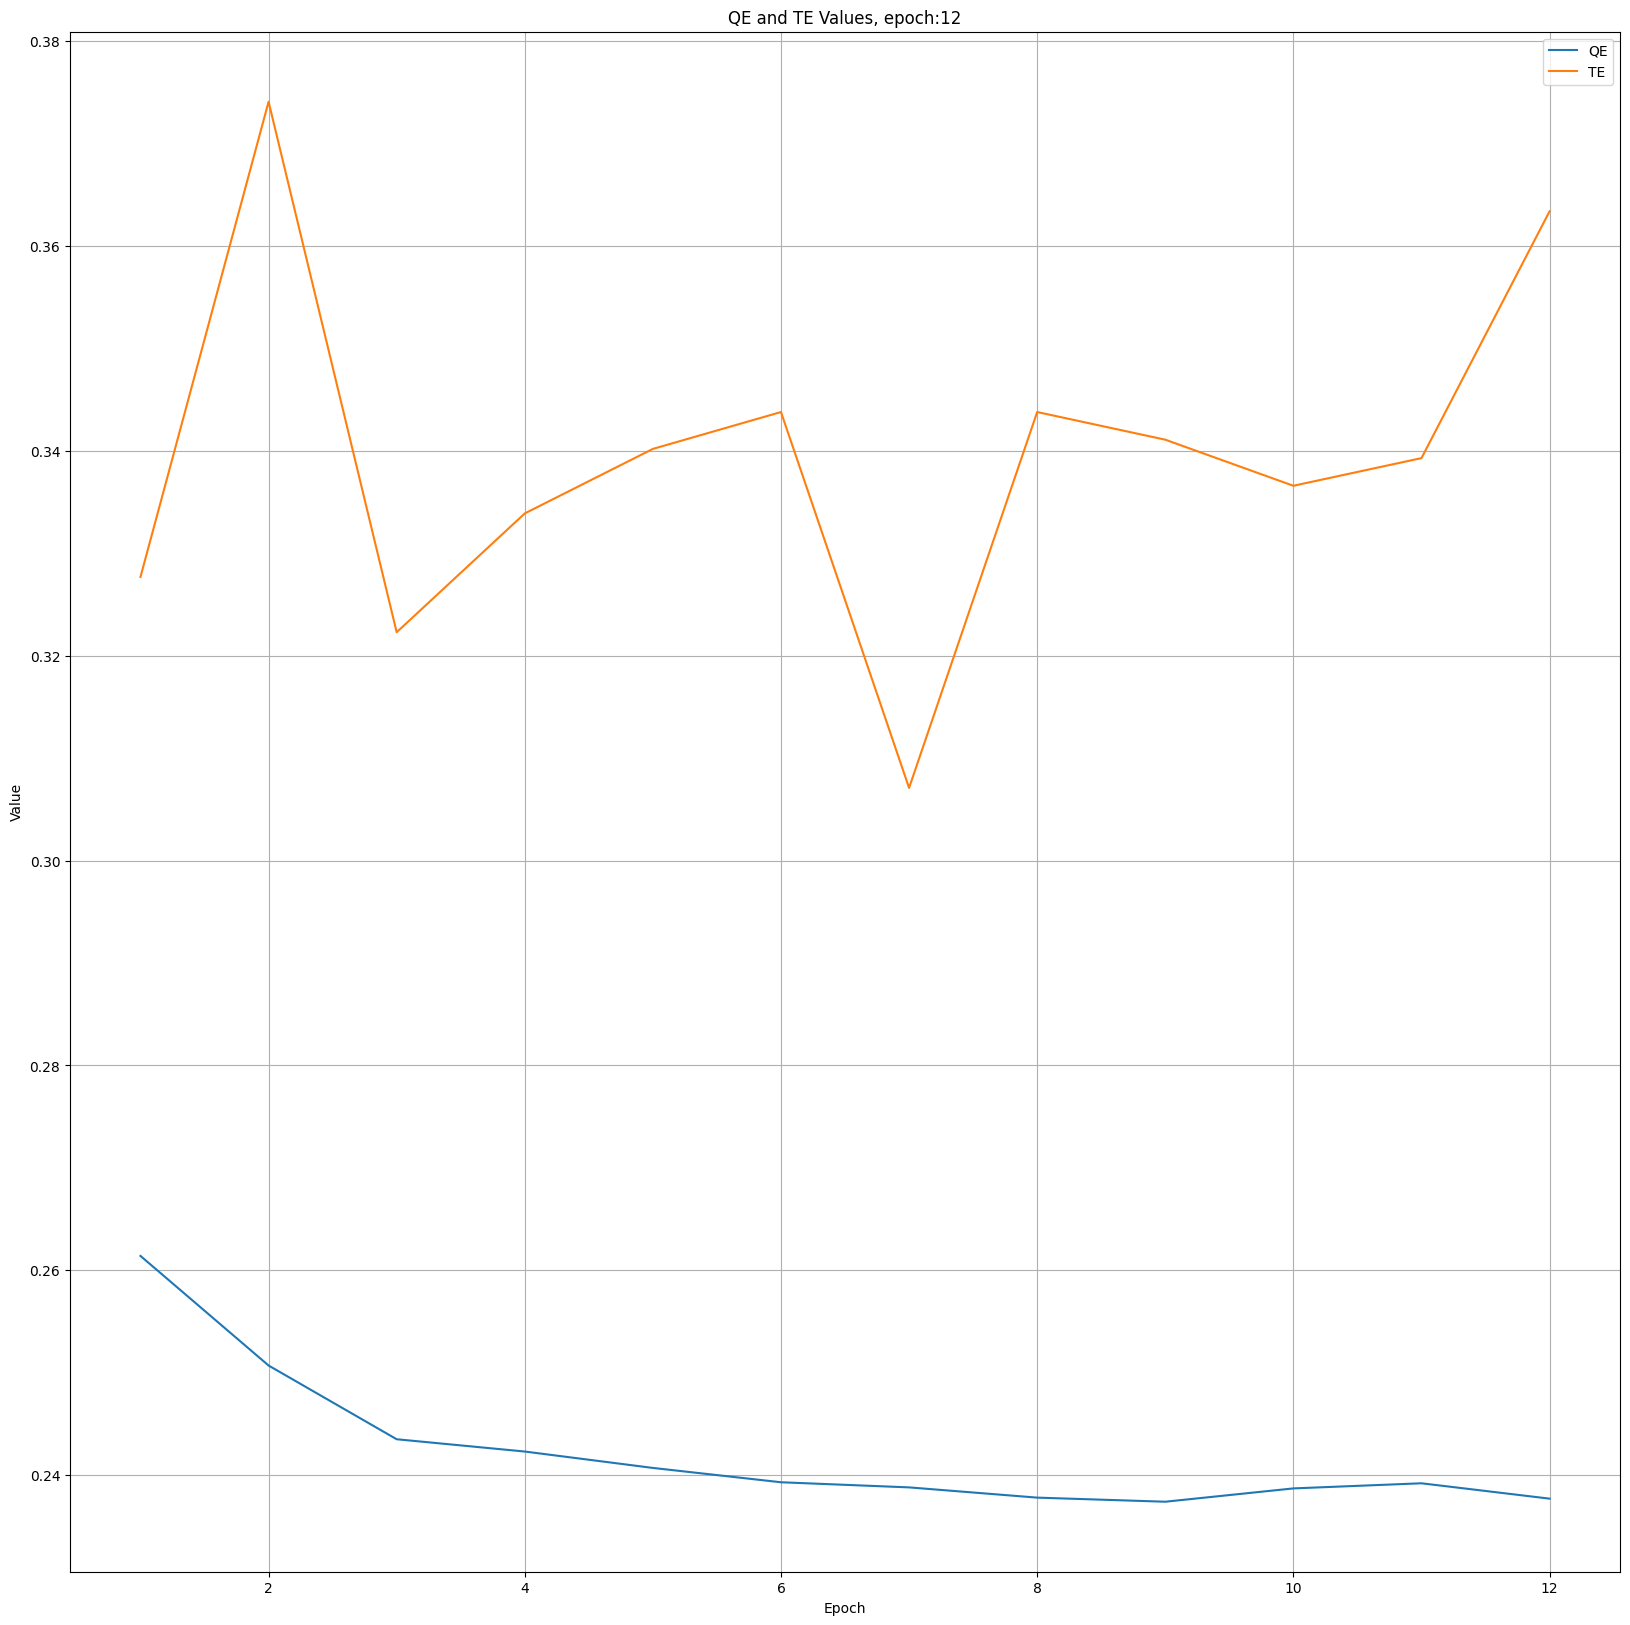

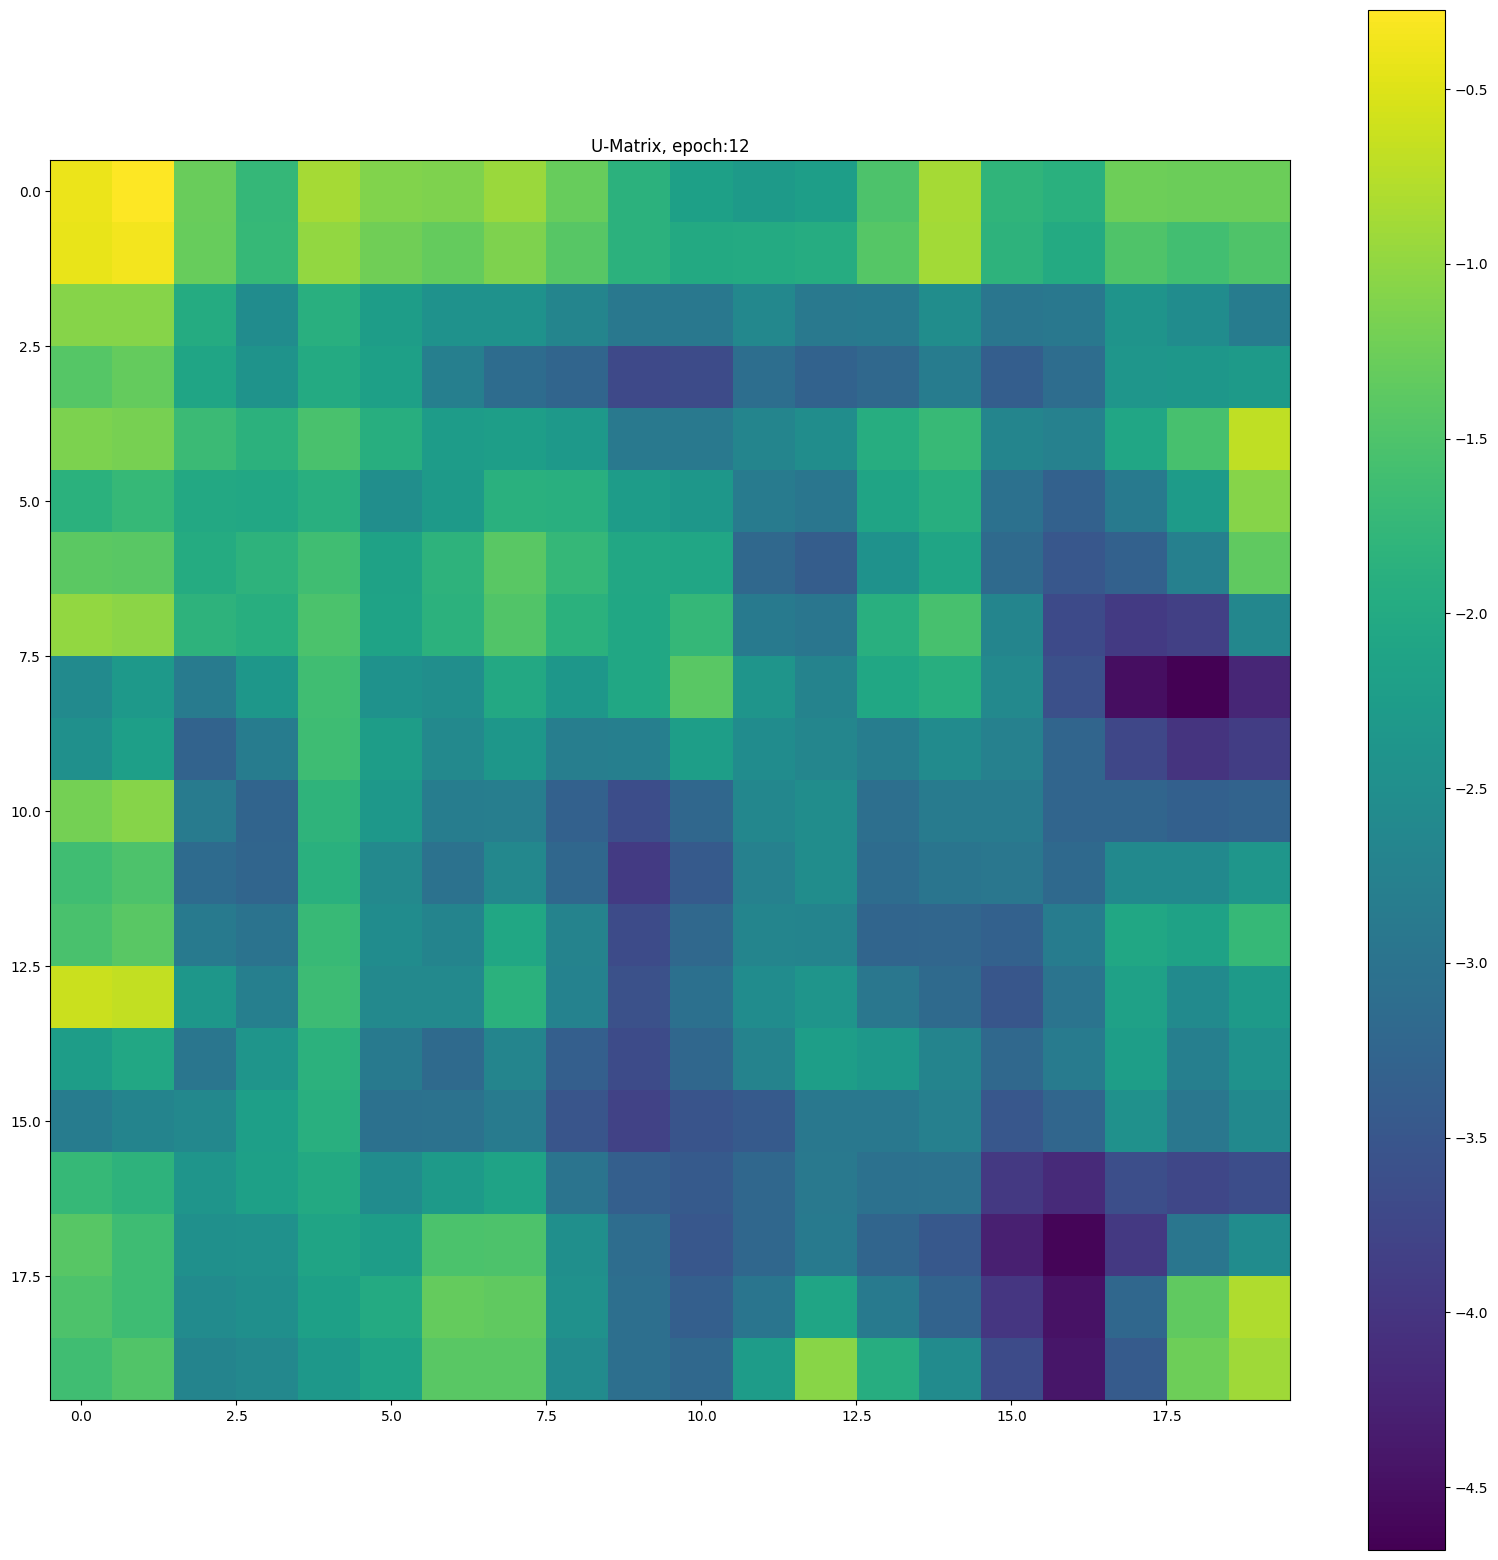

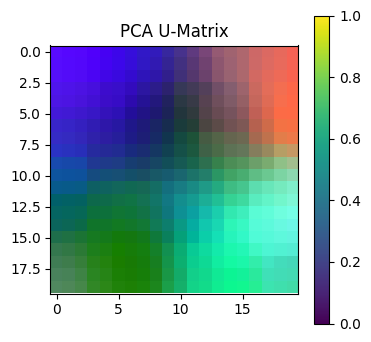

Epoch: 13, QE: 0.2391, TE: 0.3268


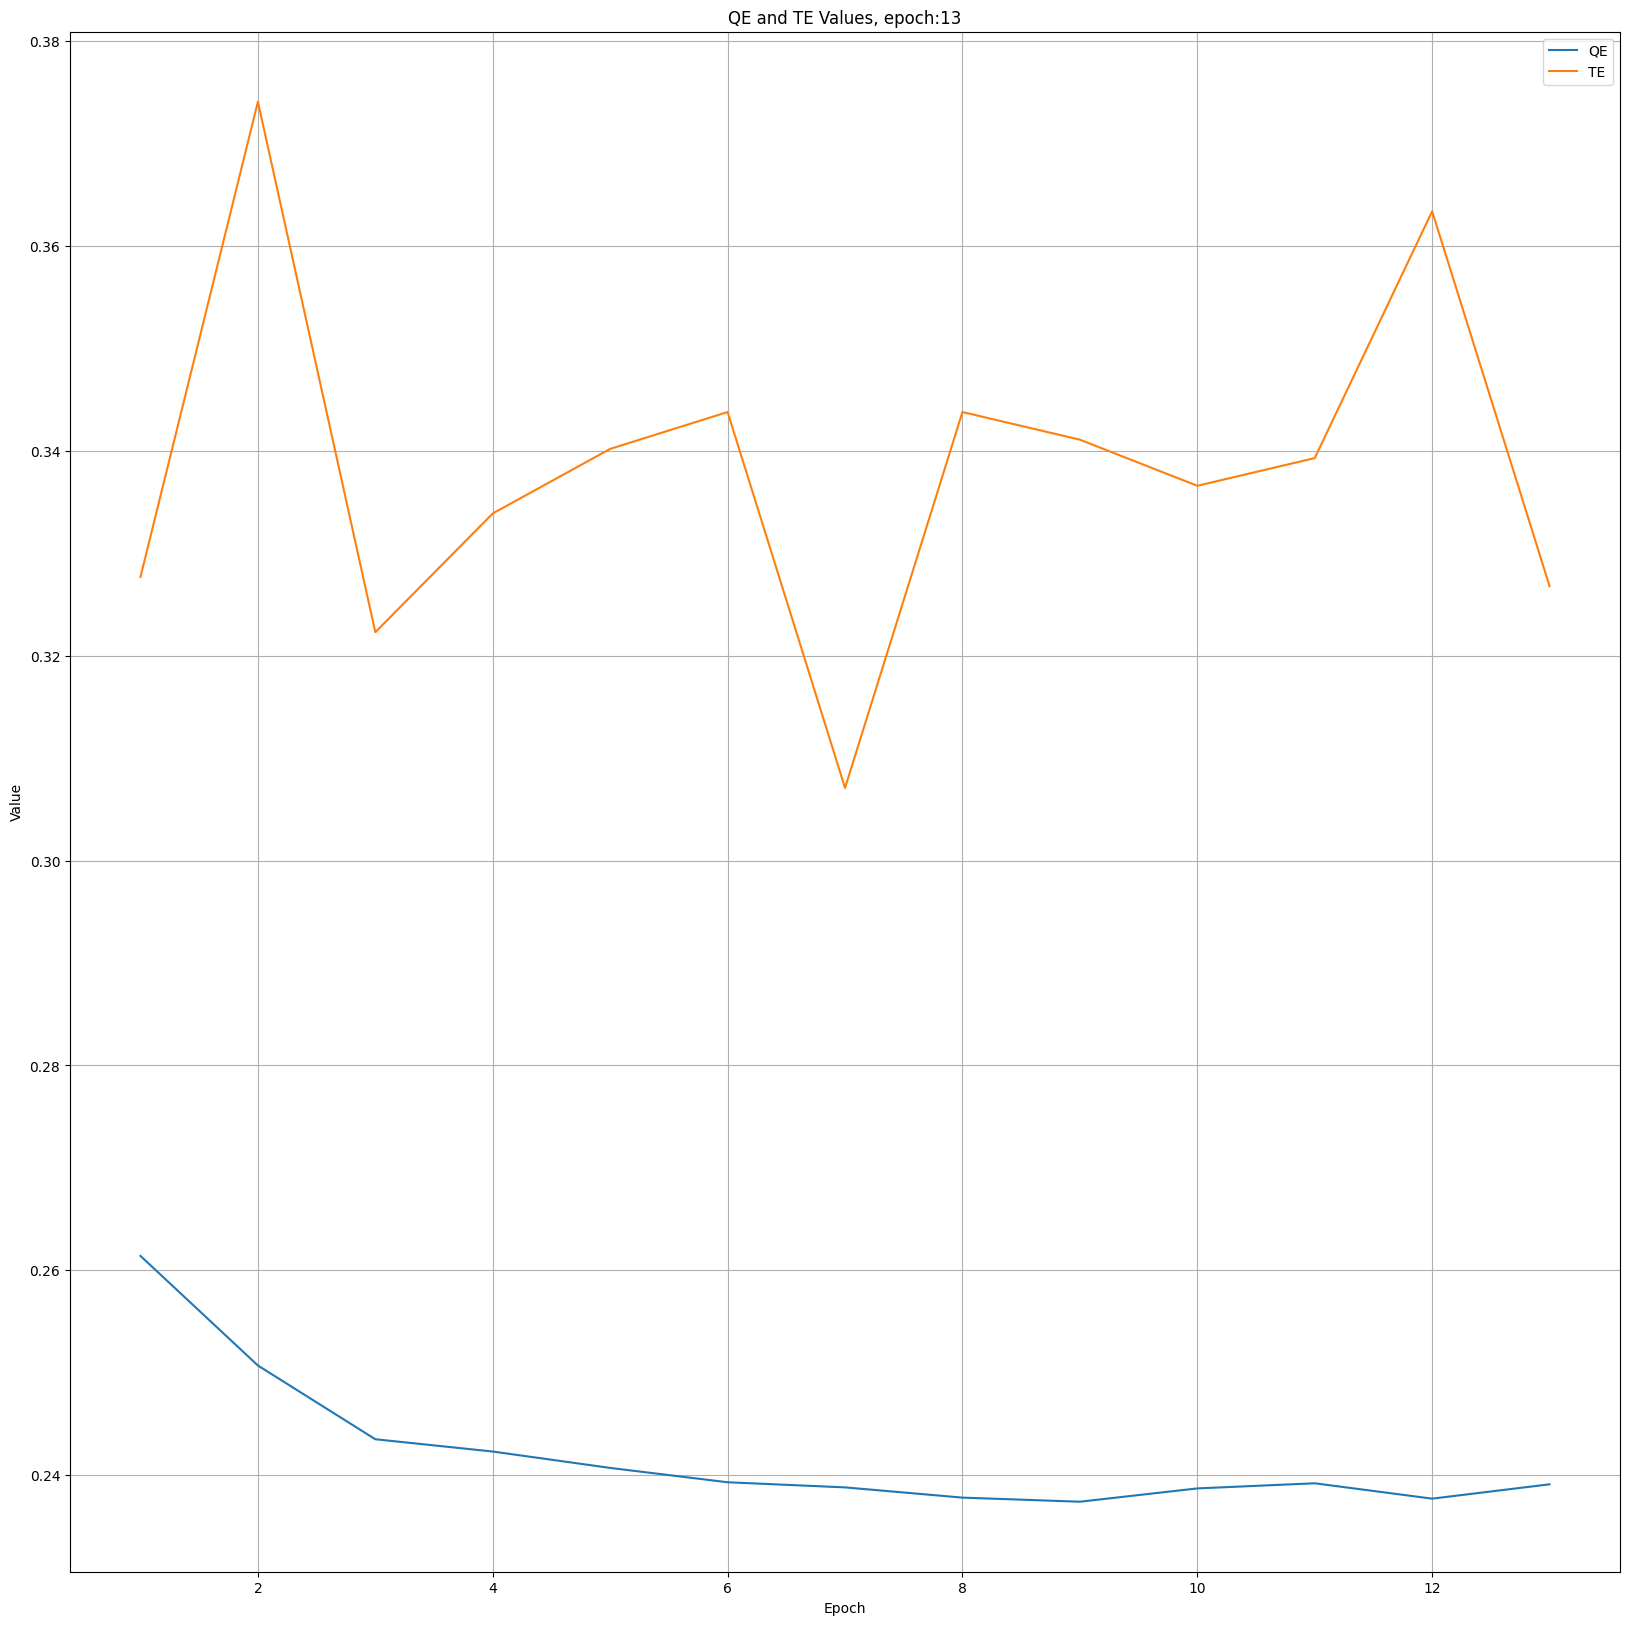

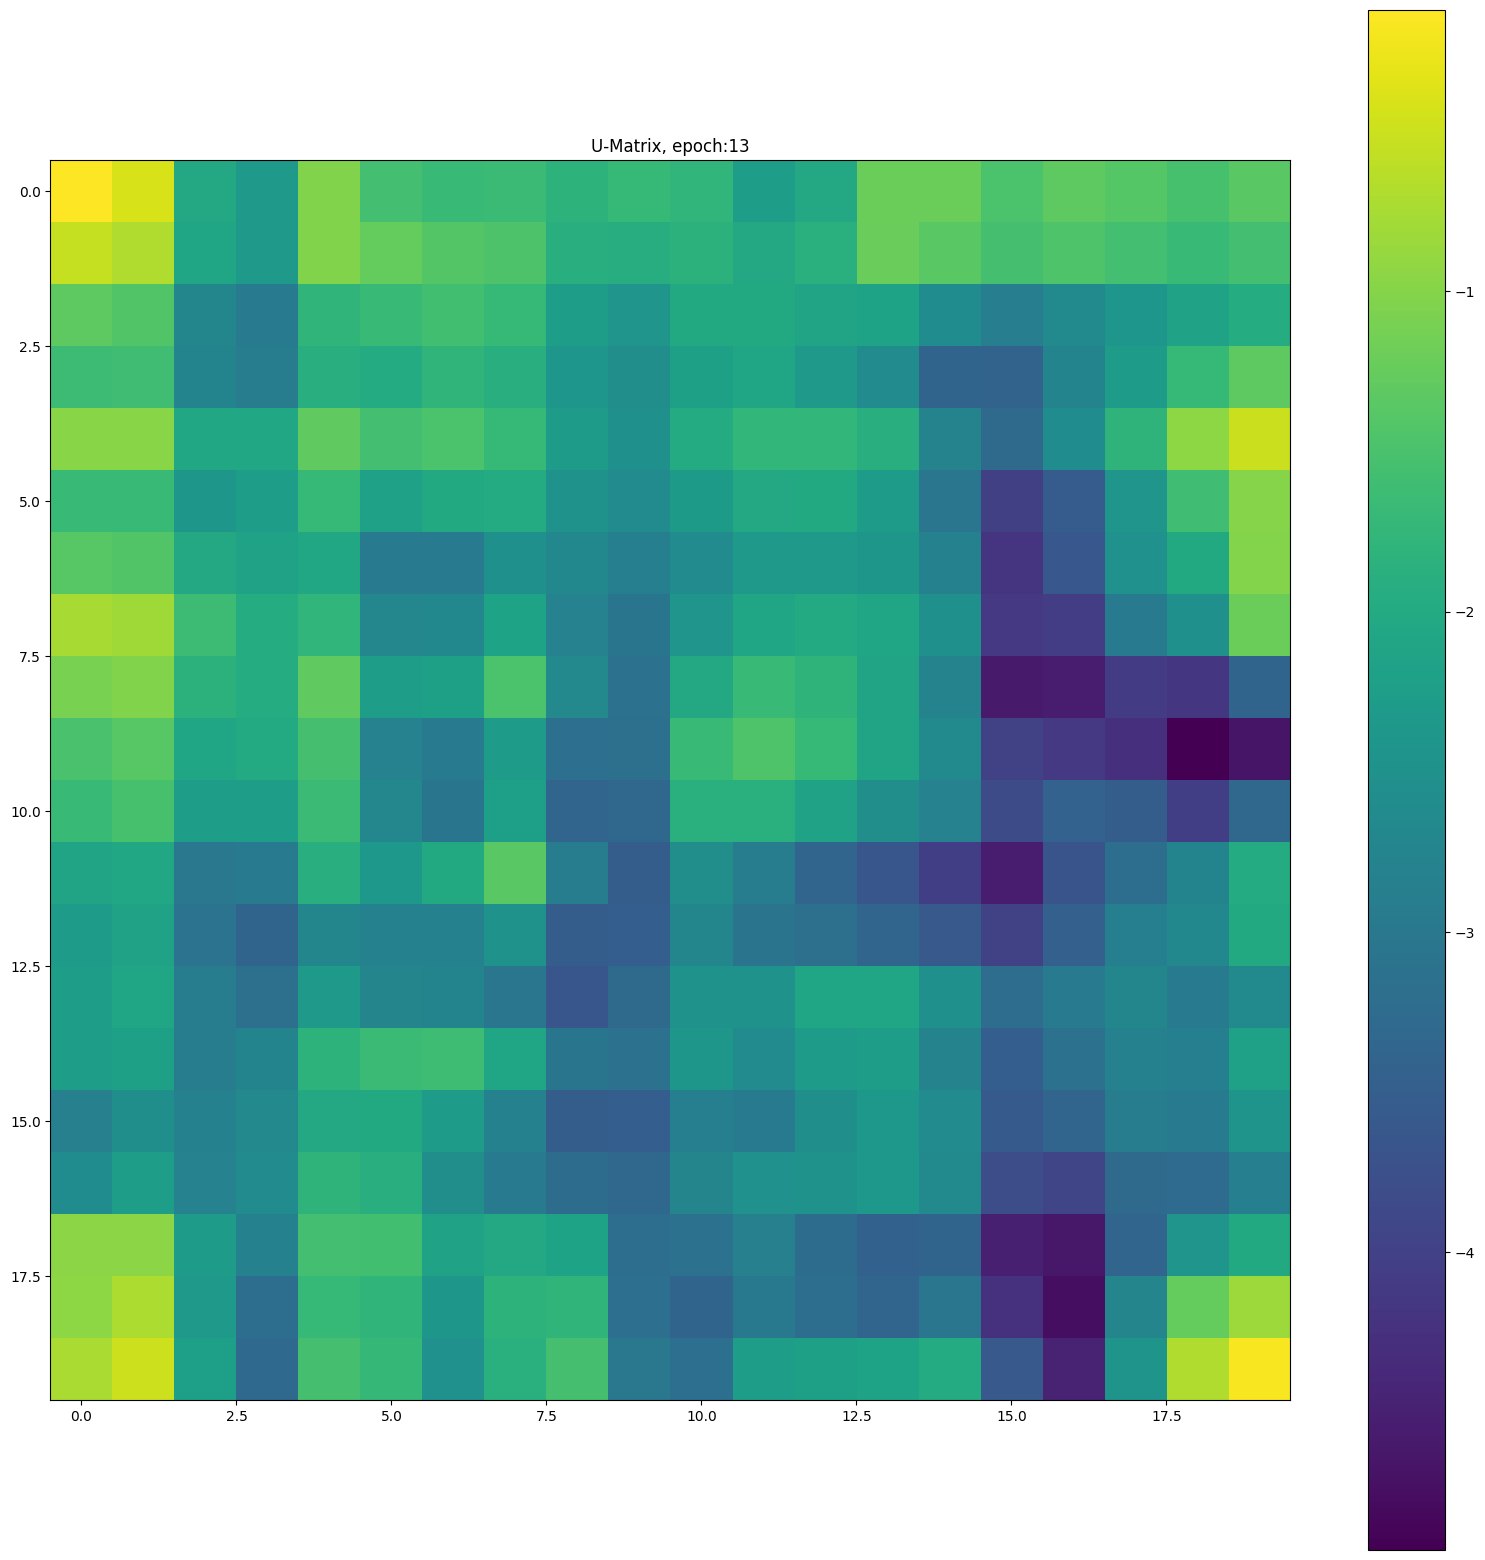

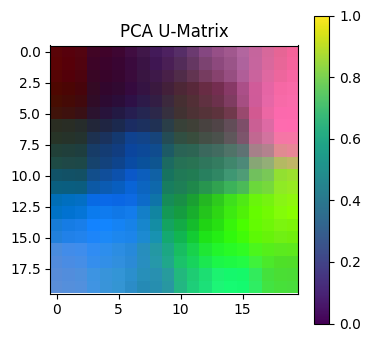

Epoch: 14, QE: 0.2363, TE: 0.3402


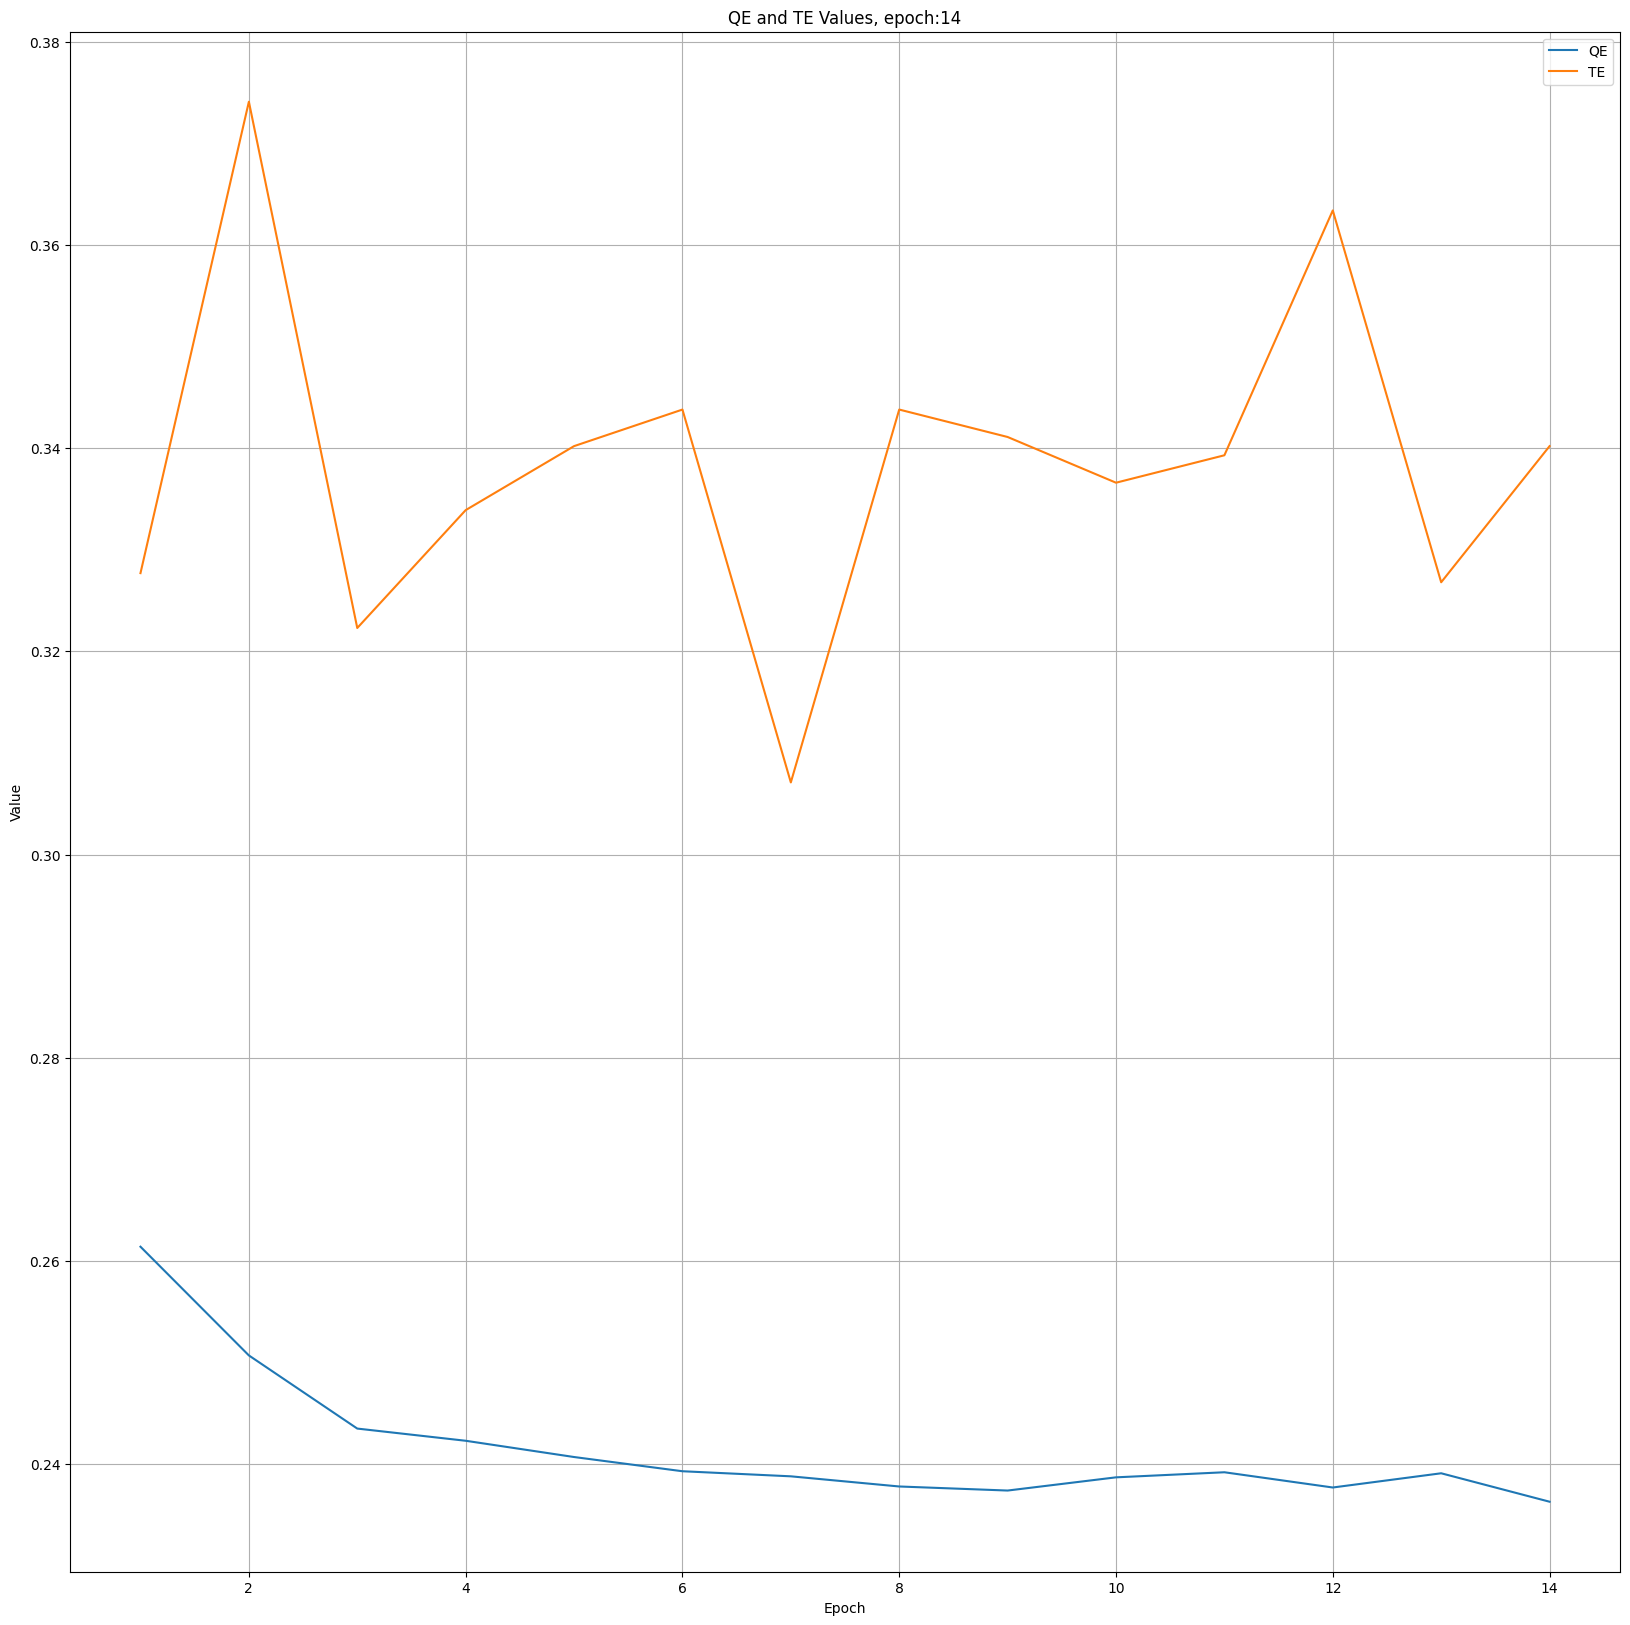

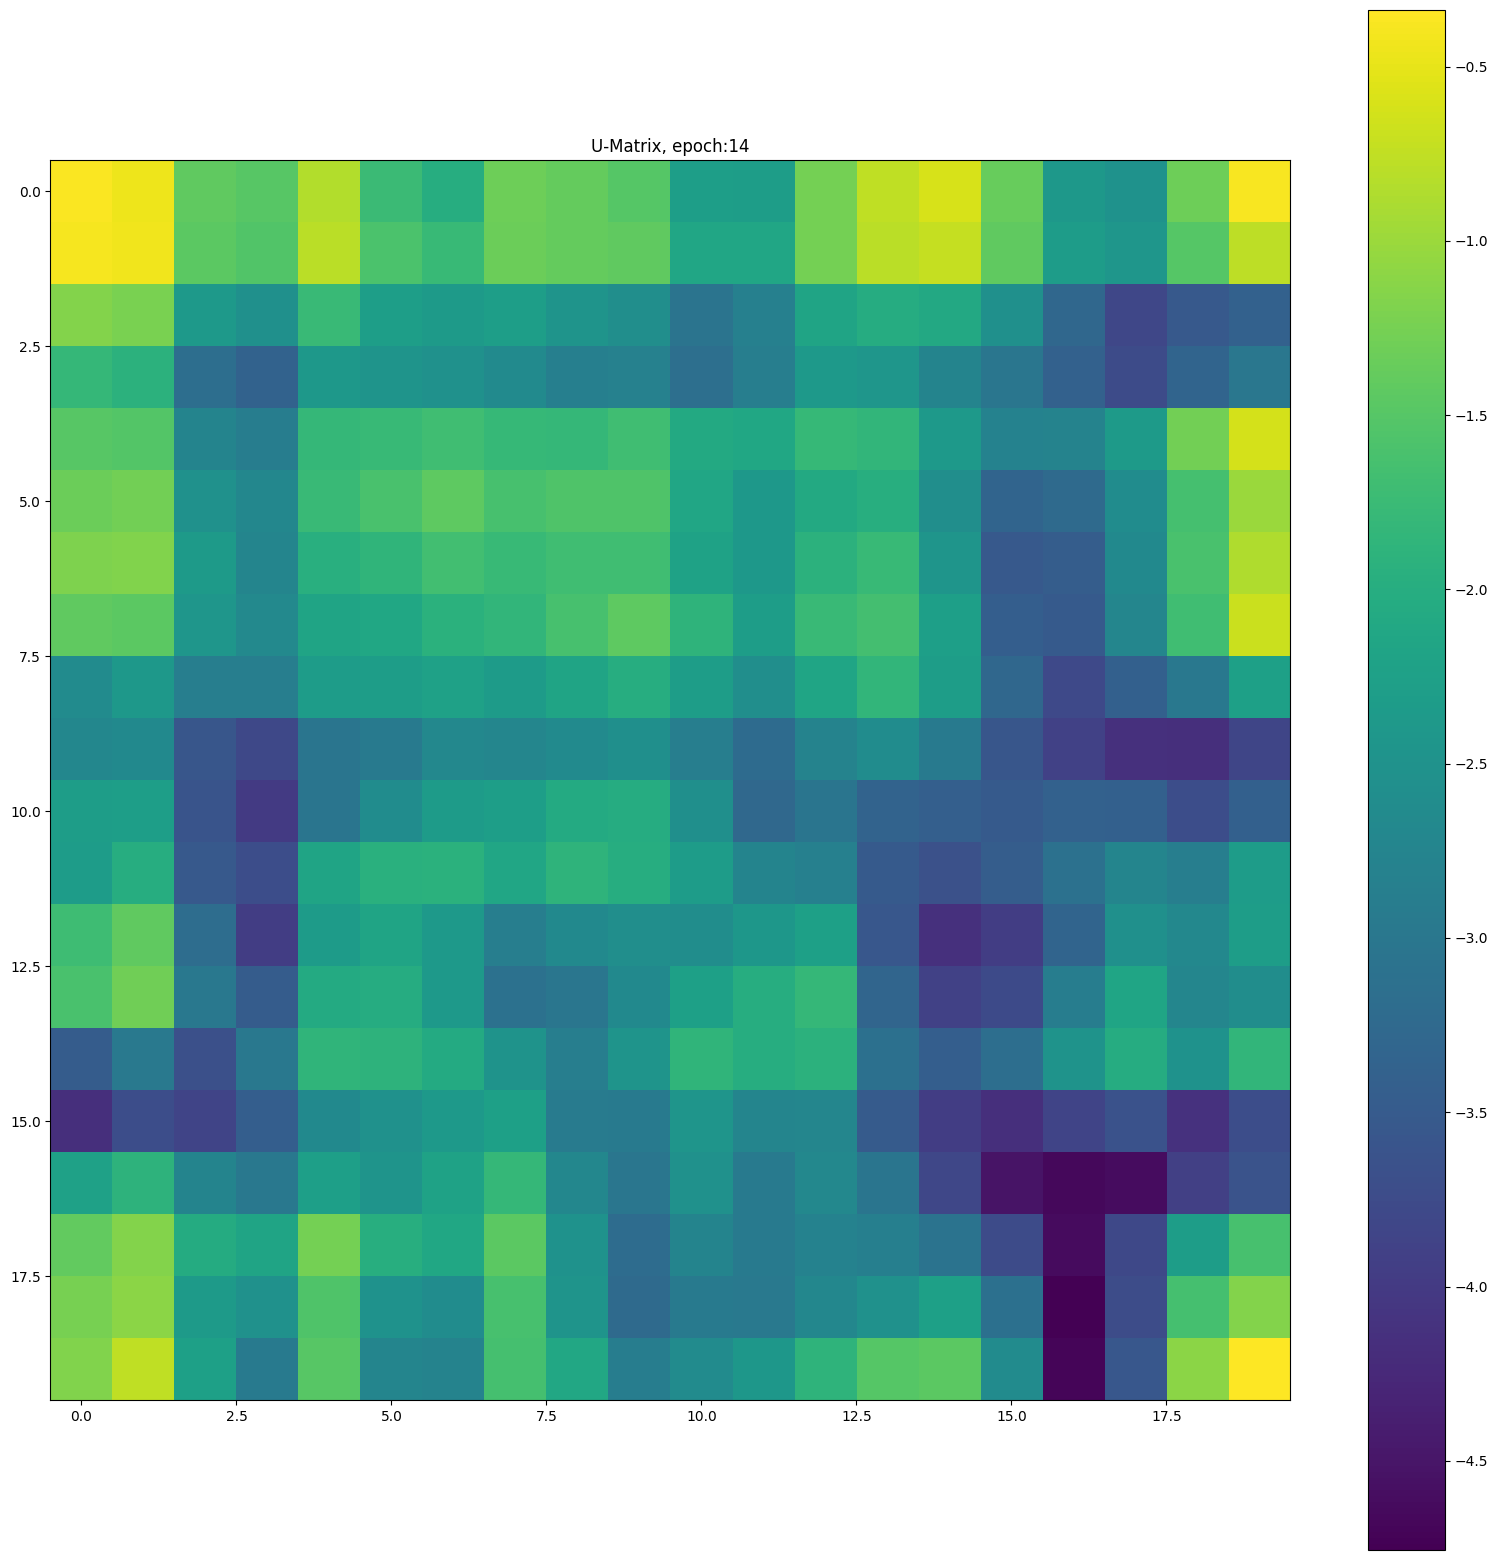

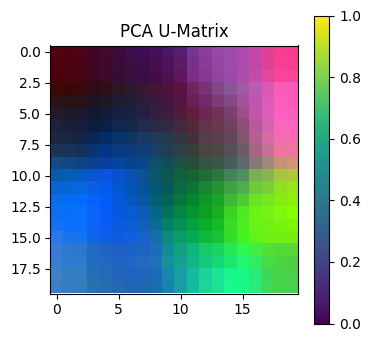

Epoch: 15, QE: 0.2395, TE: 0.3348


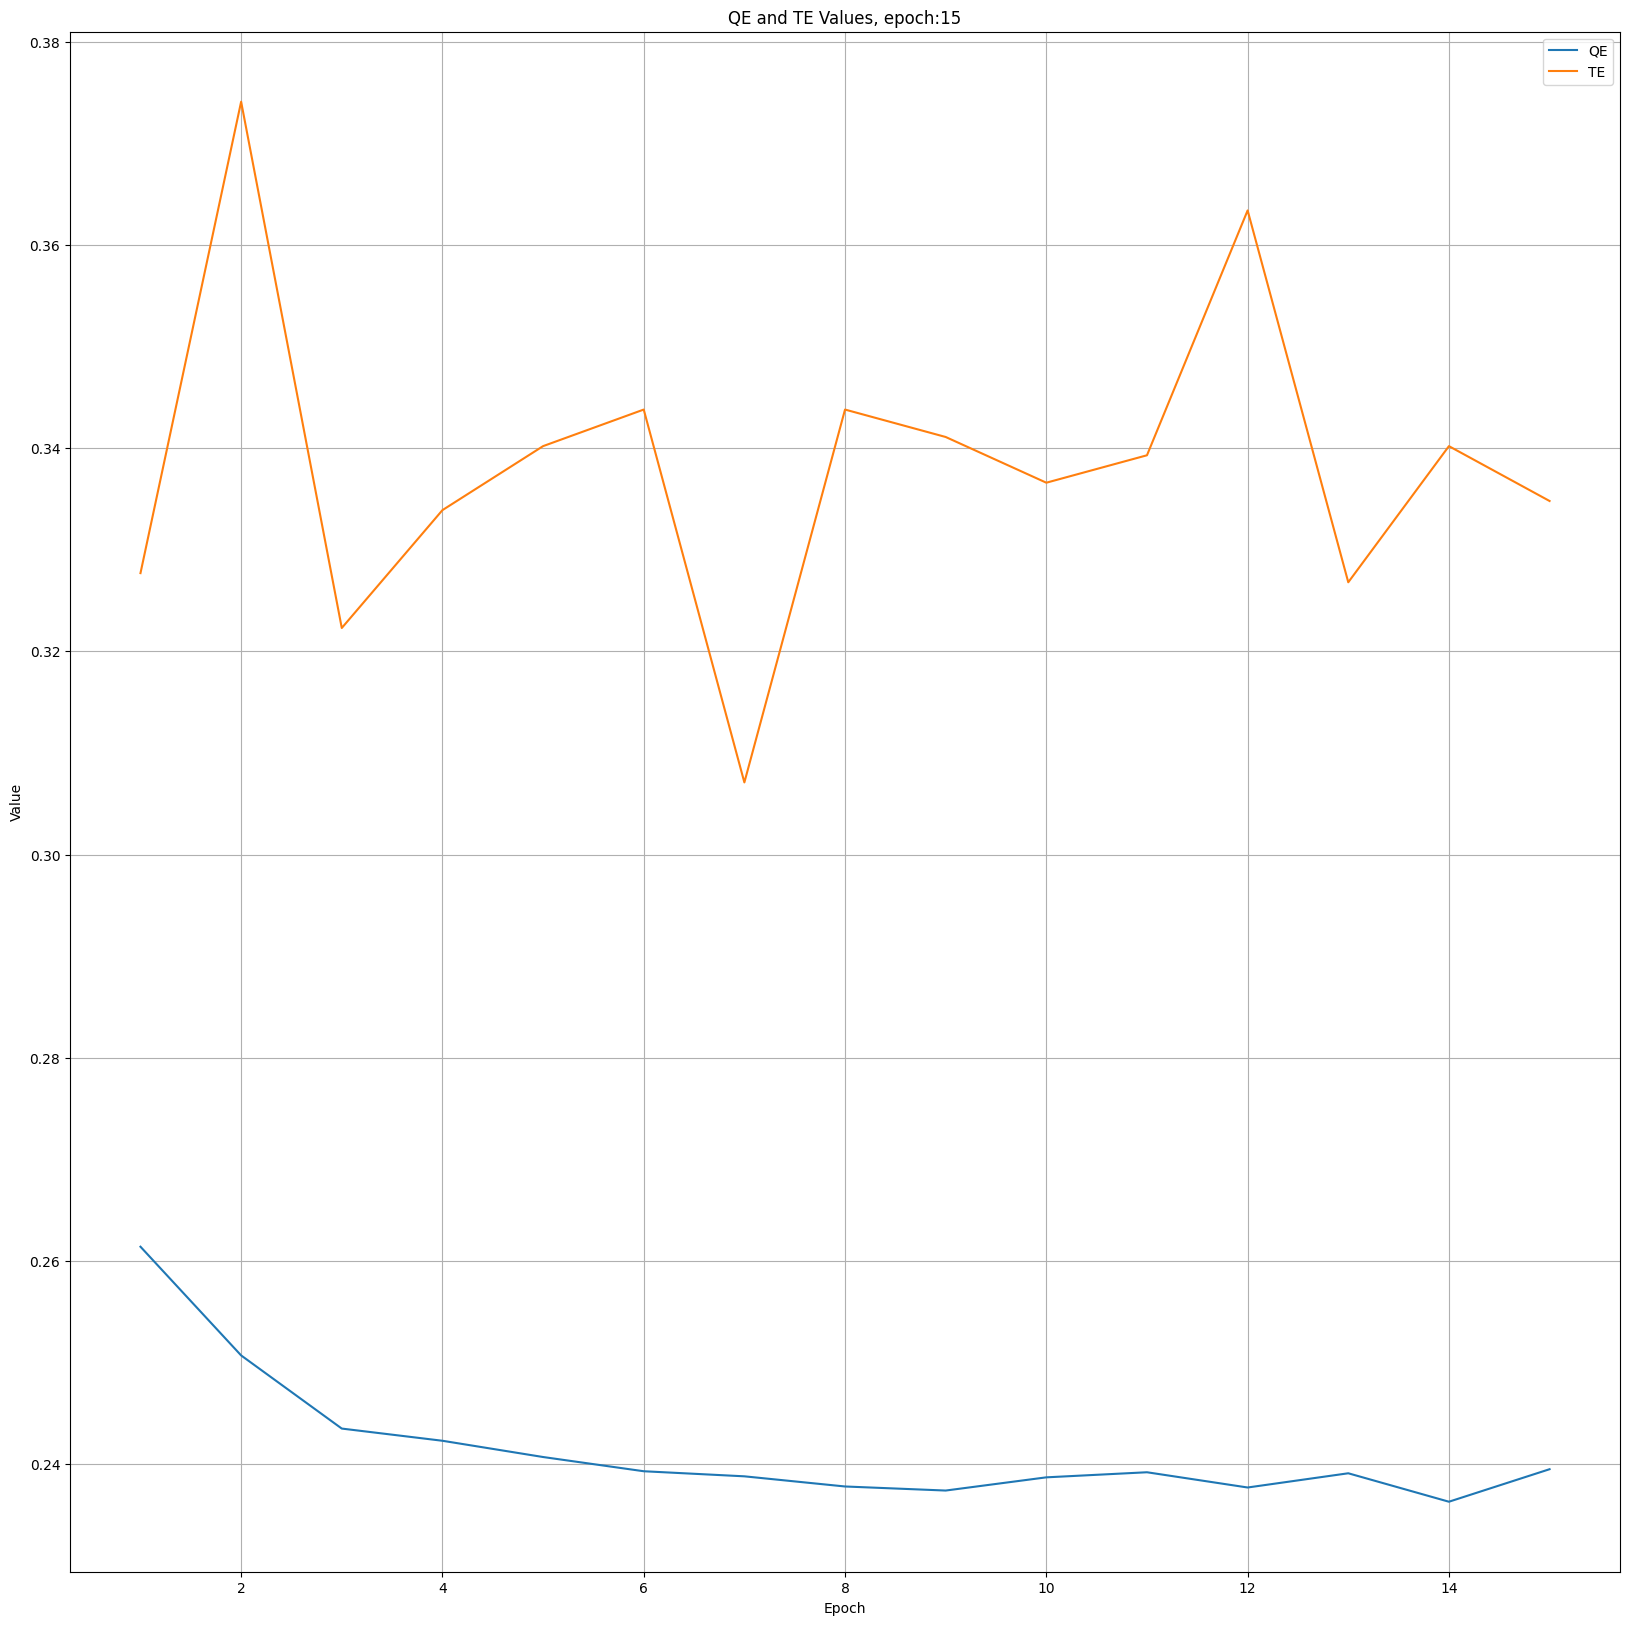

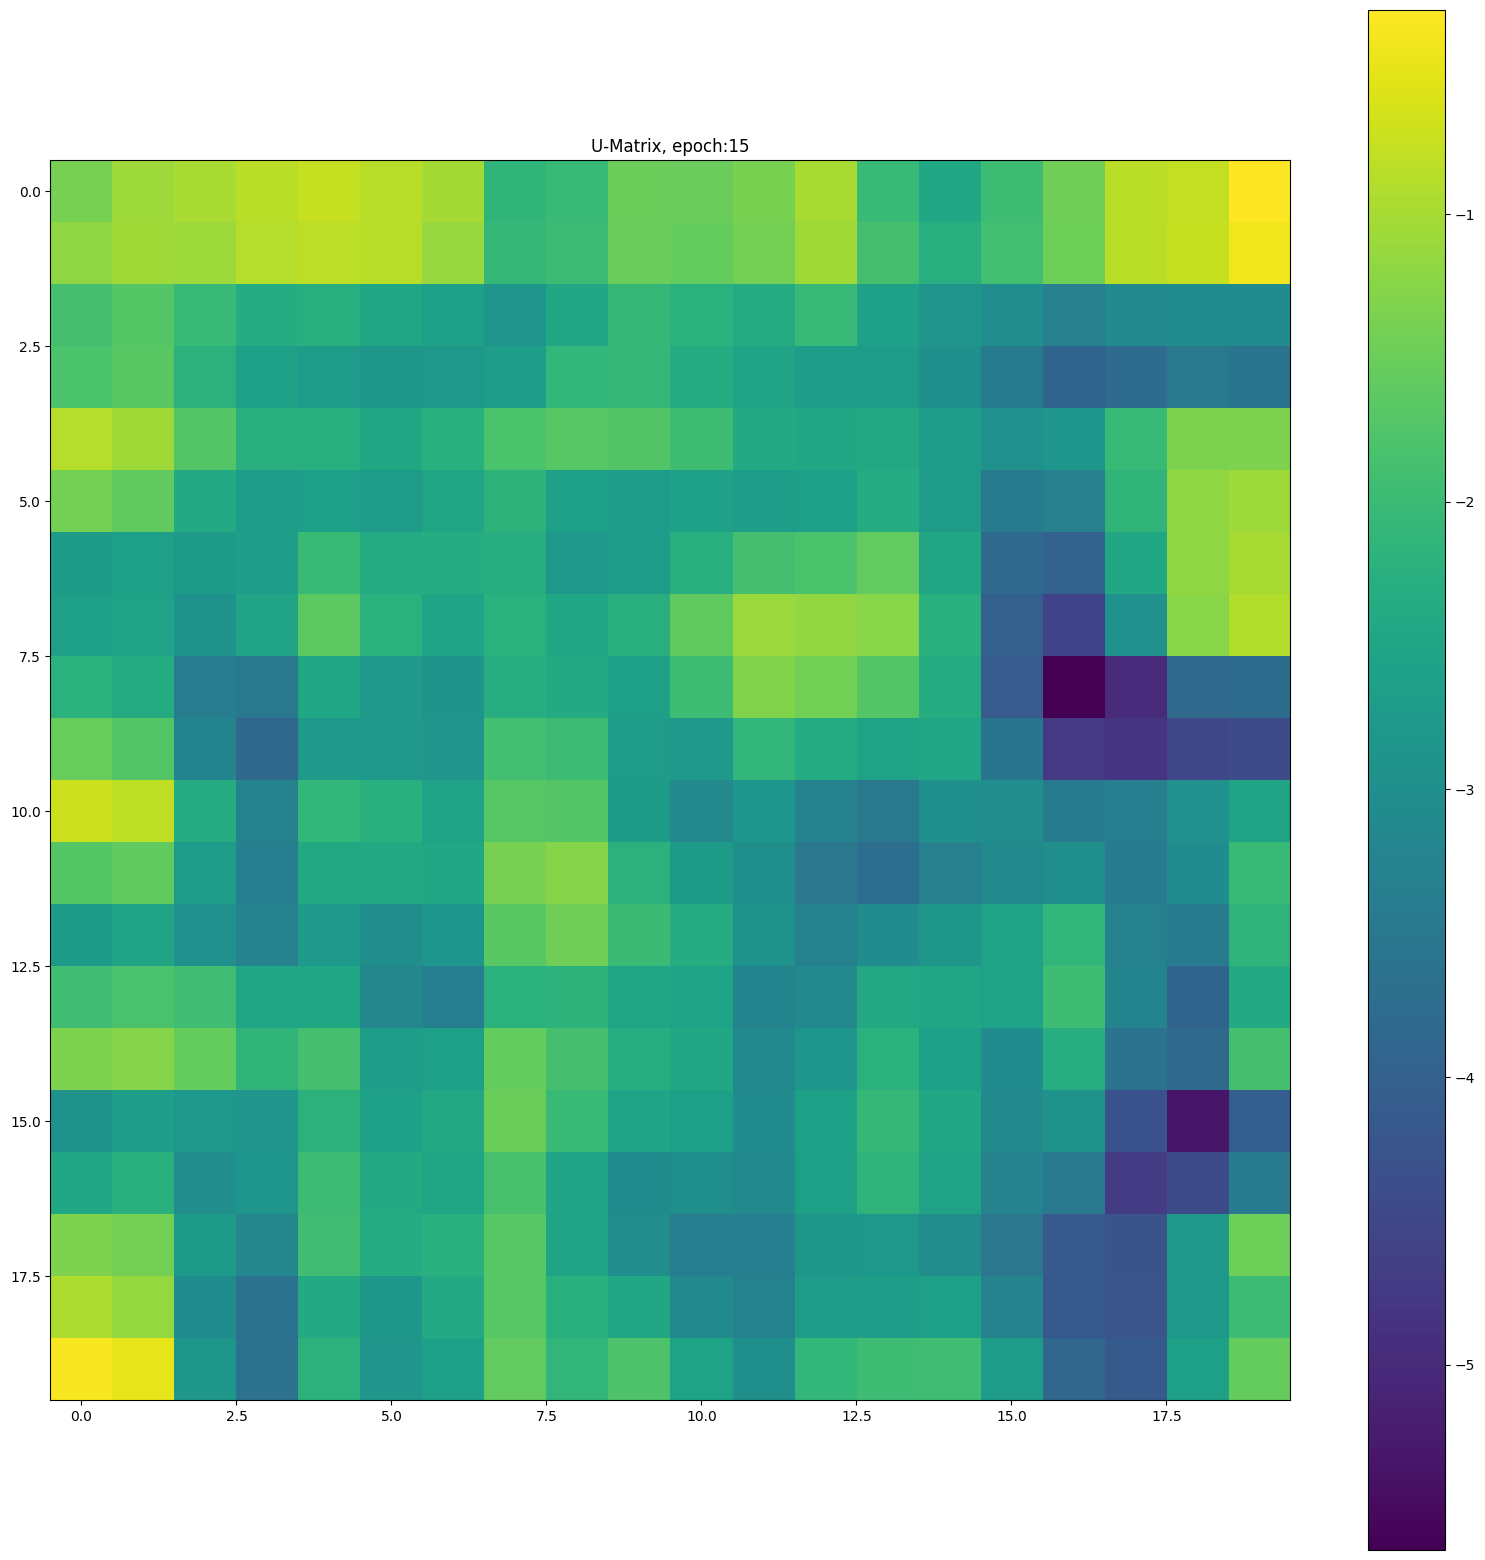

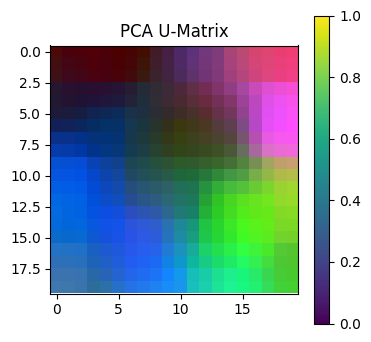

Epoch: 16, QE: 0.2394, TE: 0.3696


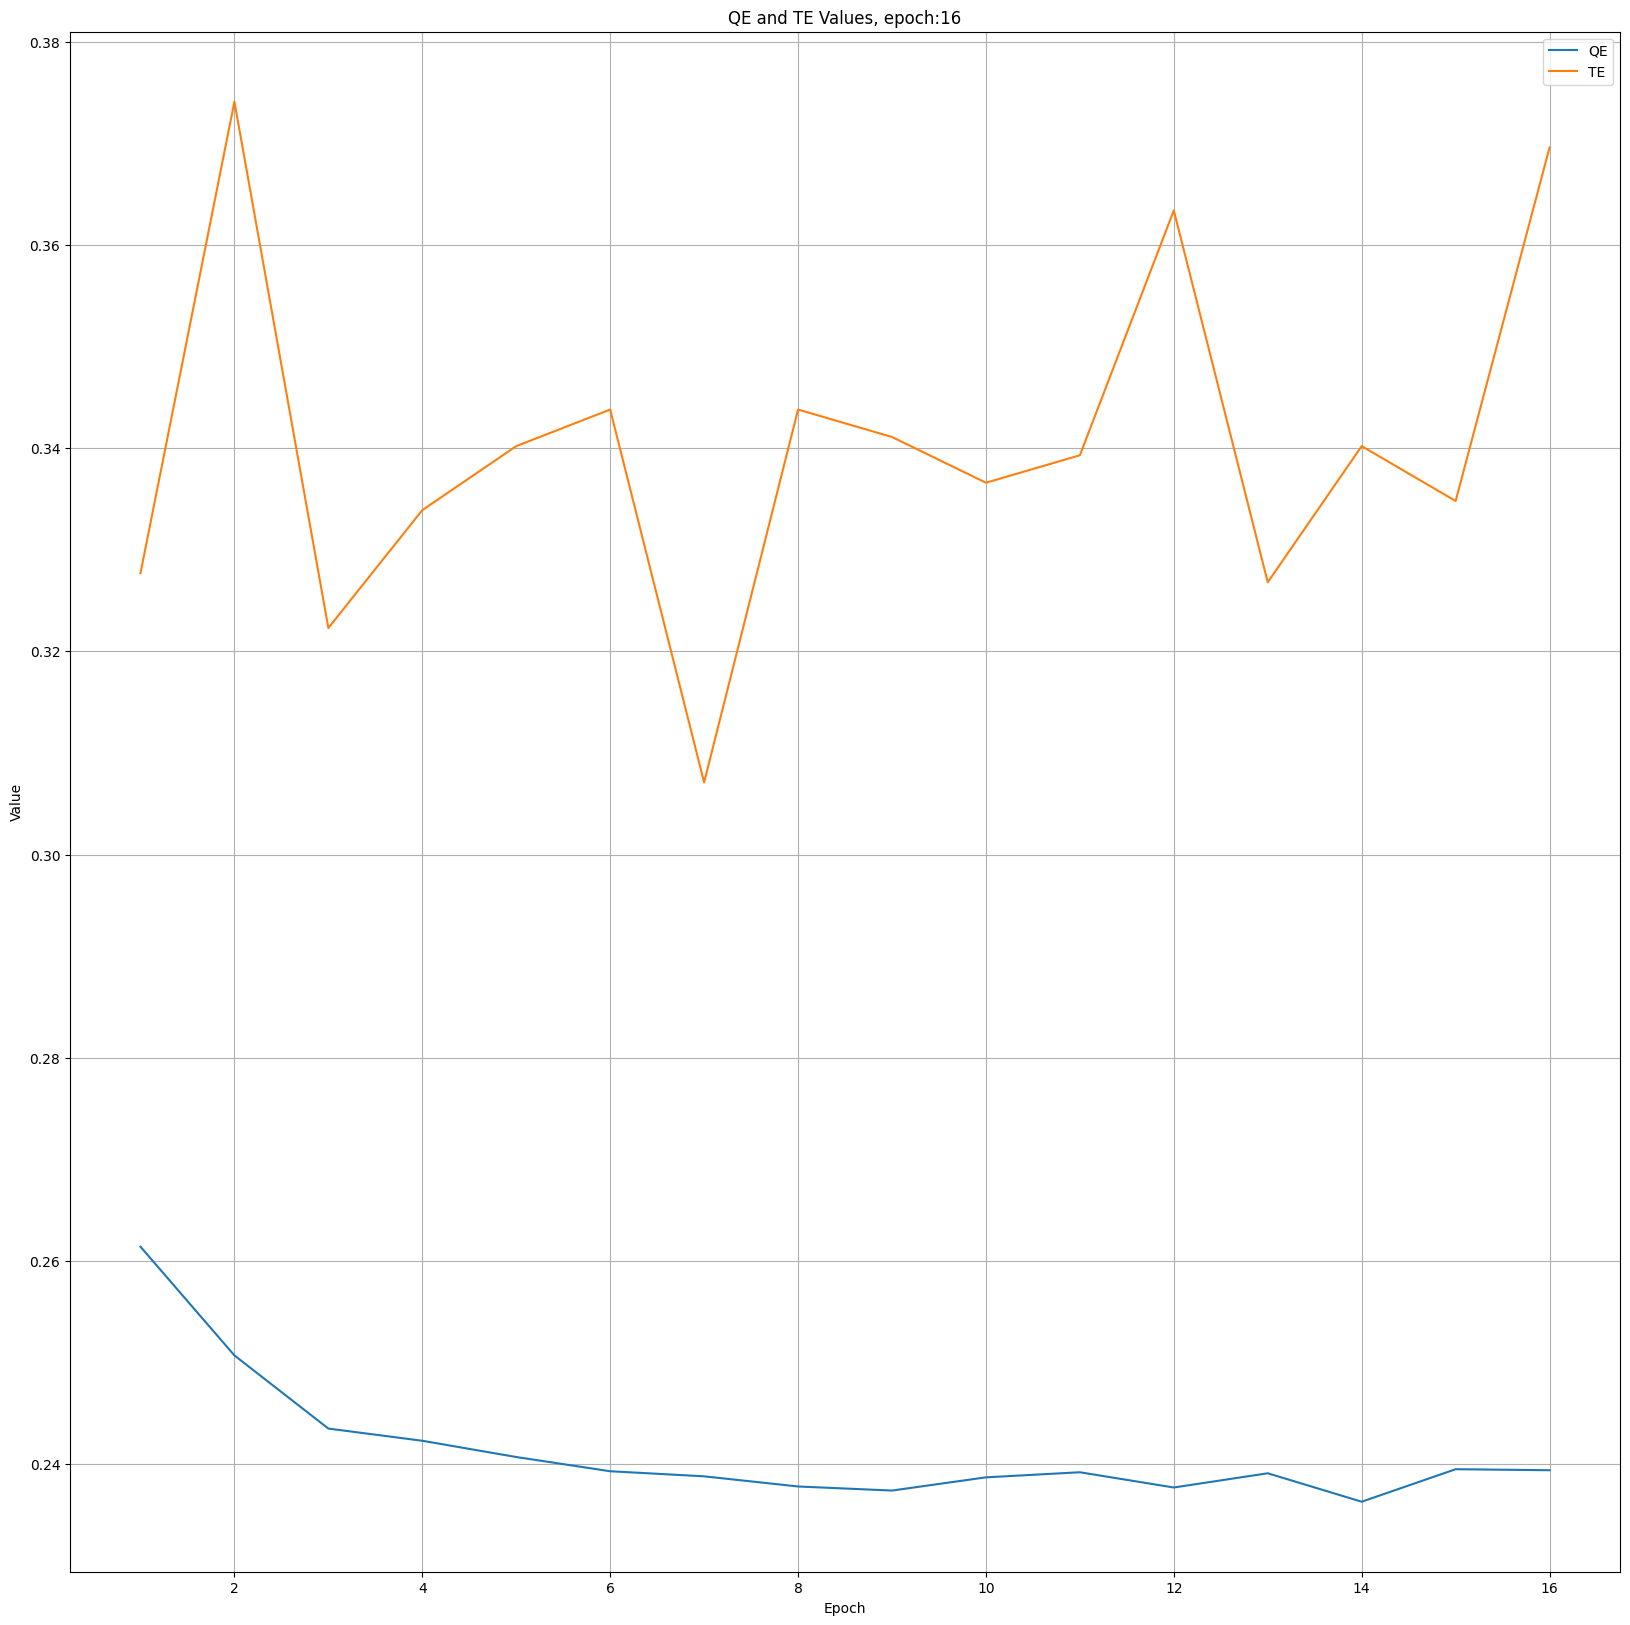

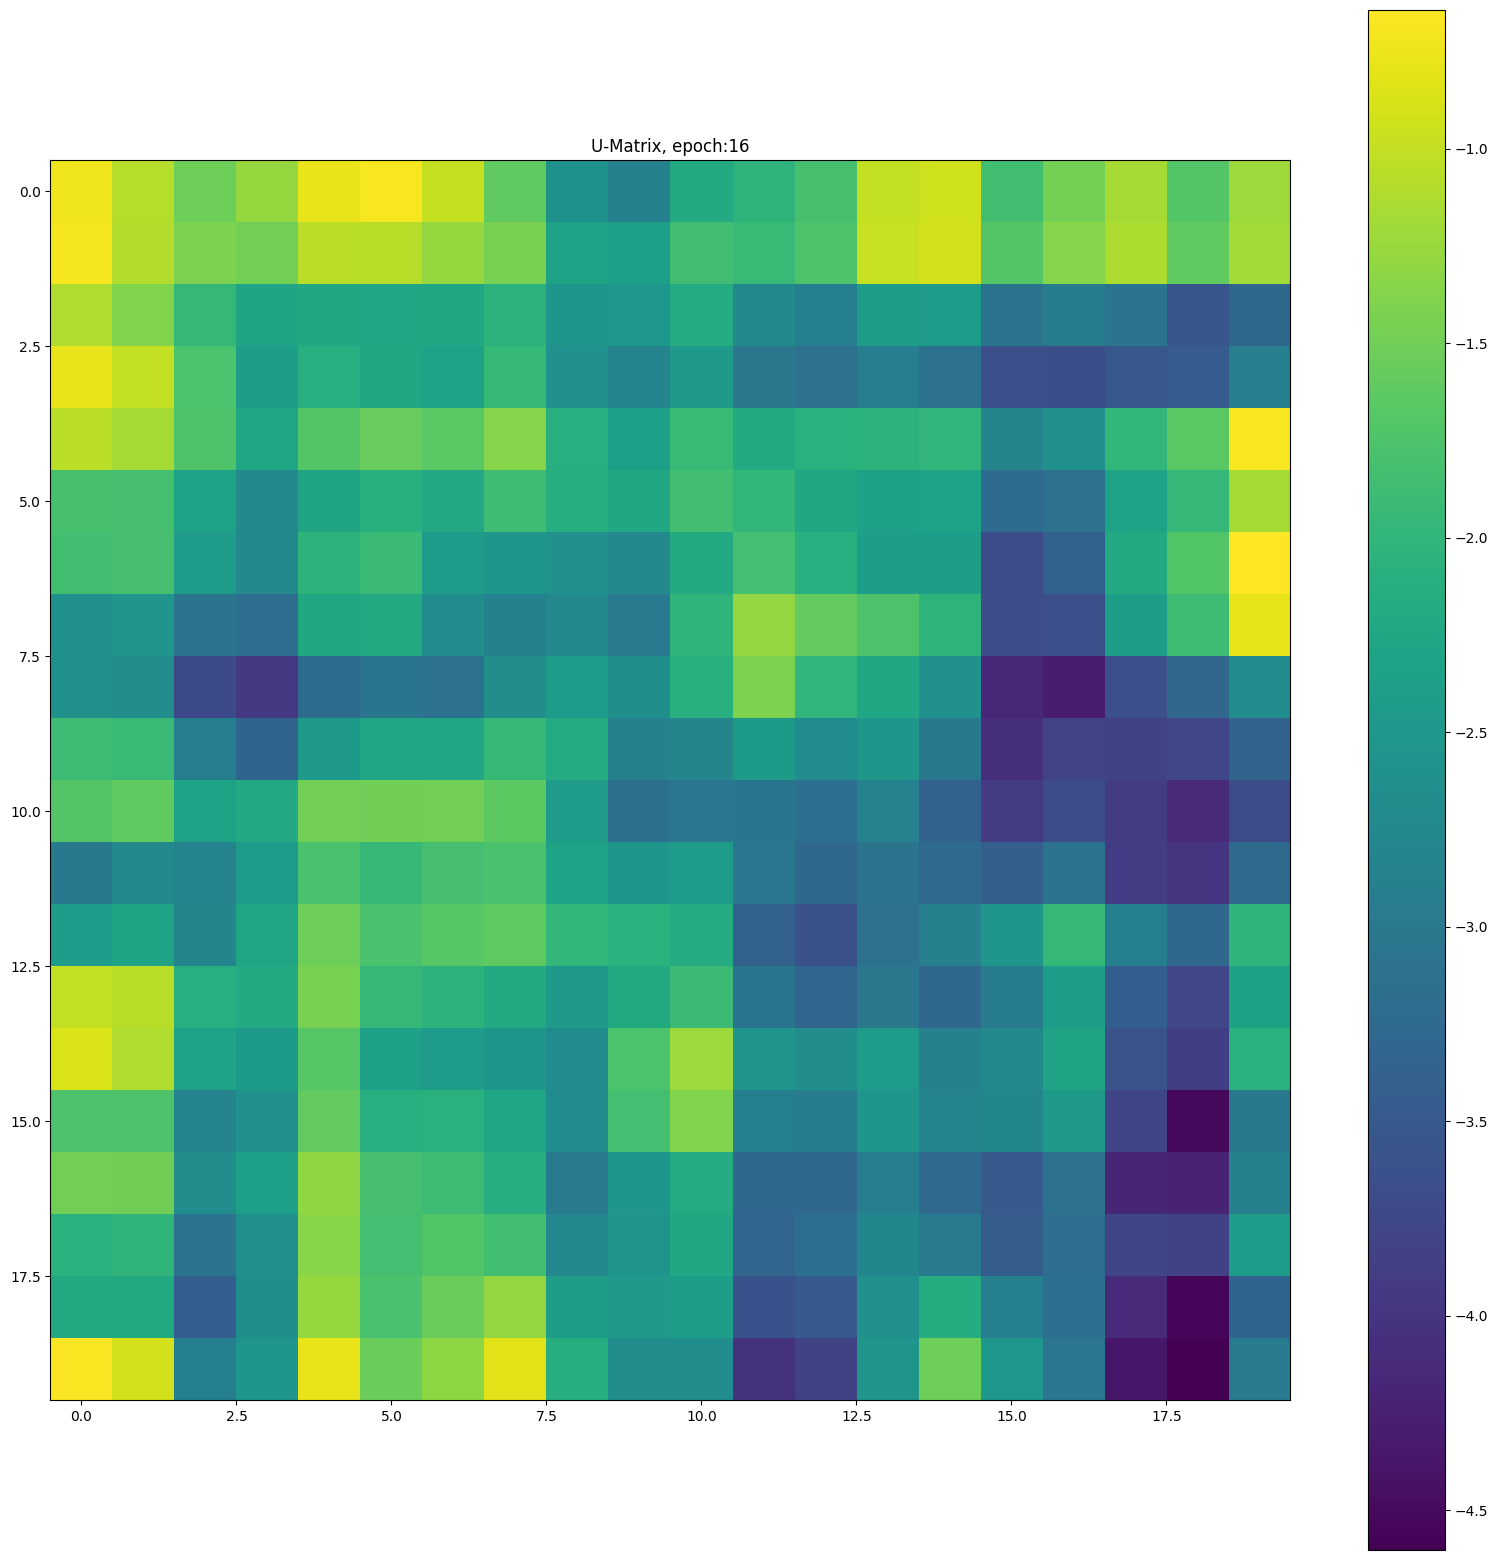

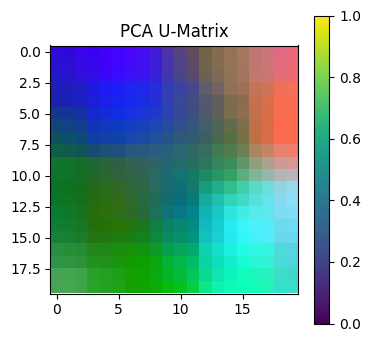

Epoch: 17, QE: 0.2354, TE: 0.3688


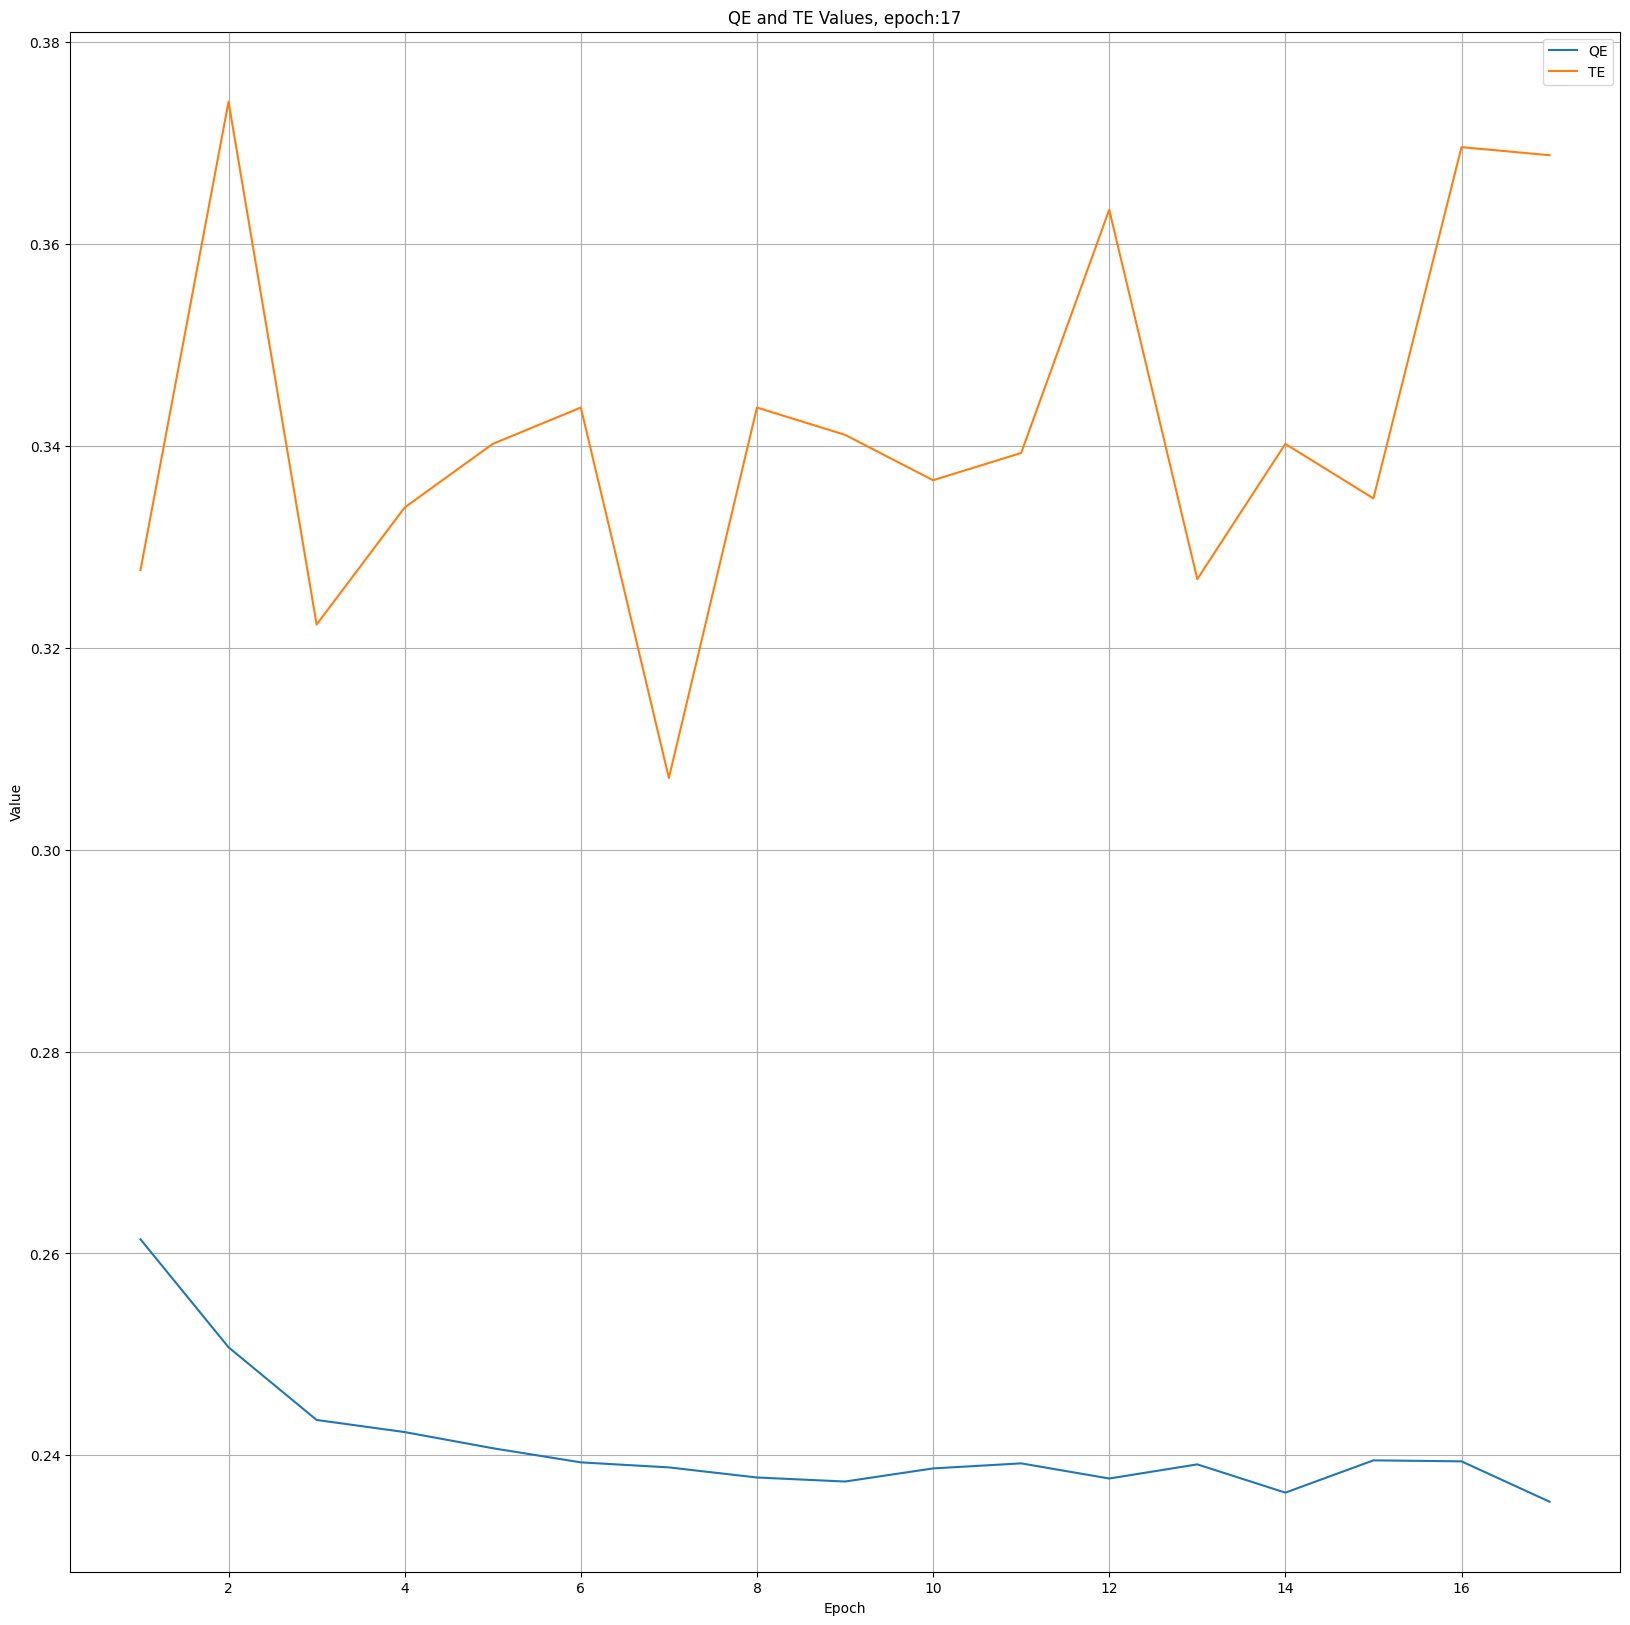

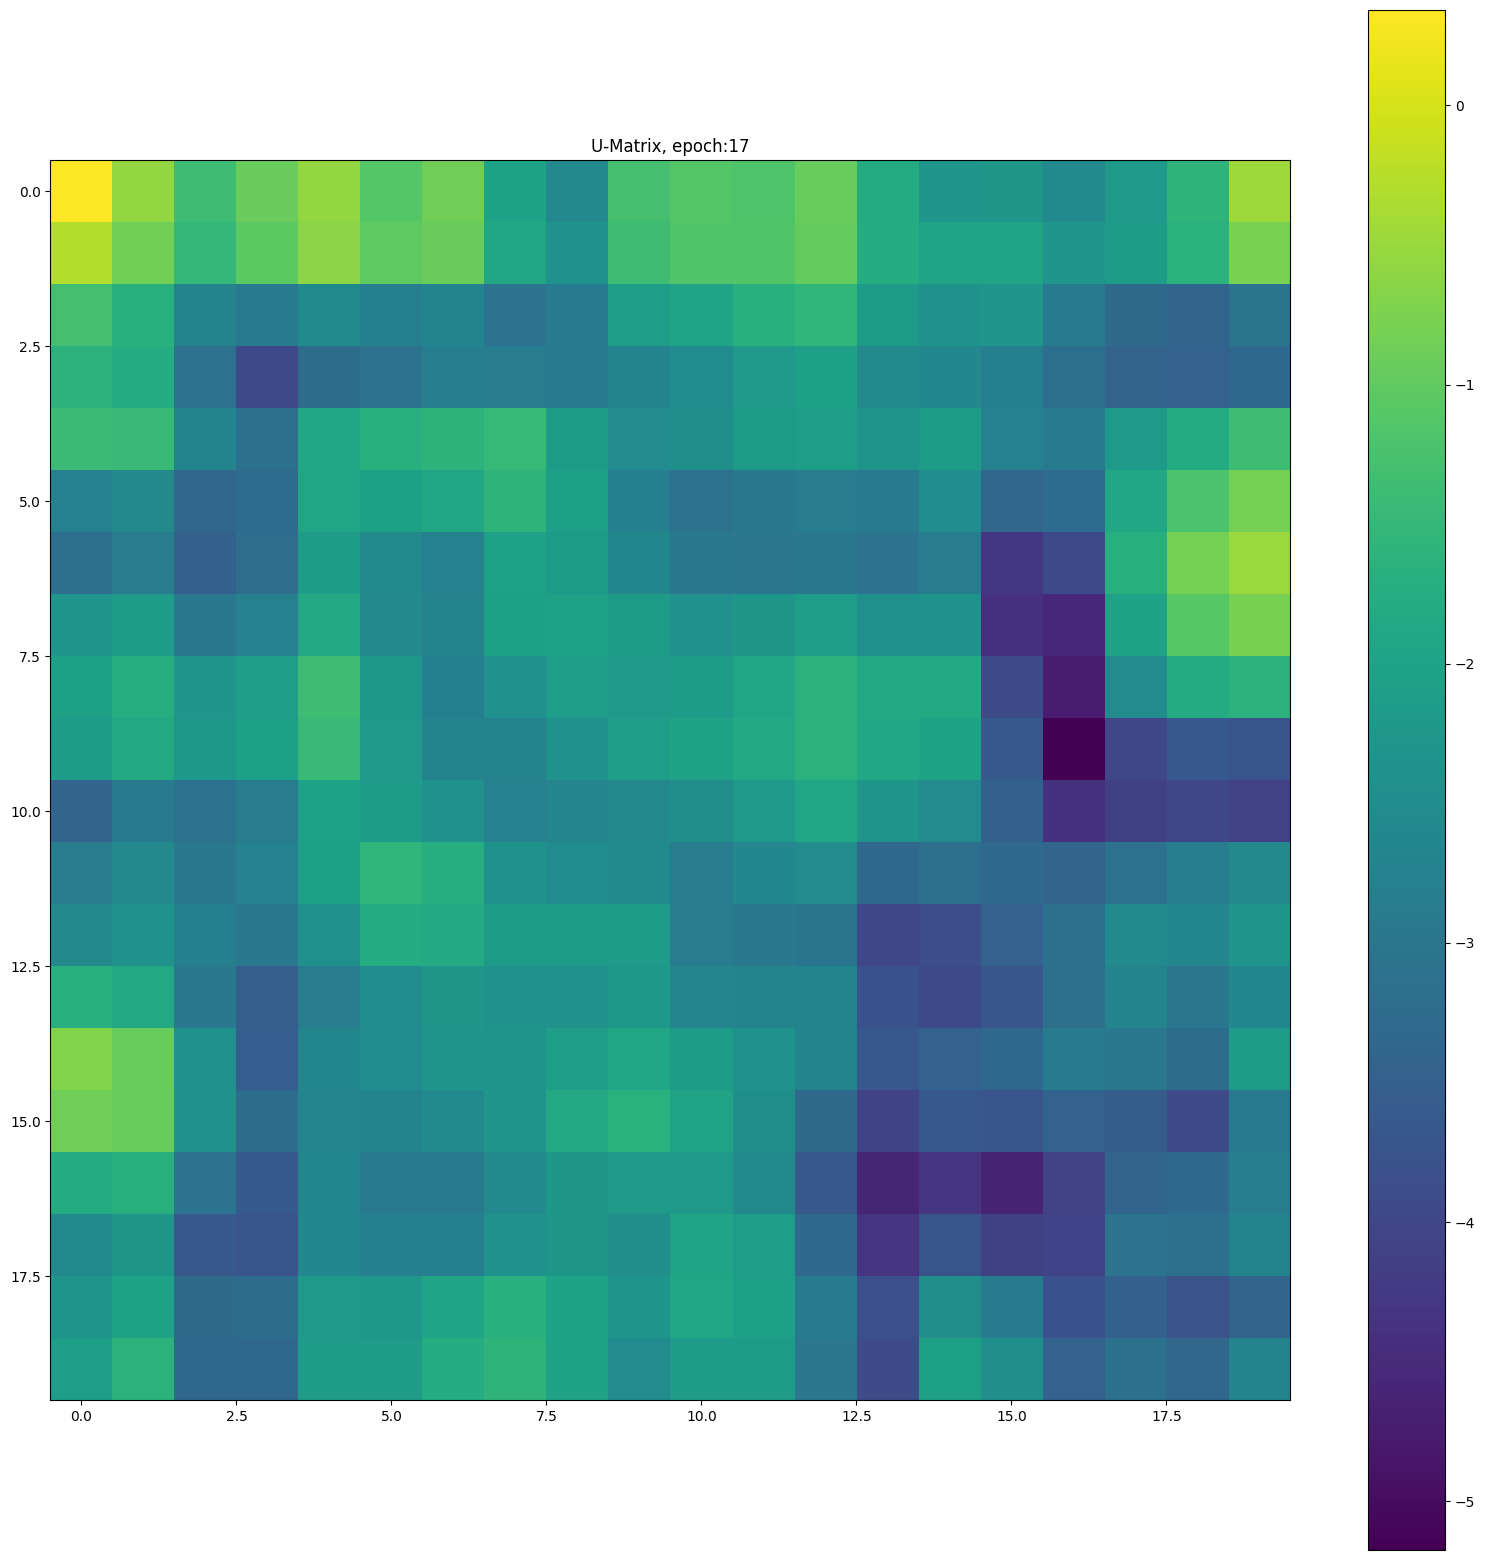

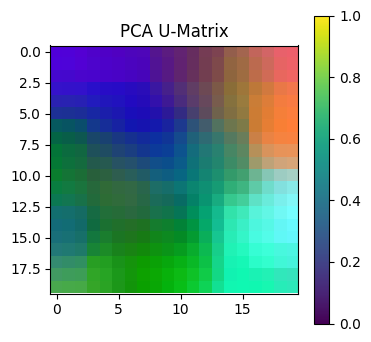

Epoch: 18, QE: 0.2377, TE: 0.3223


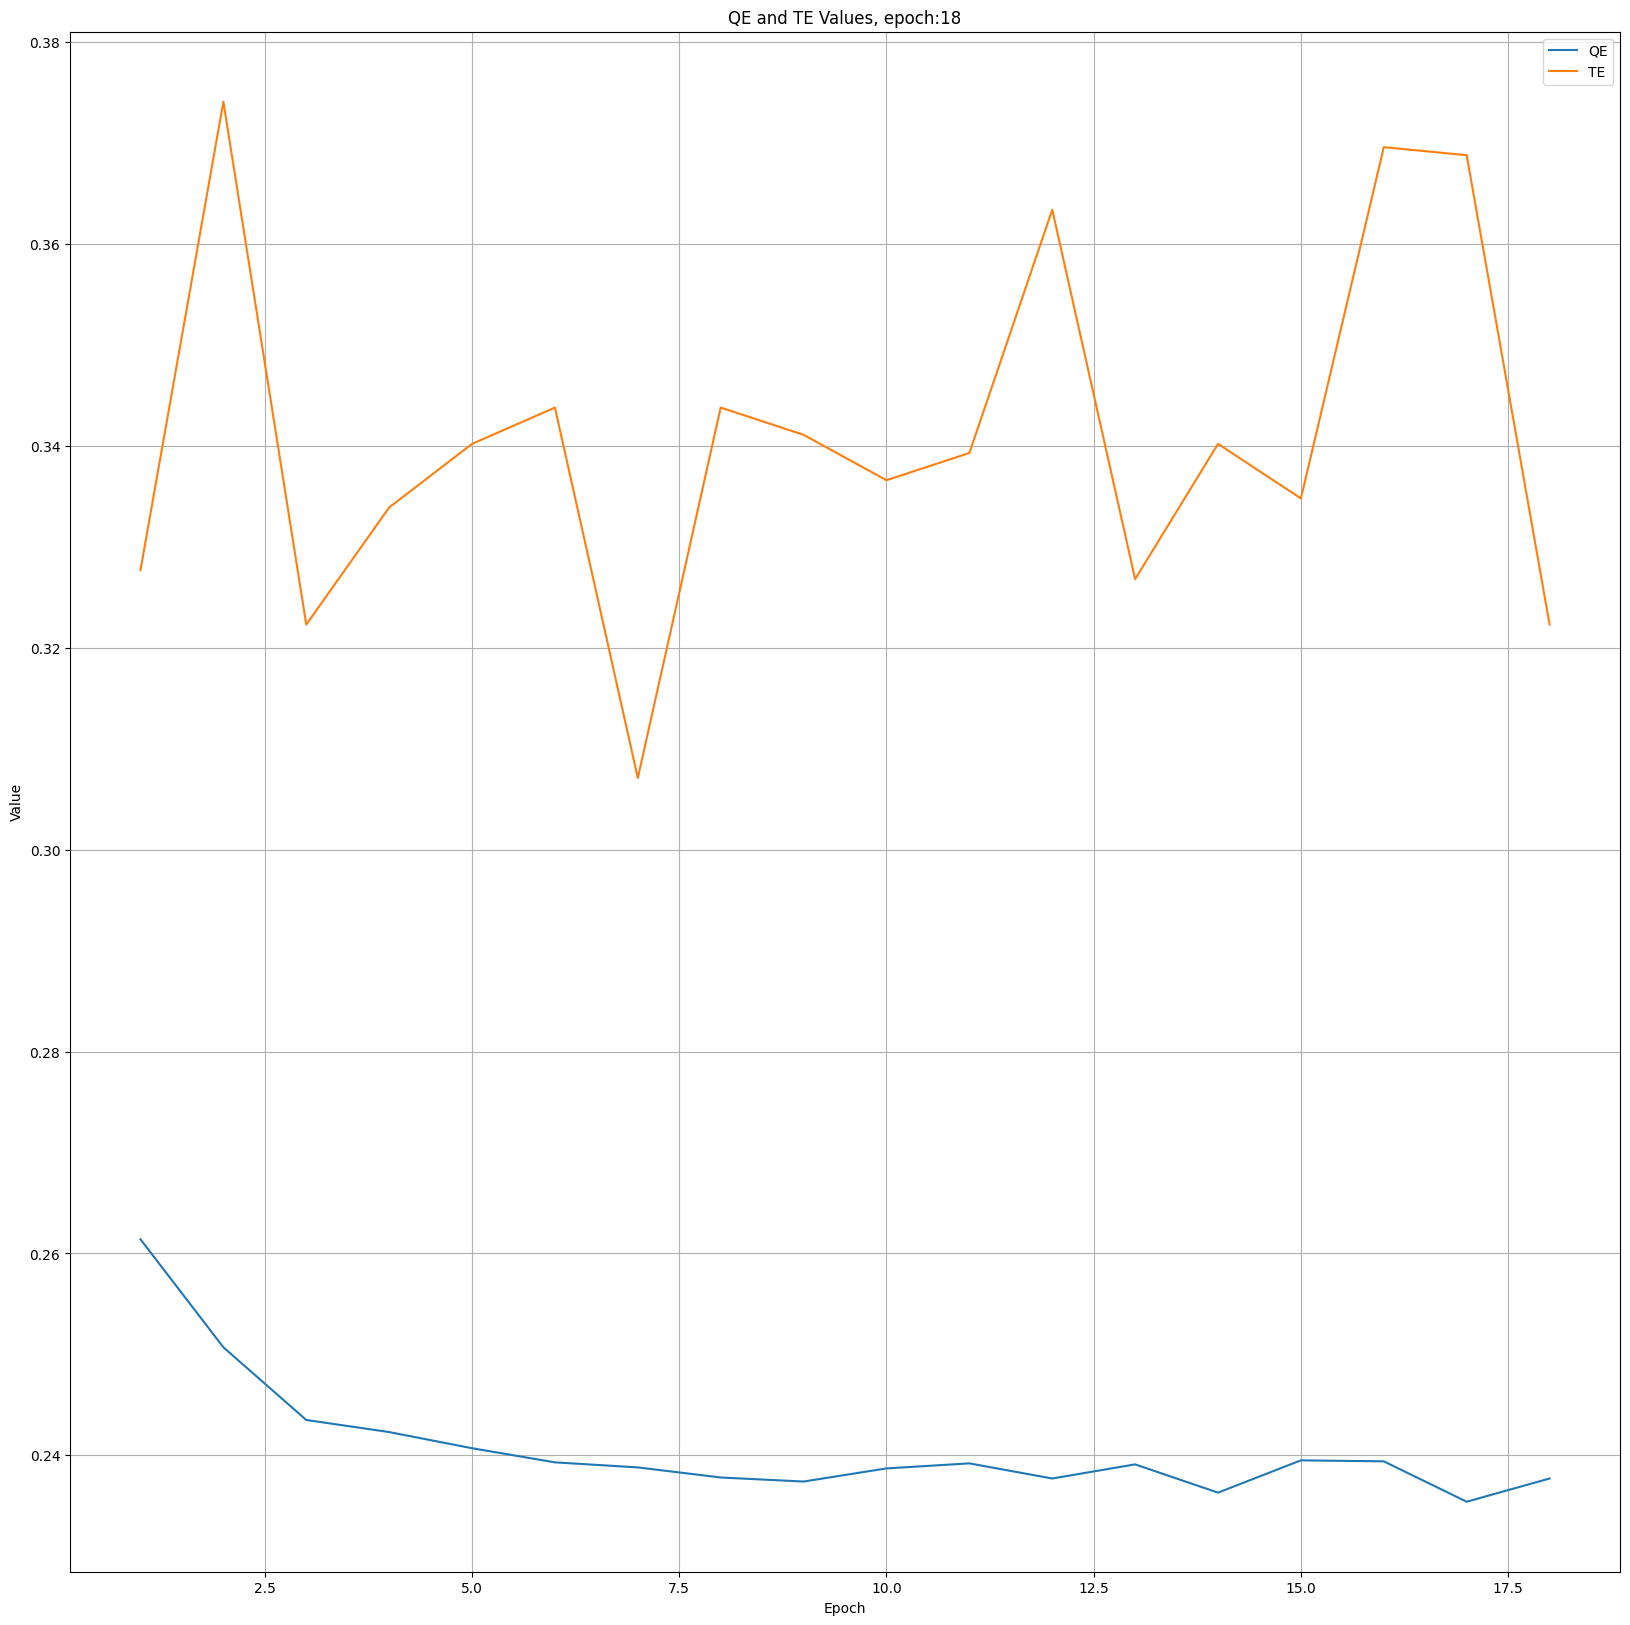

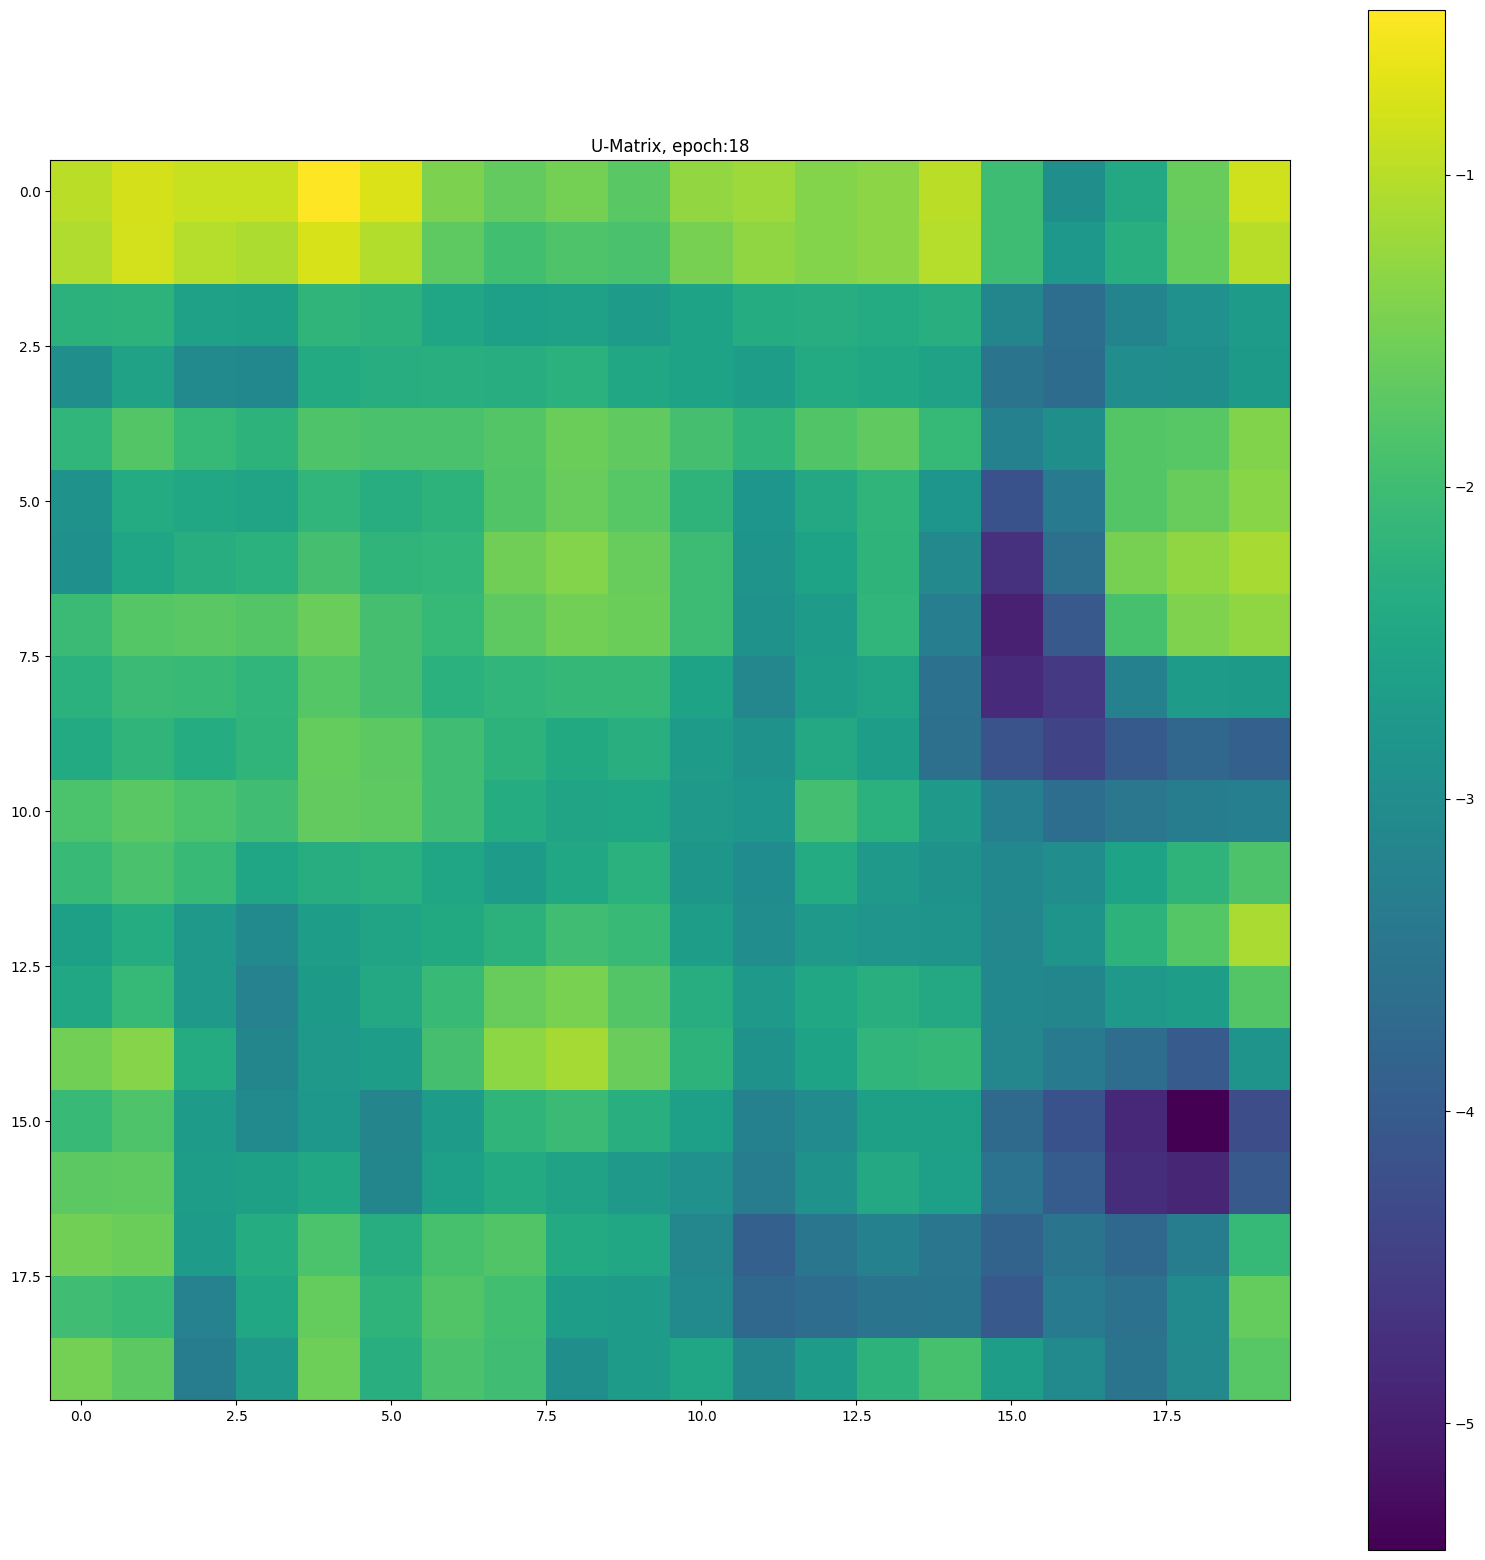

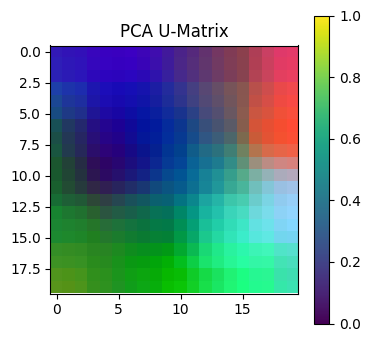

Epoch: 19, QE: 0.2379, TE: 0.3277


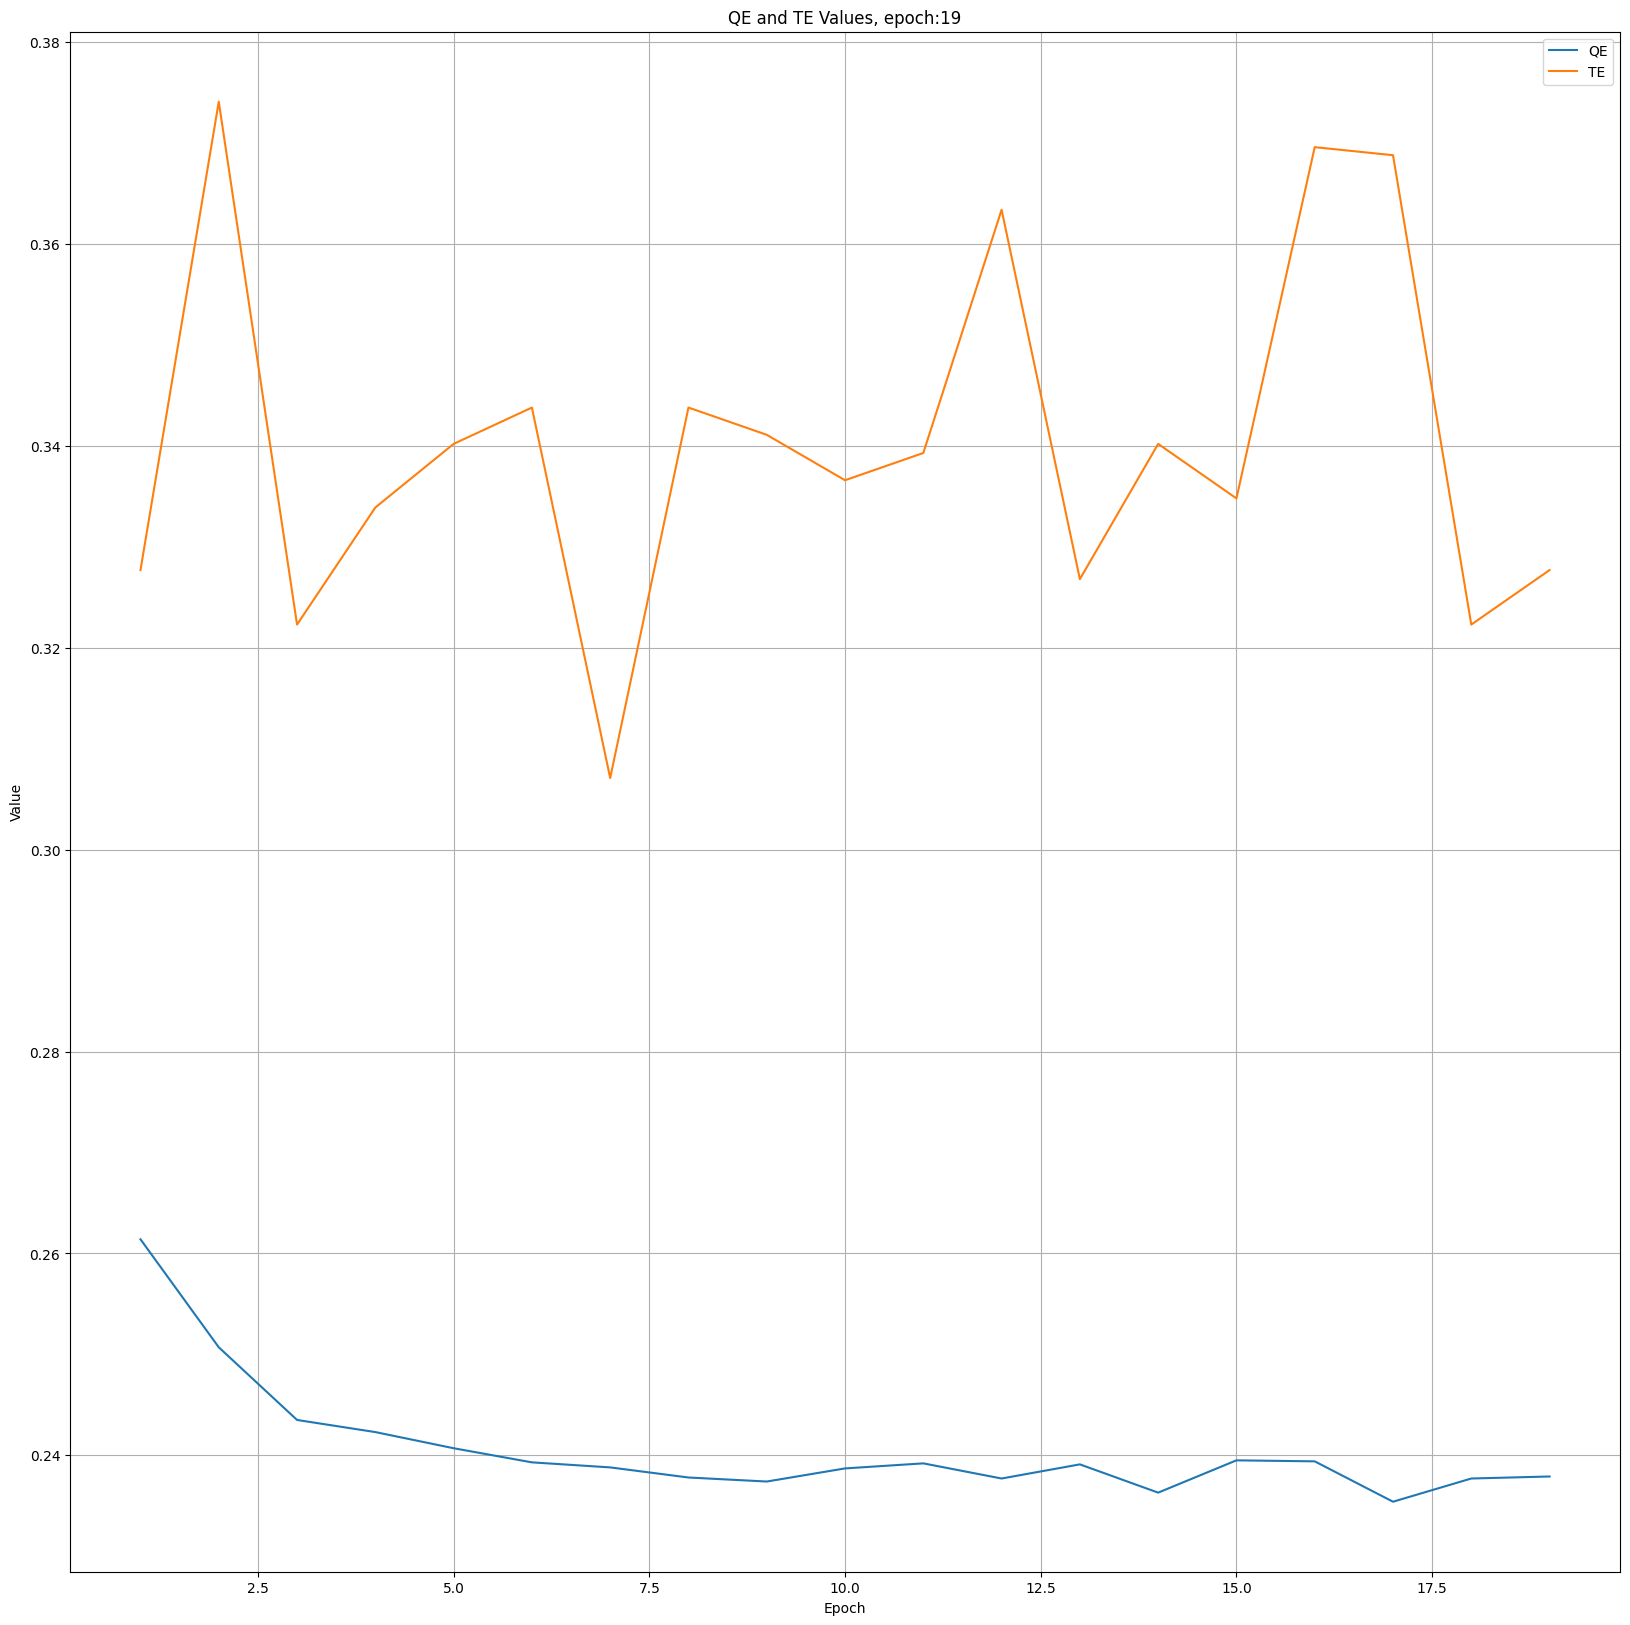

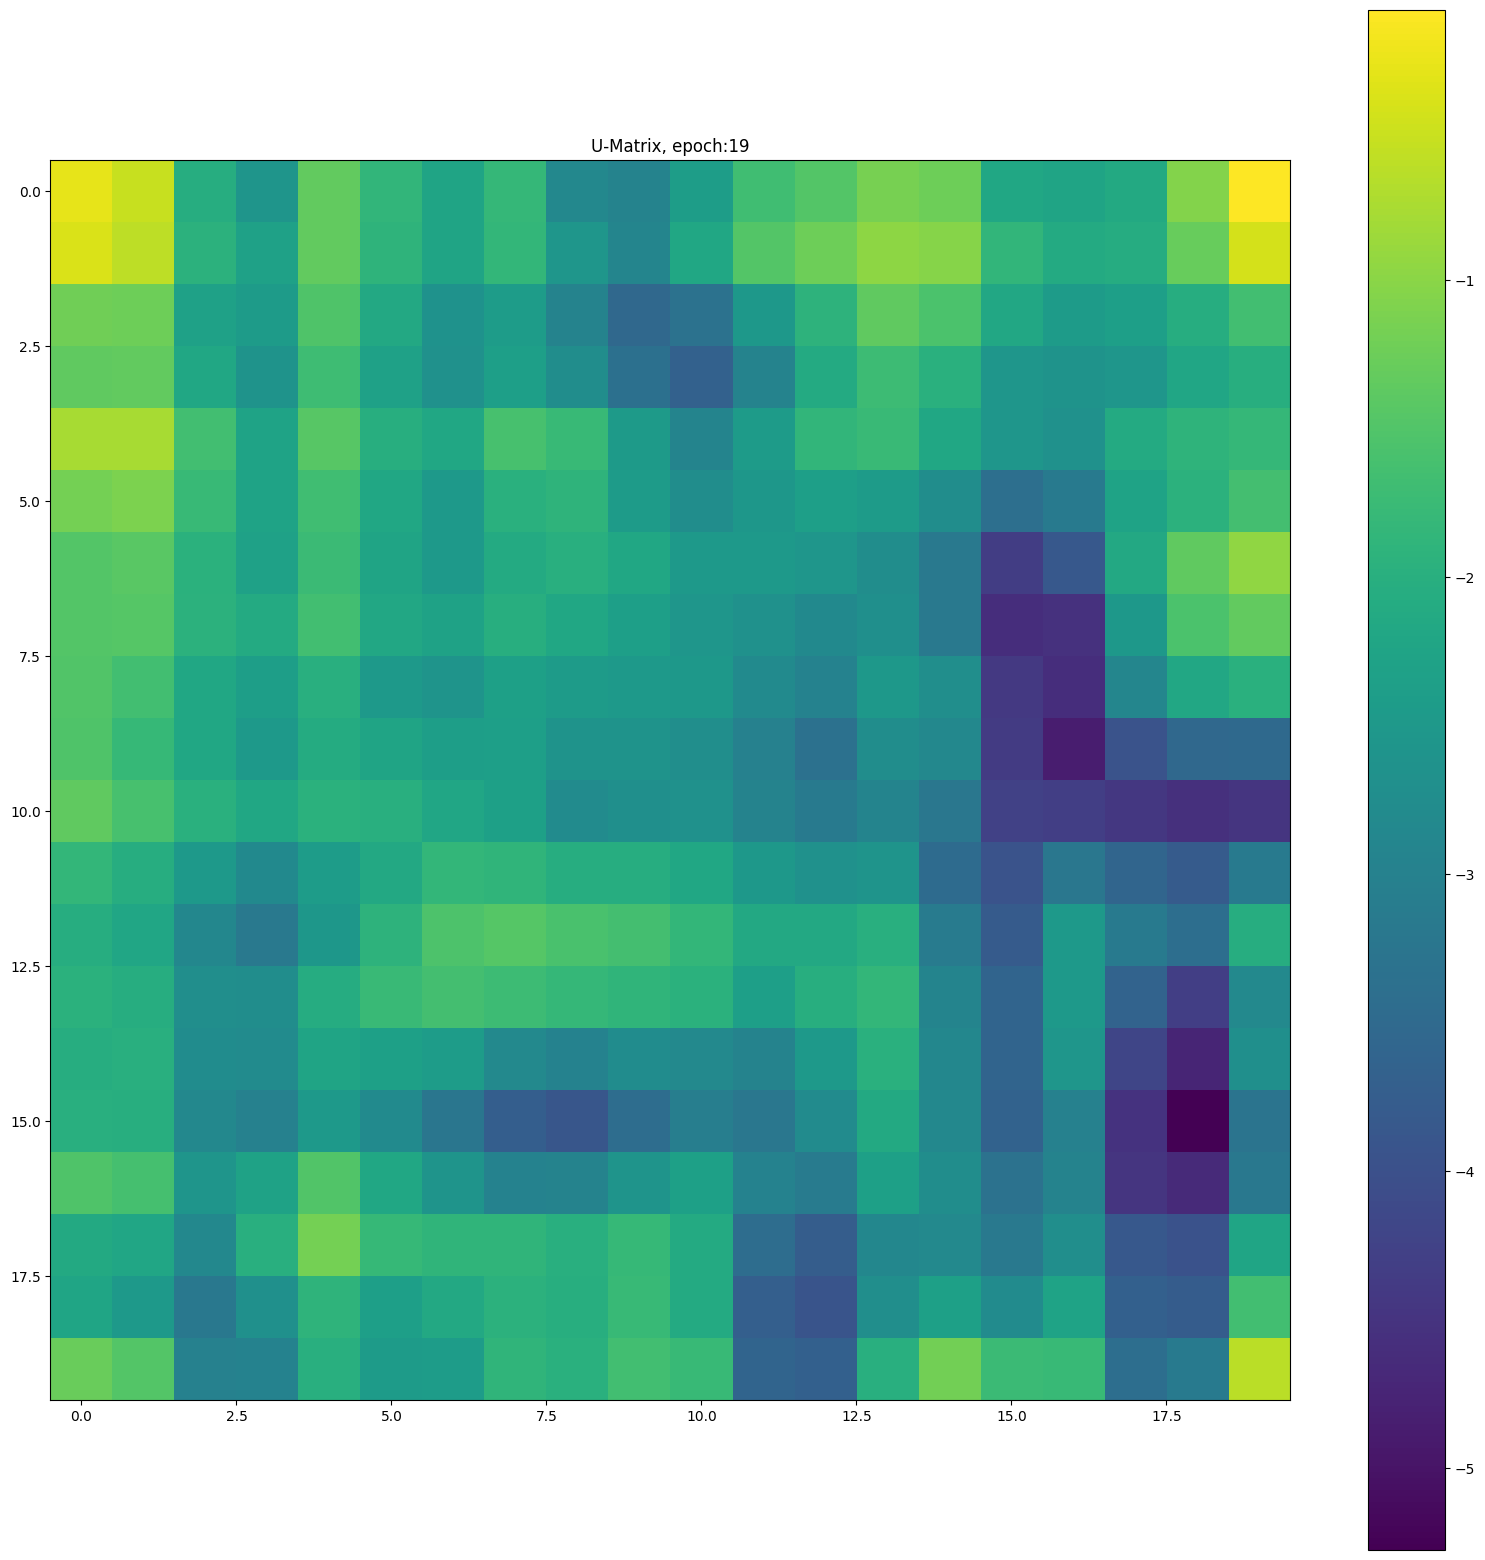

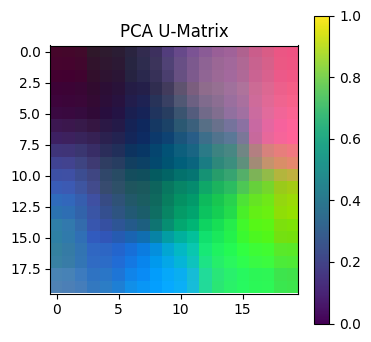

Epoch: 20, QE: 0.2371, TE: 0.3491


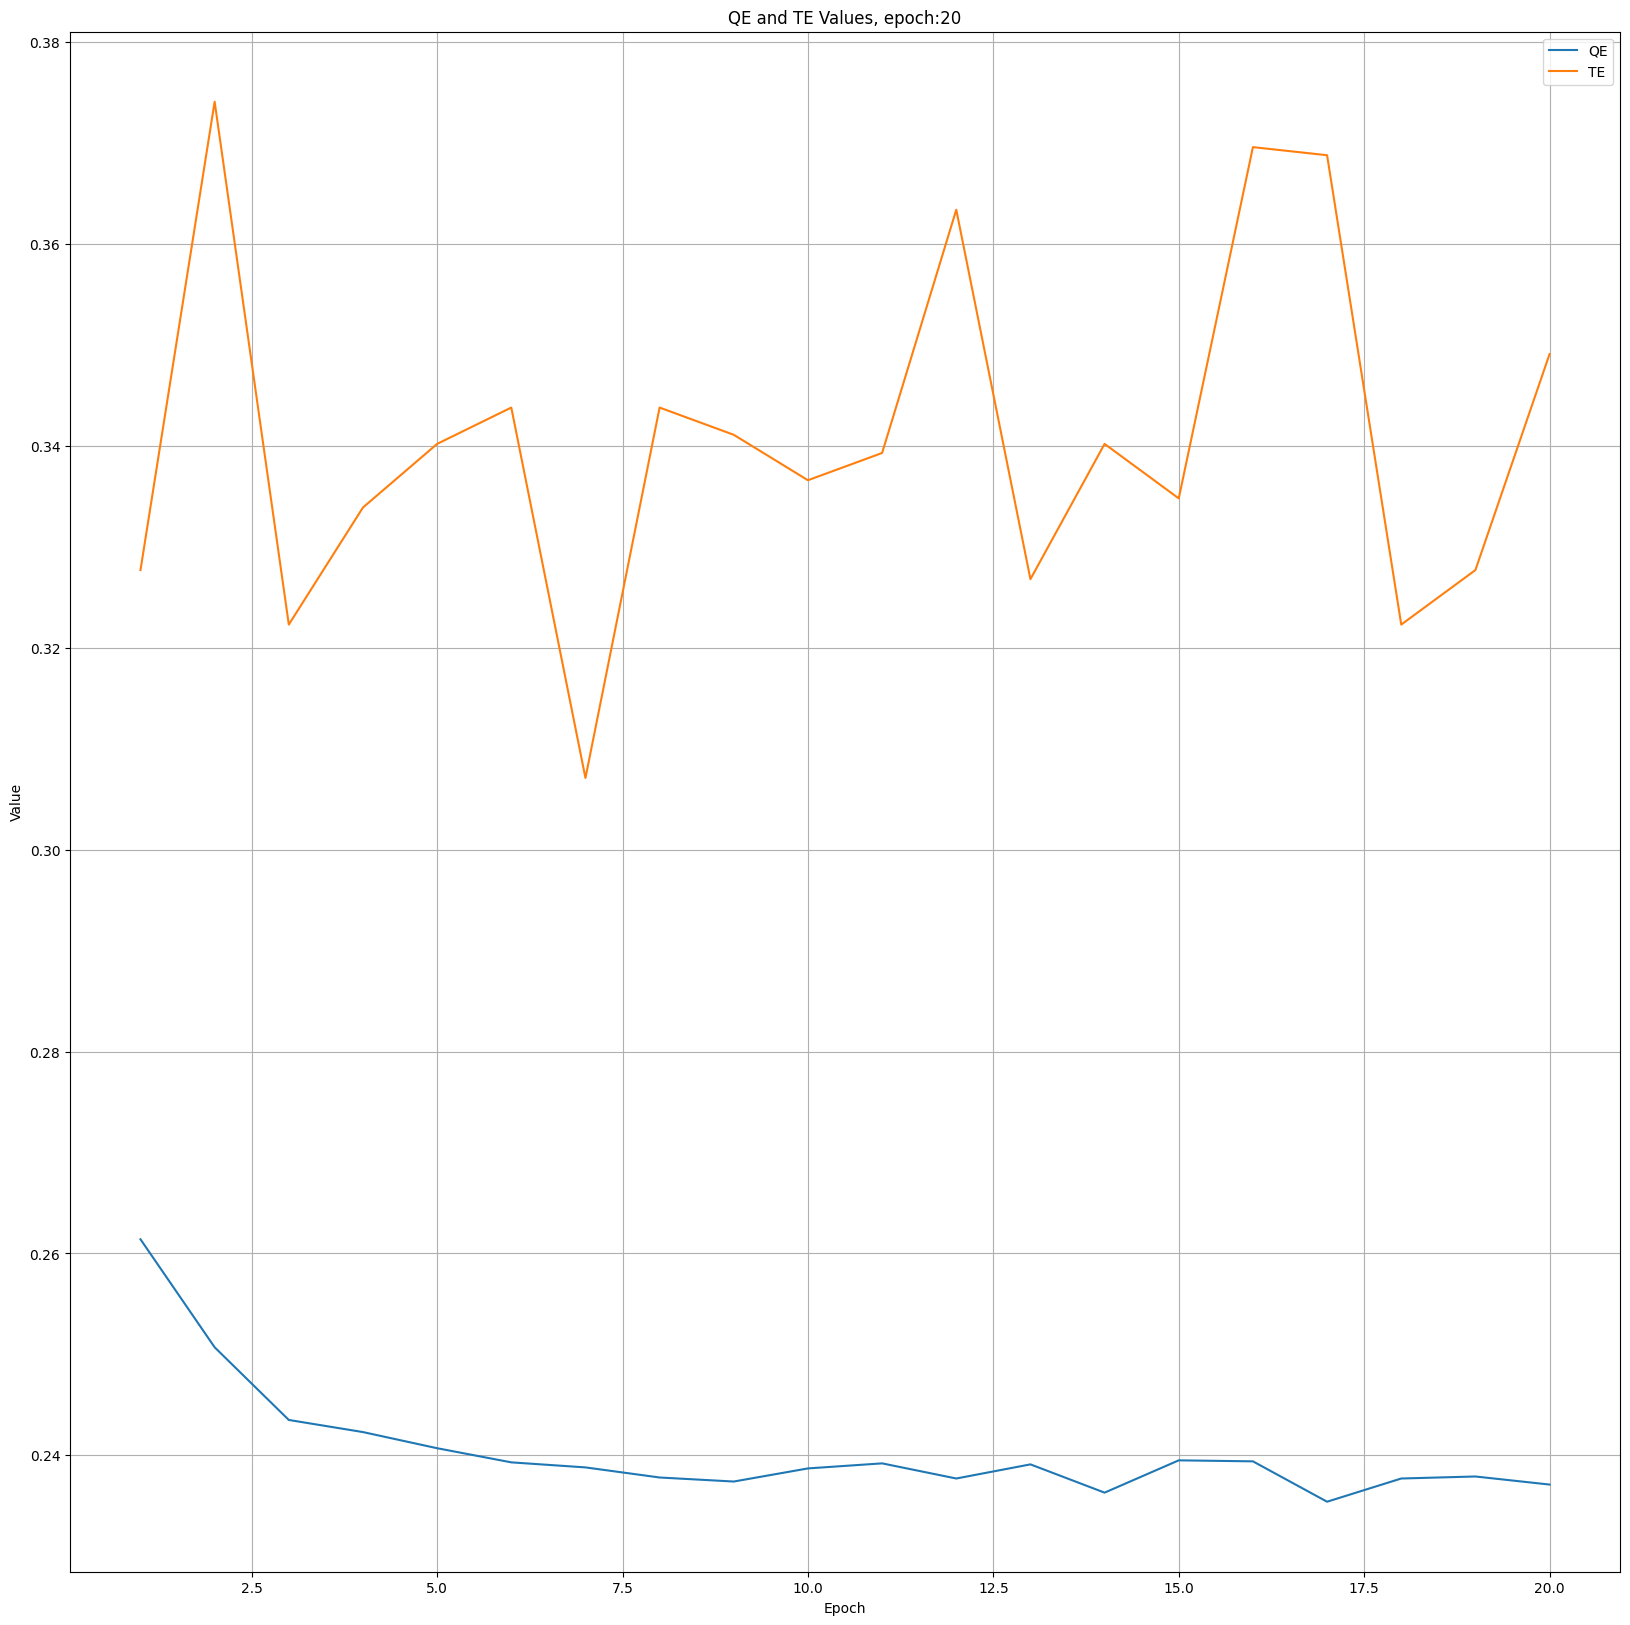

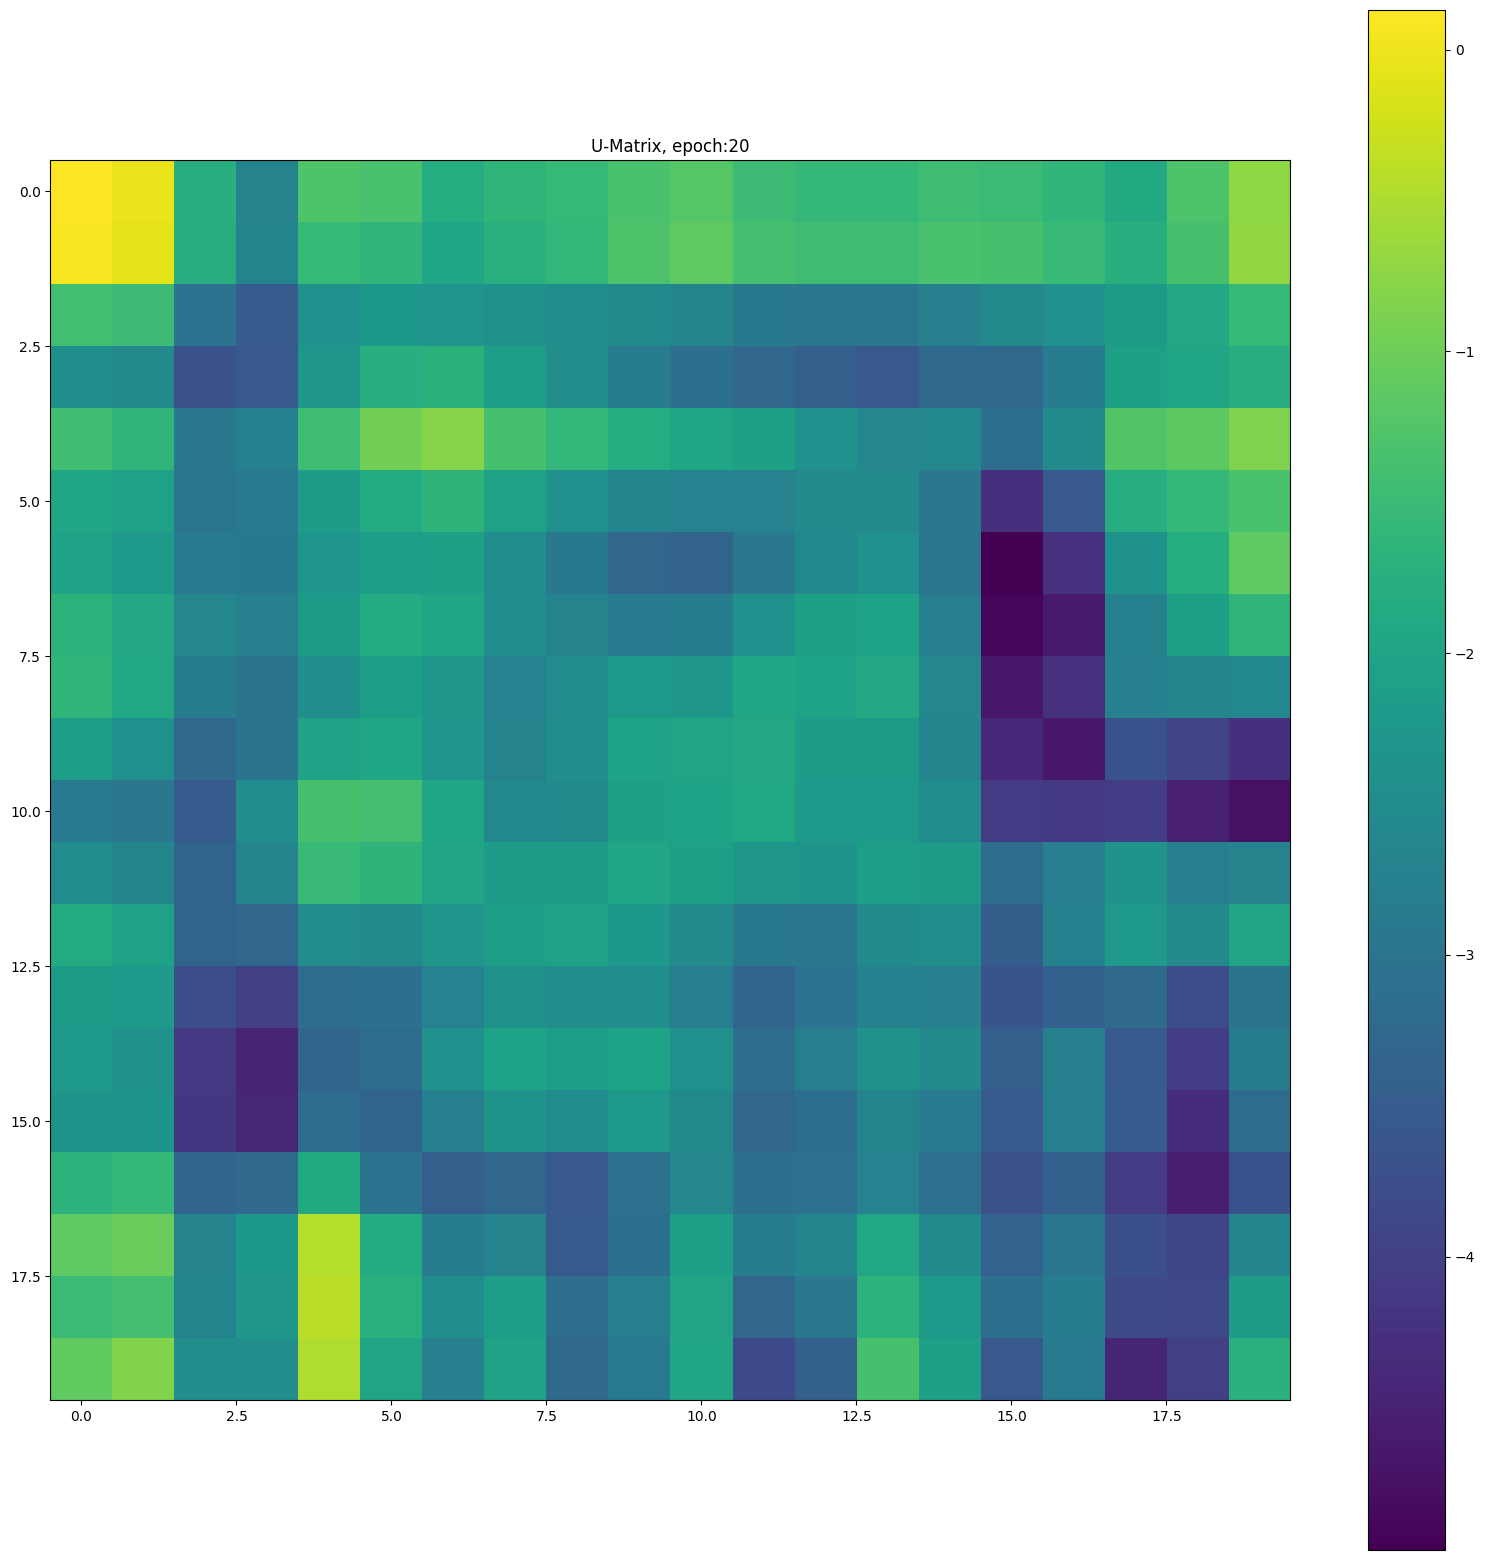

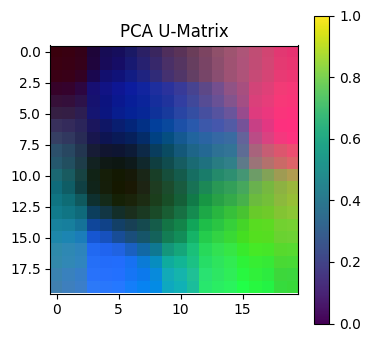

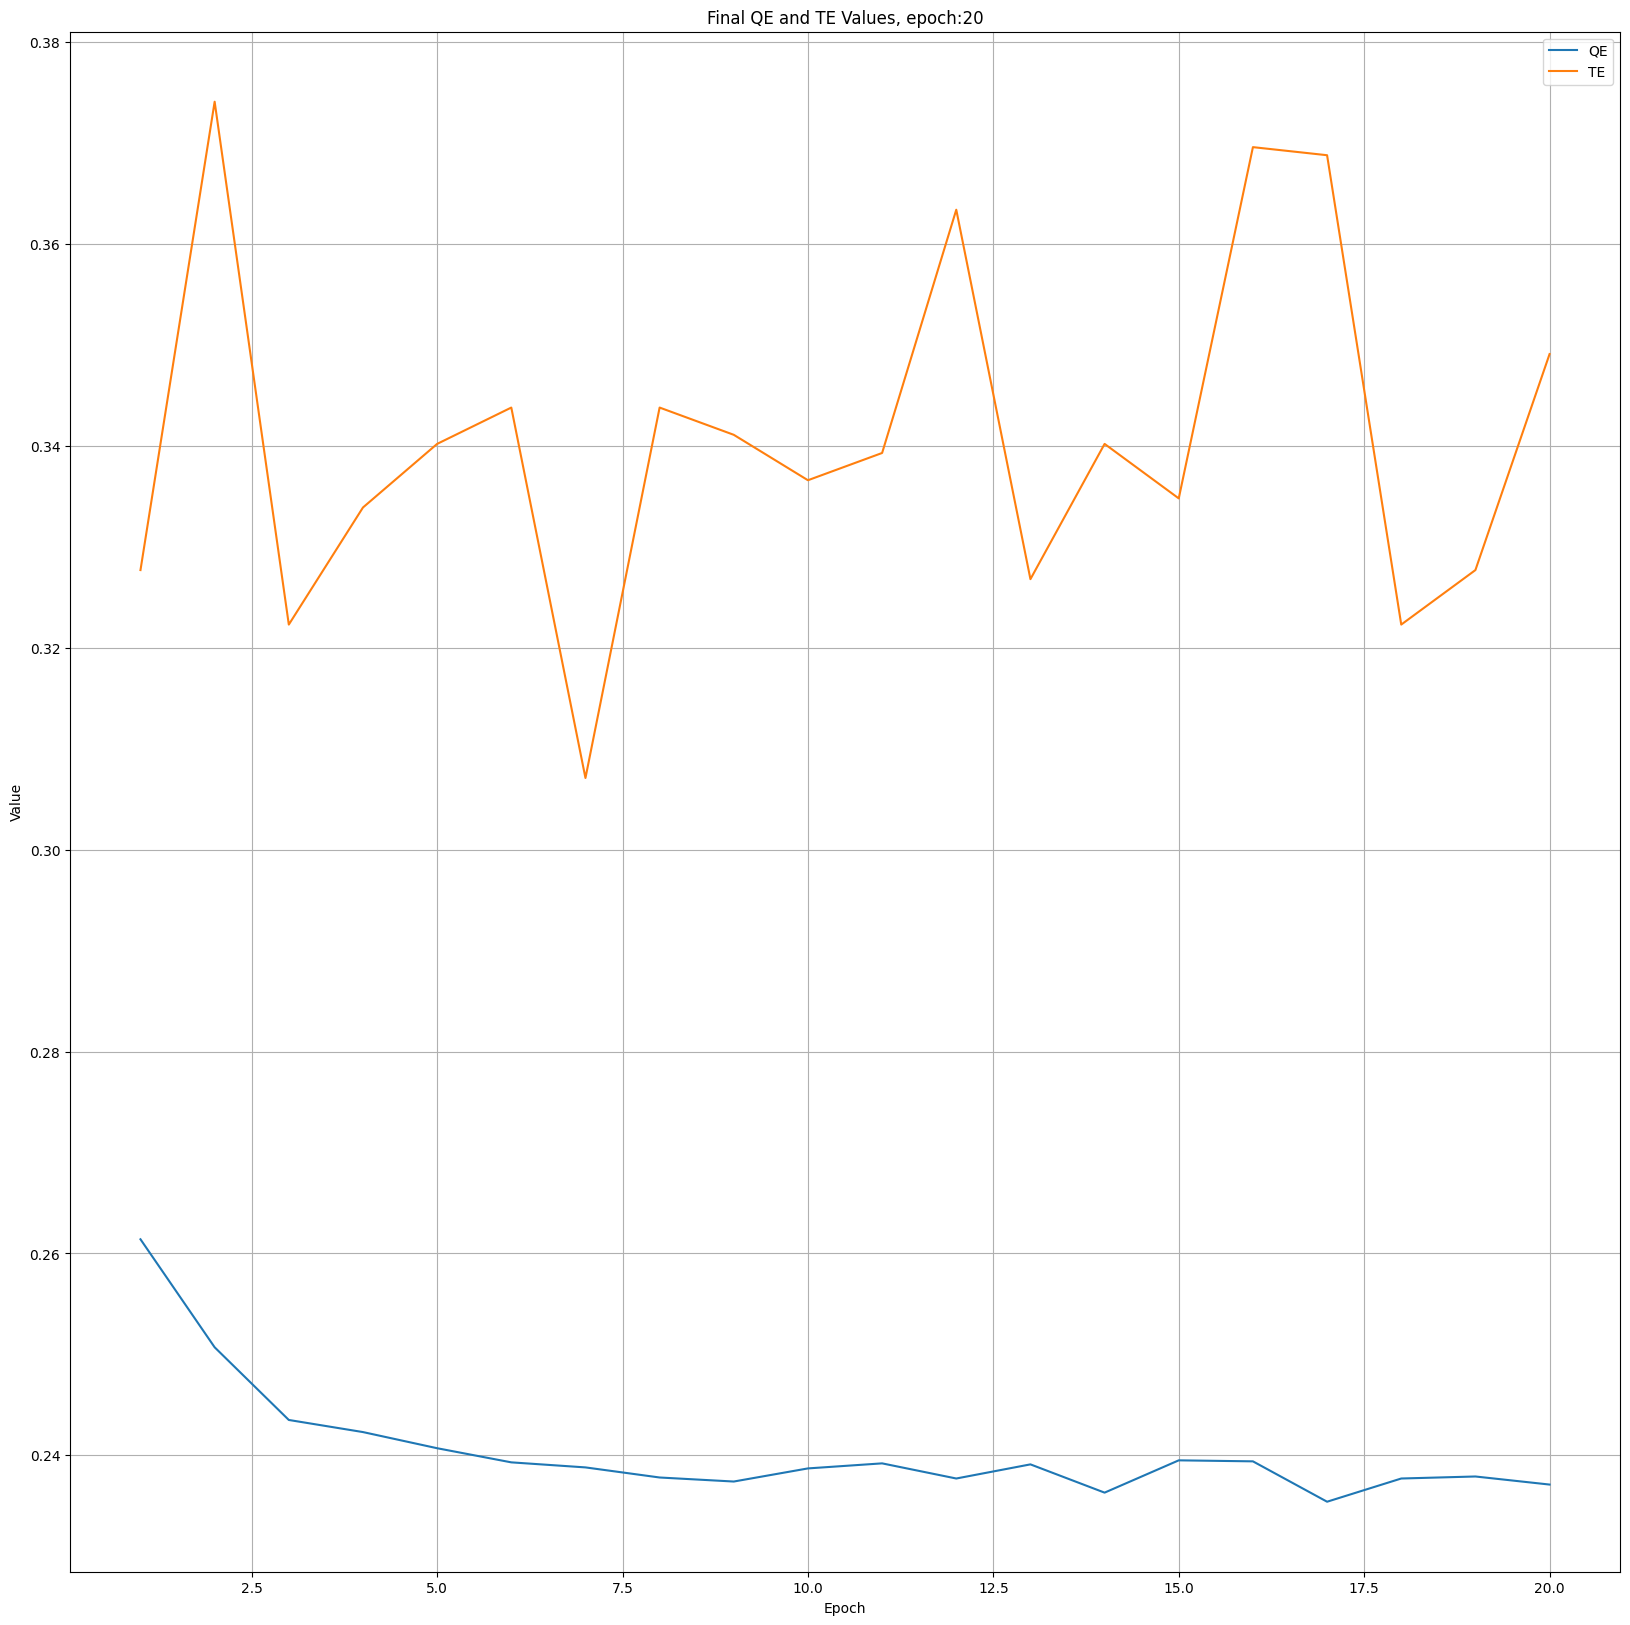

In [22]:
def plot_som_pca(SOM):
    # Reshape the SOM grid into a 2D array
    som_flat = SOM.reshape(-1, SOM.shape[-1])

    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    som_pca = pca.fit_transform(som_flat)

    # Normalize PCA components to [0, 1]
    som_pca_norm = (som_pca - som_pca.min(axis=0)) / (som_pca.max(axis=0) - som_pca.min(axis=0))

    # Create a U-matrix with PCA components as RGB values
    u_matrix_pca = som_pca_norm.reshape(SOM.shape[:-1] + (3,))

    # Plot the U-matrix with PCA colors
    plt.figure(figsize=(4, 4))
    plt.imshow(u_matrix_pca)
    plt.title('PCA U-Matrix')
    plt.colorbar()
    plt.show()

# Initialize SOM grid dimensions
m = 20
n = 20

# Initialize training data
train_data = indiefilmfeatures

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

epochs = 100
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(4, 4),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
QE_values = []
TE_values = []
epoch_numbers = []

# Convert train_data to numpy array
train_data_array = np.array(train_data)

# Training loop
for epochs_per_iter, i in zip([20], range(1)):
    total_epochs += epochs_per_iter

    # Train the SOM for the specified number of epochs_per_iter
    for epoch in range(1, epochs_per_iter + 1):
        SOM = train_SOM(SOM, train_data_array, learn_rate=0.1, radius_sq=12, epochs=1)  # Train for 1 epoch

        # Calculate QE and TE
        QE = round(calculateQE(SOM, train_data_array), 4)
        TE = round(calculateTE(SOM, train_data_array), 4)

        # Print epoch number and QE, TE values
        print(f"Epoch: {total_epochs - epochs_per_iter + epoch}, QE: {QE}, TE: {TE}")

        # Save QE and TE values
        QE_values.append(QE)
        TE_values.append(TE)
        epoch_numbers.append(total_epochs - epochs_per_iter + epoch)

        # Save a copy of SOM at this epoch
        SOMS.append(SOM.copy())

        # Plot QE and TE values after each epoch
        plt.figure(figsize=(20, 20))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the u_matrix after each epoch
        plt.figure(figsize=(20, 20))
        plt.imshow(u_matrix(SOM))
        plt.title('U-Matrix, epoch:'+str(epoch))
        plt.colorbar()
        plt.show()

        # Plot the SOM based on PCA
        plot_som_pca(SOM)

    # Plot the final state of the SOM grid after the last epoch
    if epoch == epochs_per_iter:
        plt.figure(figsize=(20, 20))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Final QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

    ax.imshow(u_matrix(SOM))
    ax.title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Show the final plot
plt.show()

In [21]:
SOM= SOMS[17]

In [23]:
QE = QE_values[17]
TE = TE_values[17]

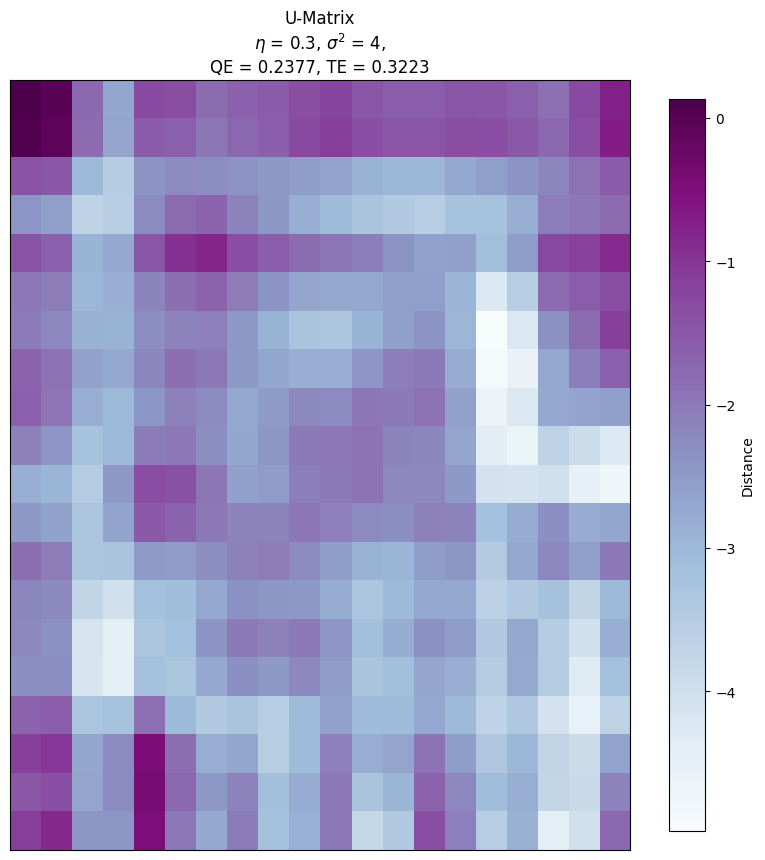

In [24]:
u_matrix_values = u_matrix(SOM)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
indiefilm_som_model = SOMS[17]

In [27]:
with open('indiefilm_som_model.pkl', 'wb') as f:
    pickle.dump(indiefilm_som_model, f)

In [28]:
with open('indiefilm_som_model.pkl', 'rb') as f:
    loaded_indiefilm_som_model = pickle.load(f)

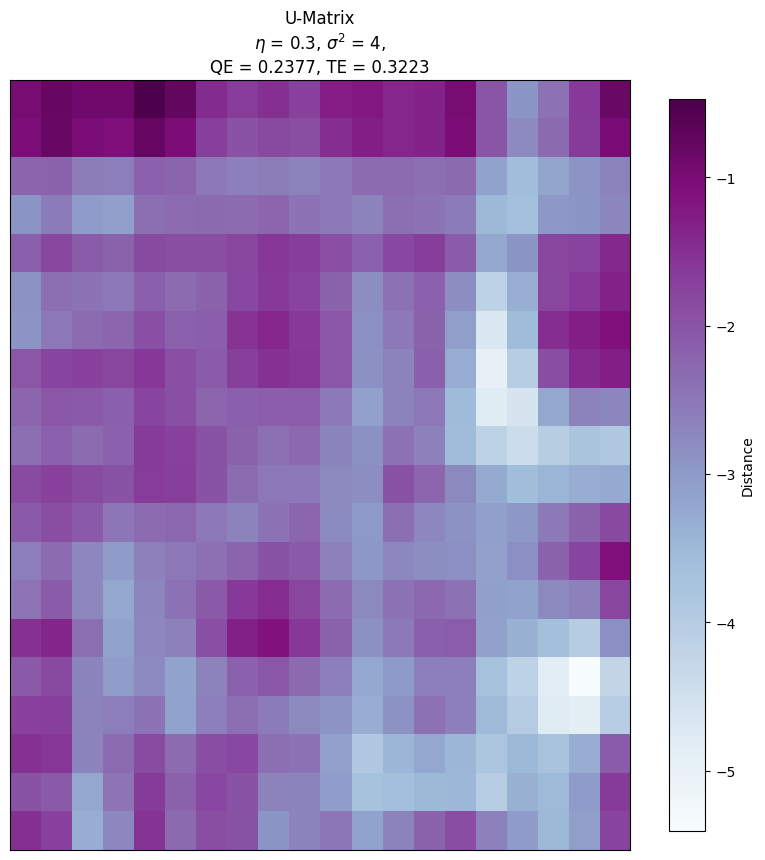

In [29]:
u_matrix_values = u_matrix(loaded_indiefilm_som_model)
QE = round(calculateQE(loaded_indiefilm_som_model, indiefilmfeatures), 4)
TE = round(calculateTE(loaded_indiefilm_som_model, indiefilmfeatures), 4)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [30]:
indiefilm_dict = []
for i in range(len(loaded_indiefilm_som_model)):
    row = []
    for j in range(len(loaded_indiefilm_som_model[0])):
        row.append([])
    indiefilm_dict.append(row)
for i in indiefilmfeatureImagePairs:
    query=i['feature']
    g,h = find_BMU(loaded_indiefilm_som_model,query)
    indiefilm_dict [g][h].append(i)

### Define Search Function

In [31]:
def distance_between(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return np.linalg.norm(a - b)

In [32]:
def find_closest_image_index(distance):
    closest_index = 0
    distance_closest = distance[0]

    for index in range(1, len(distance)):
        if distance[index] < distance_closest:
            distance_closest = distance[index]
            closest_index = index

    return closest_index

In [33]:
def get_closest_image(a,b):
  cell = loaded_indiefilm_som_model[a][b]
  distance = [distance_between(cell, i['feature']) for i in indiefilm_dict[a][b]]
  closest_image_index=find_closest_image_index(distance)
  return closest_image_index

In [36]:
def searchindiefilmframessom(query):
    result=[]
    query_features=[]
    path = query
    q_f = processImage(path, model4)
    query_features.append(q_f)
    activatedSOM = activate(indiefilmfeatures, loaded_indiefilm_som_model, query_features)
    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    im = plt.imshow(activatedSOM, cmap=cm.BuPu, aspect='auto')
    plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    g,h=find_BMU(loaded_indiefilm_som_model,query_features)
    closest_image_index=get_closest_image(g,h)
    result.append(indiefilm_dict[g][h][closest_image_index]['image'])
    return result

1/1 [==============================] - 0s 64ms/step


<Figure size 640x480 with 0 Axes>

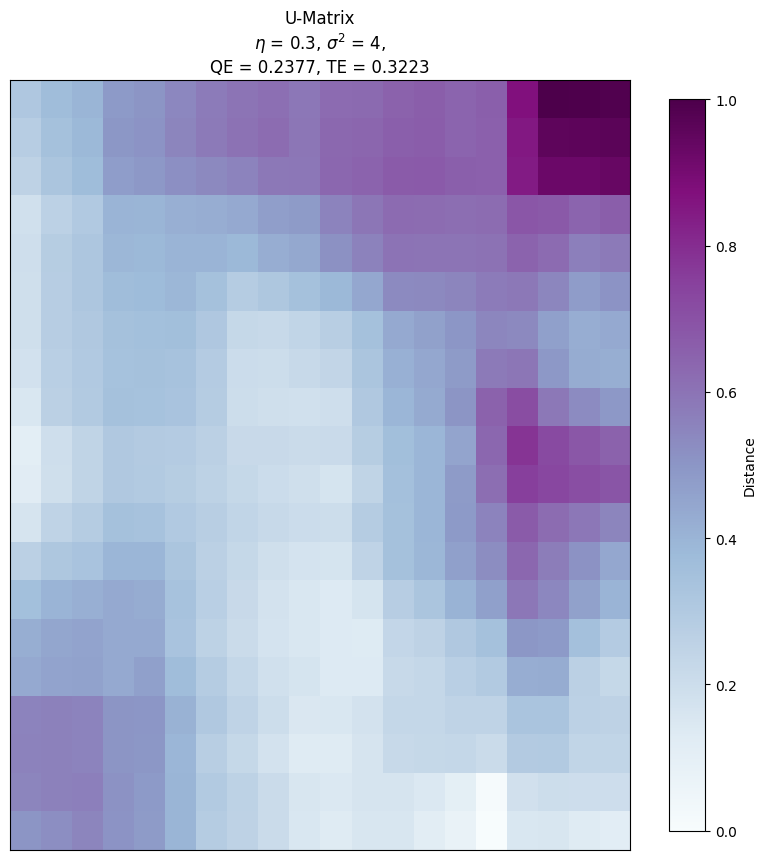

['Good Intentions  Award-Winning Stop-Motion Animated Short Film_frame_2030.jpg']

In [37]:
searchindiefilmframessom('D:\\FinalAssignment\\Images\\keyframe_11.jpg')